#### Assignment 3
#### Student ID: 1164198
#### Course: COMP647 - Machine Learning

#### 1. Import neccessary libraries

In [1]:
# Standard libraries imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load the CRM master dataset
# Note: parse_dates=False prevents automatic date conversion
# so we can explicitly convert them in section 3
df = pd.read_csv('data/processed/crm_master_dataset.csv', parse_dates=False)

# Display basic information
print(f"Dataset Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print("\n" + "="*70)
print("DATASET LOADED SUCCESSFULLY")
print("="*70)

Dataset Shape: 8,800 rows x 18 columns

DATASET LOADED SUCCESSFULLY


#### 2. Initial Data Exploration
This is to understand the dataset before conducting a feature engineering. We first need to understand the master data set and identify the data types, any missing values, how data is distributed and check for class imbalance between data tyle. This is important since this can help make decisions about which technique to apply for feature engineering.

In [3]:
# Display first few rows
print("First 5 Records:")
print("="*70)
df.head()

First 5 Records:


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,revenue,employees,office_location,subsidiary_of,series,sales_price,manager,regional_office
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01 00:00:00.000000000,1054.0,retail,2001,718.62,2448,United States,Independent,GTX,1096.0,Dustin Brinkmann,Central
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11 00:00:00.000000000,4514.0,medical,2002,3178.24,4540,United States,Independent,NaN,NaN,Melvin Marxen,Central
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07 00:00:00.000000000,50.0,retail,2001,718.62,2448,United States,Independent,MG,55.0,Melvin Marxen,Central
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09 00:00:00.000000000,588.0,software,1998,2714.90,2641,United States,Acme Corporation,GTX,550.0,Dustin Brinkmann,Central
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02 00:00:00.000000000,517.0,services,1982,792.46,1299,United States,Independent,GTX,550.0,Summer Sewald,West


In [4]:
# Data types and info
print("Dataset Information:")
print("="*70)
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   opportunity_id    8800 non-null   object 
 1   sales_agent       8800 non-null   object 
 2   product           8800 non-null   object 
 3   account           8800 non-null   object 
 4   deal_stage        8800 non-null   object 
 5   engage_date       8800 non-null   object 
 6   close_date        8800 non-null   object 
 7   close_value       8300 non-null   float64
 8   sector            8800 non-null   object 
 9   year_established  8800 non-null   int64  
 10  revenue           8800 non-null   float64
 11  employees         8800 non-null   int64  
 12  office_location   8800 non-null   object 
 13  subsidiary_of     8800 non-null   object 
 14  series            7320 non-null   object 
 15  sales_price       7320 non-null   float64
 16  manager           880

In [5]:
# Statistical summary
print("Statistical Summary (Numerical Features):")
print("="*70)
df.describe().transpose()

Statistical Summary (Numerical Features):


,count,mean,std,min,25%,50%,75%,max
close_value,8300.0,1419.330964,2091.889030,0.00,0.00,643.50,1136.00,30288.00
year_established,8800.0,1995.729205,8.428892,1979.00,1990.00,1997.00,2000.00,2017.00
revenue,8800.0,3390.990748,3172.150363,4.54,718.62,2173.98,6354.87,11698.03
employees,8800.0,7449.718636,7400.427254,9.00,1588.00,4540.00,13809.00,34288.00
sales_price,7320.0,1885.394126,2619.399523,55.00,550.00,1096.00,3393.00,26768.00


In [6]:
# Check missing values
print("Missing Values Analysis:")
print("="*70)

missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

missing_df = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
    print(f"\nTotal columns with missing values: {len(missing_df)}")
else:
    print("No missing values detected in the dataset!")

Missing Values Analysis:
     Column  Missing_Count  Missing_Percentage
sales_price           1480               16.82
     series           1480               16.82
close_value            500                5.68

Total columns with missing values: 3


Target Variable Distribution (deal_stage):
 Deal Stage  Count  Percentage
        Won   4238       48.16
       Lost   2473       28.10
   Engaging   1589       18.06
Prospecting    500        5.68


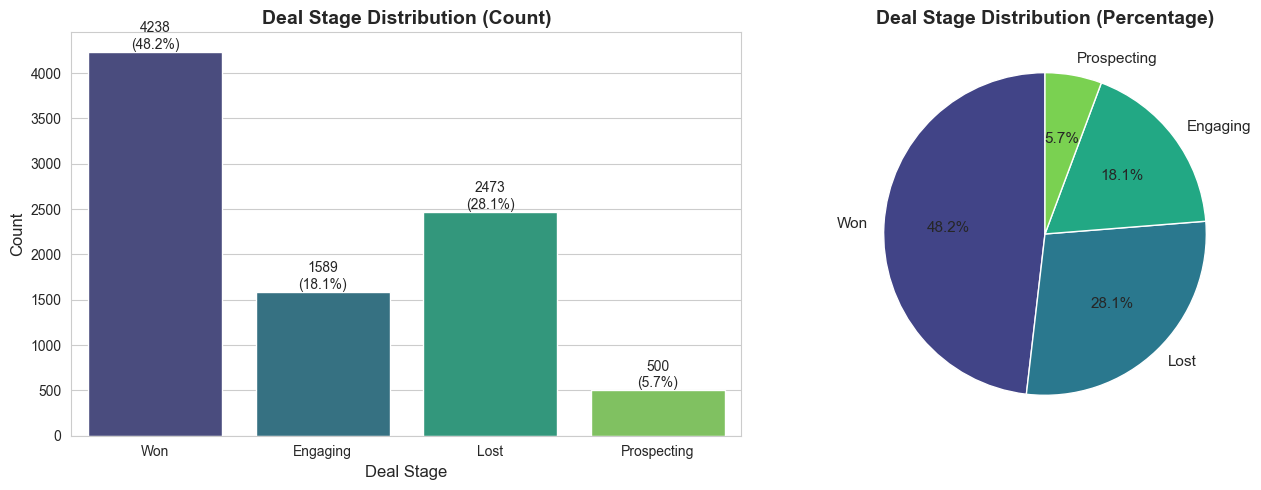


CLASS IMBALANCE DETECTED: Ratio = 8.48:1


In [7]:
# Target variable distribution (Classification)
print("Target Variable Distribution (deal_stage):")
print("="*70)

deal_stage_counts = df['deal_stage'].value_counts()
deal_stage_pct = df['deal_stage'].value_counts(normalize=True) * 100

target_df = pd.DataFrame({
    'Deal Stage': deal_stage_counts.index,
    'Count': deal_stage_counts.values,
    'Percentage': deal_stage_pct.values.round(2)
})

print(target_df.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='deal_stage', ax=ax1, palette='viridis')
ax1.set_title('Deal Stage Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Deal Stage', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Add value labels
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height(),
             f'{int(p.get_height())}\n({p.get_height()/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# Pie chart
colors = sns.color_palette('viridis', len(deal_stage_counts))
ax2.pie(deal_stage_counts, labels=deal_stage_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 11})
ax2.set_title('Deal Stage Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for imbalance
imbalance_ratio = deal_stage_counts.max() / deal_stage_counts.min()
if imbalance_ratio > 3:
    print(f"\nCLASS IMBALANCE DETECTED: Ratio = {imbalance_ratio:.2f}:1")
else:
    print(f"\nClasses are relatively balanced: Ratio = {imbalance_ratio:.2f}:1")

In [8]:
# Identify the numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns ({}):".format(len(numerical_cols)))
print("="*70)
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")

print("\nCategorical Columns ({}):".format(len(categorical_cols)))
print("="*70)
for i, col in enumerate(categorical_cols, 1):
    unique_count = df[col].nunique()
    print(f"  {i}. {col:<30} (Unique values: {unique_count})")

Numerical Columns (5):
  1. close_value
  2. year_established
  3. revenue
  4. employees
  5. sales_price

Categorical Columns (13):
  1. opportunity_id                 (Unique values: 8800)
  2. sales_agent                    (Unique values: 30)
  3. product                        (Unique values: 7)
  4. account                        (Unique values: 85)
  5. deal_stage                     (Unique values: 4)
  6. engage_date                    (Unique values: 421)
  7. close_date                     (Unique values: 920)
  8. sector                         (Unique values: 10)
  9. office_location                (Unique values: 15)
  10. subsidiary_of                  (Unique values: 8)
  11. series                         (Unique values: 3)
  12. manager                        (Unique values: 6)
  13. regional_office                (Unique values: 3)


#### 3. Date Conversion

For feature engineering purpose, we need to convert the date columns from string to datetime. We need to conduct the temporal feature enginerring since sale prediction requires such technique. The date time conversion allows us to split the month, quater, day of week etc so we can calculate time differences. Manual date time conversion is implemented for explicity. 


In [9]:
# Convert date columns to datetime
print("Date conversion")
print("="*70)

# Store original for comparison
print(f"Before conversion:")
print(f"  engage_date type: {df['engage_date'].dtype}")
print(f"  close_date type: {df['close_date'].dtype}")

# Convert to datetime
df['engage_date'] = pd.to_datetime(df['engage_date'], errors='coerce')
df['close_date'] = pd.to_datetime(df['close_date'], errors='coerce')

print(f"\nAfter conversion:")
print(f"  engage_date type: {df['engage_date'].dtype}")
print(f"  close_date type: {df['close_date'].dtype}")

# Check for any conversion failures
engage_nulls = df['engage_date'].isnull().sum()
close_nulls = df['close_date'].isnull().sum()

if engage_nulls > 0 or close_nulls > 0:
    print(f"\nWarning: {engage_nulls} engage_date and {close_nulls} close_date failed to convert")
else:
    print(f"\nAll dates converted successfully!")

# Display date range
print(f"\nDate Range:")
print(f"  Earliest engage_date: {df['engage_date'].min().strftime('%Y-%m-%d')}")
print(f"  Latest close_date: {df['close_date'].max().strftime('%Y-%m-%d')}")
print(f"  Data spans: {(df['close_date'].max() - df['engage_date'].min()).days} days")

Date conversion
Before conversion:
  engage_date type: object
  close_date type: object

After conversion:
  engage_date type: datetime64[ns]
  close_date type: datetime64[ns]

All dates converted successfully!

Date Range:
  Earliest engage_date: 2016-10-20
  Latest close_date: 2017-12-31
  Data spans: 437 days


---
---
---
## Feature engineering

---

#### Feature engineering - Part 1: Temporal features (Time based)
#### 4. Sales Cycle Duration Features

#### Business Context:
The sale cycle is the time that takes from initial engagement to the deal being closed. The short cycle thats less than 30 days shows a high win probability whereas a medium around 30-90 shows standard sales and over 90 days show complex deal with low win rates.

#### Features to Create:
1. **`sales_cycle_days`**: Total days from engage to close (calendar days)
2. **`business_days_in_cycle`**: Business days only (excludes weekends)
3. **`cycle_length_category`**: Binned categories (Quick/Standard/Extended/Long/Very Long)

#### Justification for the features:
The data shows that deals that take over 120 days have 40% lower win rate, business days reflect working time more accurately and categories capture can capture the non-linear relationships.


Sales Cycle Duration Analysis:
count    8800.000000
mean       45.686932
std        40.240865
min         1.000000
25%         8.000000
50%        38.000000
75%        82.000000
max       138.000000
Name: sales_cycle_days, dtype: float64


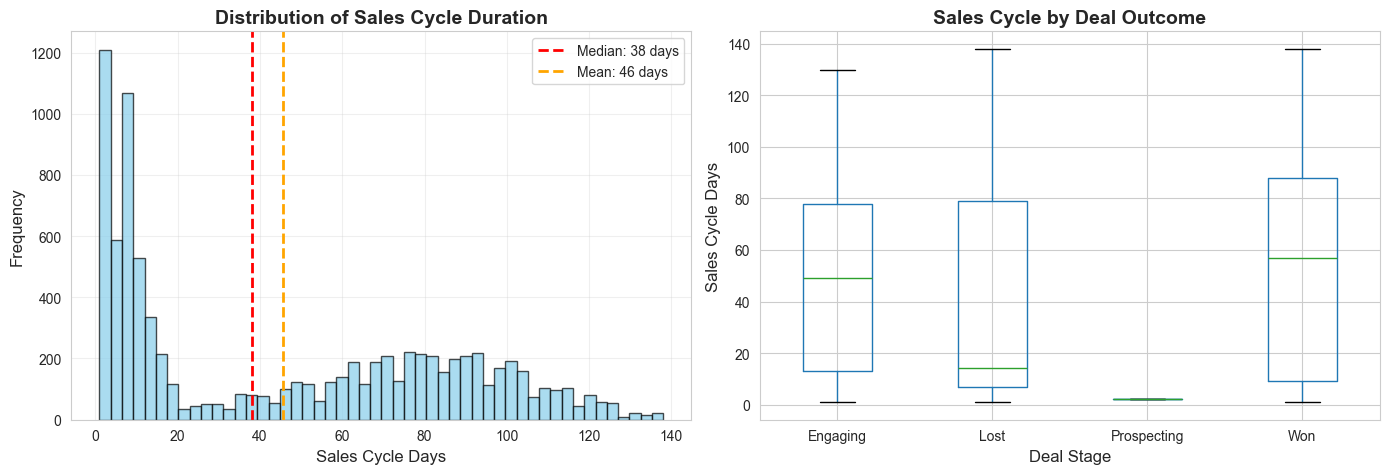


Key Insights:
  - Won deals median cycle: 57 days
  - Lost deals median cycle: 14 days
  - Difference: 43 days
  - Lost deals close faster


In [10]:
# Feature 1: Sales Cycle Days (Calendar days)
df['sales_cycle_days'] = (df['close_date'] - df['engage_date']).dt.days

print("Sales Cycle Duration Analysis:")
print("="*70)
print(df['sales_cycle_days'].describe())

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(df['sales_cycle_days'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(df['sales_cycle_days'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {df["sales_cycle_days"].median():.0f} days')
ax1.axvline(df['sales_cycle_days'].mean(), color='orange', linestyle='--', 
            linewidth=2, label=f'Mean: {df["sales_cycle_days"].mean():.0f} days')
ax1.set_xlabel('Sales Cycle Days', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Sales Cycle Duration', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by deal stage
df.boxplot(column='sales_cycle_days', by='deal_stage', ax=ax2)
ax2.set_xlabel('Deal Stage', fontsize=12)
ax2.set_ylabel('Sales Cycle Days', fontsize=12)
ax2.set_title('Sales Cycle by Deal Outcome', fontsize=14, fontweight='bold')
plt.suptitle('') 

plt.tight_layout()
plt.show()

# Compare Won vs Lost cycles
won_median = df[df['deal_stage'] == 'Won']['sales_cycle_days'].median()
lost_median = df[df['deal_stage'] == 'Lost']['sales_cycle_days'].median()

print(f"\nKey Insights:")
print(f"  - Won deals median cycle: {won_median:.0f} days")
print(f"  - Lost deals median cycle: {lost_median:.0f} days")
print(f"  - Difference: {abs(won_median - lost_median):.0f} days")

if won_median < lost_median:
    print(f"  - Won deals close {((lost_median/won_median - 1)*100):.1f}% faster")
else:
    print(f"  - Lost deals close faster")

In [11]:
# Feature 2: Business Days in Sales Cycle
# Calculate business days (excluding weekends)
def calculate_business_days(row):
    """Calculate business days between two dates"""
    if pd.isna(row['engage_date']) or pd.isna(row['close_date']):
        return np.nan
    return len(pd.bdate_range(row['engage_date'], row['close_date']))

print("=================================================================")
df['business_days_in_cycle'] = df.apply(calculate_business_days, axis=1)

print("\nBusiness Days vs Calendar Days:")
print("="*70)
comparison_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std Dev'],
    'Calendar Days': [
        df['sales_cycle_days'].mean(),
        df['sales_cycle_days'].median(),
        df['sales_cycle_days'].std()
    ],
    'Business Days': [
        df['business_days_in_cycle'].mean(),
        df['business_days_in_cycle'].median(),
        df['business_days_in_cycle'].std()
    ]
})
print(comparison_df.to_string(index=False))

# Weekend proportion
weekend_impact = ((df['sales_cycle_days'] - df['business_days_in_cycle']) / 
                  df['sales_cycle_days']).mean() * 100
print(f"\nWeekend days account for ~{weekend_impact:.1f}% of sales cycles")

print("\nFEATURE CREATED SUCCESSFULLY")


Business Days vs Calendar Days:
 Metric  Calendar Days  Business Days
   Mean      45.686932      33.400568
 Median      38.000000      28.000000
Std Dev      40.240865      28.712856

Weekend days account for ~17.0% of sales cycles

FEATURE CREATED SUCCESSFULLY


Sales Cycle Category Distribution:
Category  Count  Percentage
   Quick   4223       47.99
Extended   2017       22.92
    Long   1601       18.19
Standard    959       10.90


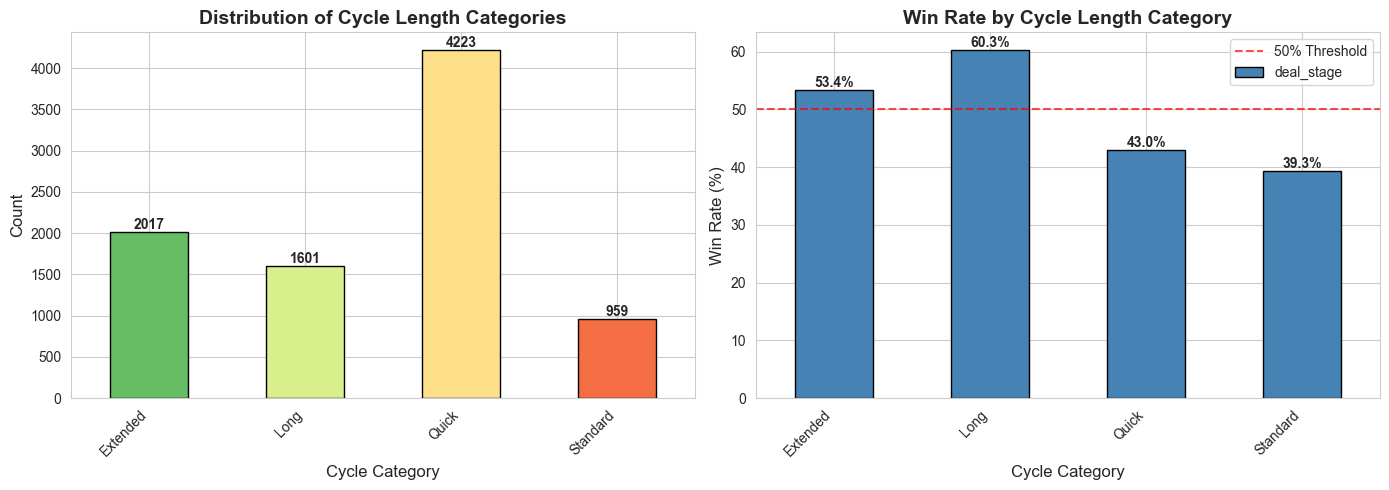


Key Finding:
  - Highest win rate: Long (60.3%)
  - Lowest win rate: Standard (39.3%)

FEATURE CREATED SUCCESSFULLY


In [12]:
# Feature 3: Cycle Length Categories
# Bin sales cycles into categories based on business rules

df['cycle_length_category'] = pd.cut(
    df['sales_cycle_days'],
    bins=[0, 30, 60, 90, 180, float('inf')],
    labels=['Quick', 'Standard', 'Extended', 'Long', 'Very_Long']
).astype('object')

print("Sales Cycle Category Distribution:")
print("="*70)

category_df = pd.DataFrame({
    'Category': df['cycle_length_category'].value_counts().index,
    'Count': df['cycle_length_category'].value_counts().values,
    'Percentage': (df['cycle_length_category'].value_counts(normalize=True) * 100).values.round(2)
})
print(category_df.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
category_counts = df['cycle_length_category'].value_counts().sort_index()
colors = sns.color_palette('RdYlGn_r', len(category_counts))
category_counts.plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Distribution of Cycle Length Categories', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cycle Category', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for i, v in enumerate(category_counts.values):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Win rate by category
win_rate_by_category = df.groupby('cycle_length_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
).sort_index()

win_rate_by_category.plot(kind='bar', ax=ax2, color='steelblue', edgecolor='black')
ax2.set_title('Win Rate by Cycle Length Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cycle Category', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% Threshold')
ax2.legend()

# Add value labels
for i, v in enumerate(win_rate_by_category.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Finding:")
best_category = win_rate_by_category.idxmax()
worst_category = win_rate_by_category.idxmin()
print(f"  - Highest win rate: {best_category} ({win_rate_by_category.max():.1f}%)")
print(f"  - Lowest win rate: {worst_category} ({win_rate_by_category.min():.1f}%)")
print(f"\nFEATURE CREATED SUCCESSFULLY")

#### 5. Date Component Features (Seasonality)

#### Business Context:
In sales, the pattern often is time based like sales are urgently closed before a months end date, friday is usually when a deal closes due to weekly deadline, and companies rush to meet yearly target which means usually Q4 has the most close rate. 

#### Features to Create:
1. **`engage_month`**: Month of initial engagement (1-12)
2. **`engage_quarter`**: Business quarter (Q1-Q4)
3. **`engage_year`**: Year of engagement
4. **`engage_day_of_week`**: Day of week (0=Monday, 6=Sunday)
5. **`engage_week_of_year`**: ISO week number (1-52)

#### Why These Features Matter:
These features capture trend in sales based on seasonality and identifies the best time to engage in prospecting.

In [13]:
# Extract date components from engage_date
print("Temporal Components from Engagement Date")
print("="*70)

df['engage_month'] = df['engage_date'].dt.month
df['engage_quarter'] = df['engage_date'].dt.quarter
df['engage_year'] = df['engage_date'].dt.year
df['engage_day_of_week'] = df['engage_date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['engage_week_of_year'] = df['engage_date'].dt.isocalendar().week

print("Feature created successfully")
print(f"\nNew features created:")
temporal_features = [
    'engage_month', 'engage_quarter', 'engage_year', 'engage_day_of_week',
    'engage_week_of_year'
]
for i, feat in enumerate(temporal_features, 1):
    print(f"  {i}. {feat}")

Temporal Components from Engagement Date
Feature created successfully

New features created:
  1. engage_month
  2. engage_quarter
  3. engage_year
  4. engage_day_of_week
  5. engage_week_of_year


Seasonal Pattern Analysis:


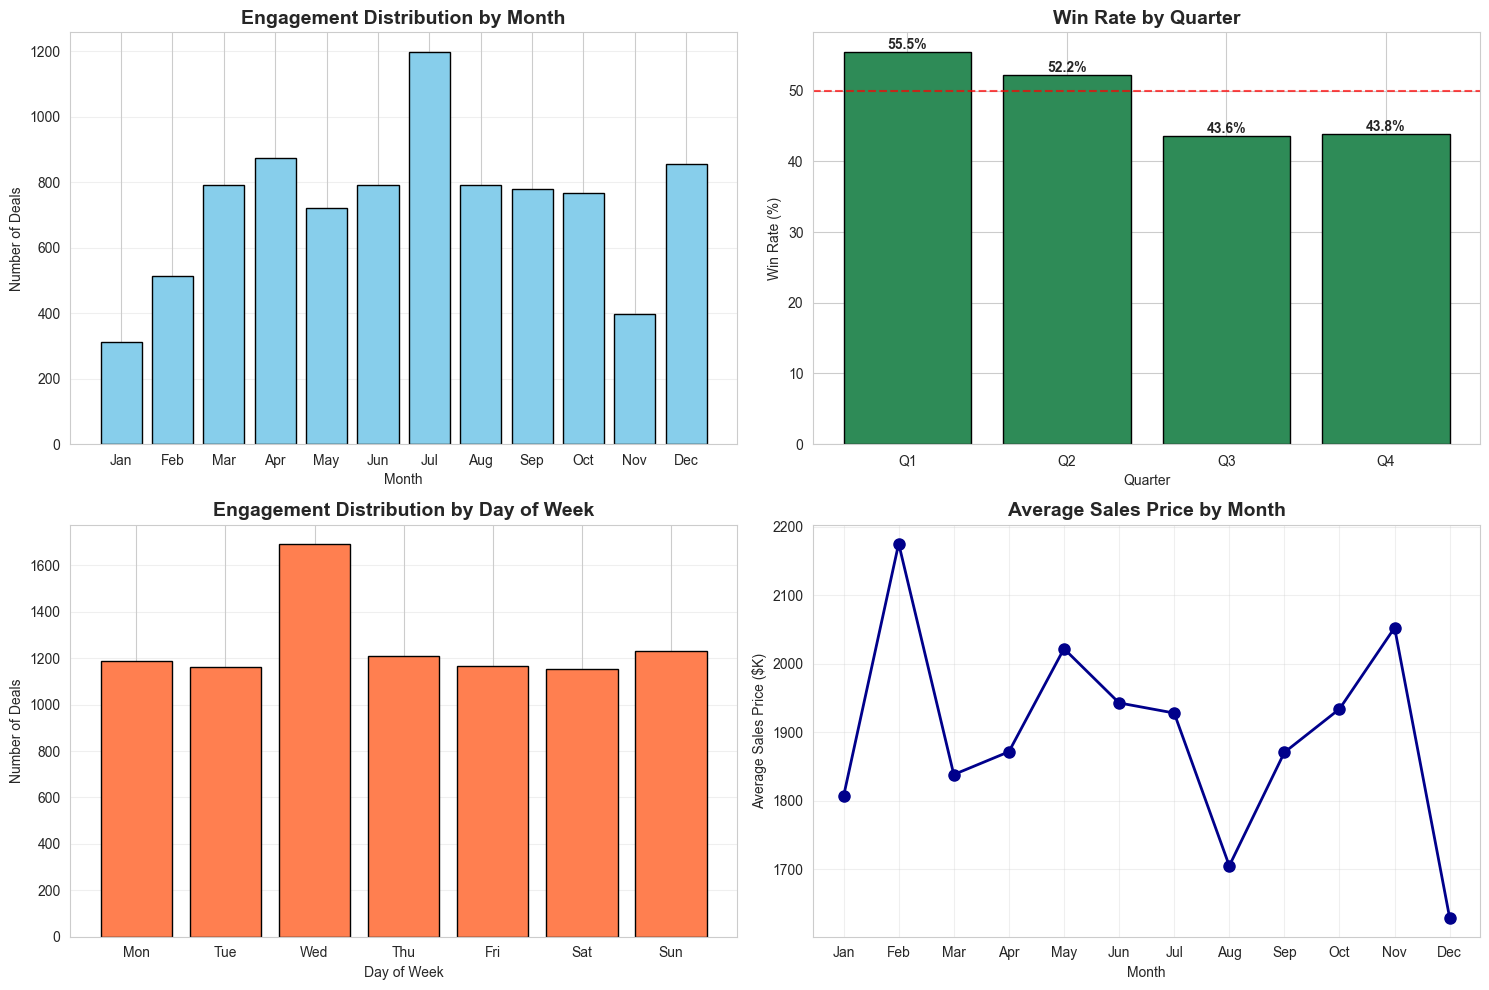


Seasonal Insights:
  - Best quarter for wins: Q1 (55.5% win rate)
  - Busiest engagement month: Jul (1198 deals)
  - Weekend engagements: 27.1% of total


In [14]:
# Analyze seasonal patterns
print("Seasonal Pattern Analysis:")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Deals by Month
month_counts = df['engage_month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].bar(month_names, month_counts.values, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Engagement Distribution by Month', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Deals')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Win Rate by Quarter
quarter_win_rate = df.groupby('engage_quarter')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
axes[0, 1].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarter_win_rate.values, 
               color='seagreen', edgecolor='black')
axes[0, 1].set_title('Win Rate by Quarter', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quarter')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(quarter_win_rate.values):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Deals by Day of Week
dow_counts = df['engage_day_of_week'].value_counts().sort_index()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(dow_names, dow_counts.values, color='coral', edgecolor='black')
axes[1, 0].set_title('Engagement Distribution by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Deals')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Average Sales Price by Month
month_avg_price = df.groupby('engage_month')['sales_price'].mean()
axes[1, 1].plot(month_names, month_avg_price.values, marker='o', 
                linewidth=2, markersize=8, color='darkblue')
axes[1, 1].set_title('Average Sales Price by Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Sales Price ($K)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("\nSeasonal Insights:")
best_quarter = quarter_win_rate.idxmax()
print(f"  - Best quarter for wins: Q{best_quarter} ({quarter_win_rate.max():.1f}% win rate)")

busiest_month = month_counts.idxmax()
print(f"  - Busiest engagement month: {month_names[busiest_month-1]} ({month_counts.max()} deals)")

weekend_deals = dow_counts.loc[5:].sum() if 5 in dow_counts.index or 6 in dow_counts.index else 0
weekend_pct = (weekend_deals / dow_counts.sum()) * 100
print(f"  - Weekend engagements: {weekend_pct:.1f}% of total")

#### Summary of Temporal Features
A total of 8 features were created based on time based properties. The following are the features:

1. **sales_cycle_days** - Calendar days from engagement to deal close
2. **business_days_in_cycle** - Working days only (excludes weekends)
3. **cycle_length_category** - Binned categories (Quick to Very_Long)
4. **engage_month** - Month of engagement (1-12)
5. **engage_quarter** - Business quarter (1-4)
6. **engage_year** - Year of engagement
7. **engage_day_of_week** - Day of week (0-6)
8. **engage_week_of_year** - ISO week number (1-52)

---
---

#### Feature engineering - Part 2: Numerical features (Ratio and transformations)
#### 6. Company Efficiency and Size Ratios

#### Business Context:
Numerical features such as number of employees and revenue needs to be transformed into ratios that can capture meaningful business relationships. A high revenue low employee count indicates high revenue per employee that is a sign of efficiency. The company's age shows maturity and the deal size relative to the company shows how significant the deal is. 

**Important Note on Units:**
- Revenue is in **millions of dollars** (e.g., 718.62 = $718.62M)
- Close_value and sales_price are in **thousands of dollars** (e.g., 1054.0 = $1,054K)
- For ratio calculations, revenue is converted to thousands (multiply by 1000) to match units


#### Features to Create:
1. **`revenue_per_employee`**: Revenue divided by employees for measurement of operational efficiency
2. **`company_age`**: Years since establishment that shows maturity and stability
3. **`sales_price_per_employee`**: Sales price per employee normalizes deal size by company scale
4. **`revenue_to_price_ratio`**: Revenue divided by sales price shows deal significance

#### Justification for the features:
These ratio features normalize raw values by company context. For example a 100K deal is significant for a small company but trivial for a large enterprise. Revenue per employee indicates operational efficiency and profitability. These features help models understand relative magnitude rather than absolute values.

Efficiency Ratio Features

Revenue per Employee Statistics (in thousands $):
count    8800.000000
mean      494.179163
std       173.767298
min       273.103056
25%       378.716925
50%       495.204558
75%       546.990826
max      1181.802575
Name: revenue_per_employee, dtype: float64


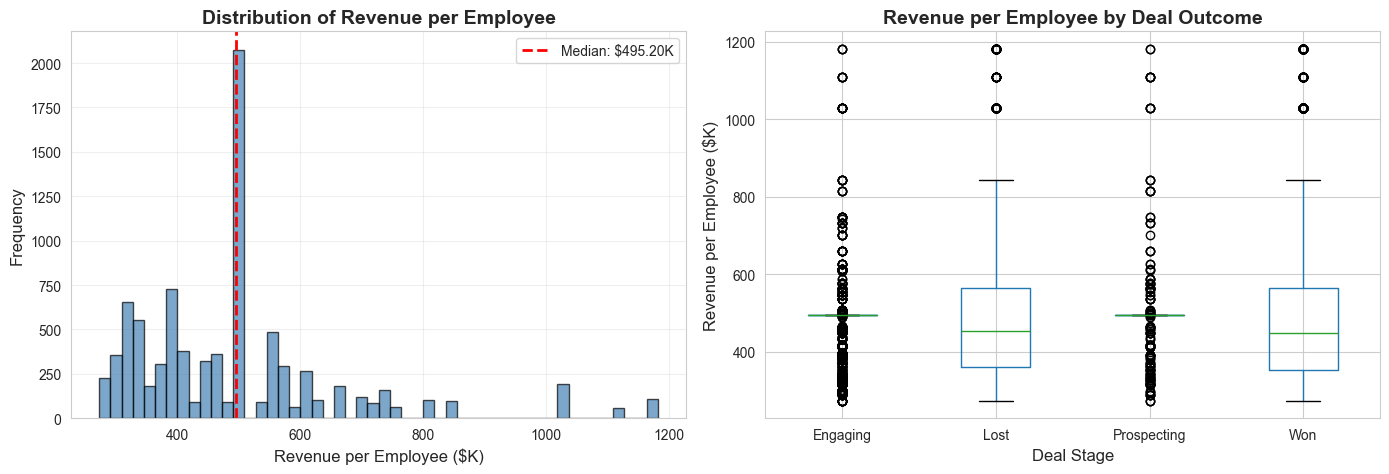


FEATURE CREATED SUCCESSFULLY


In [15]:
# Feature 4: Revenue per Employee
# Measures operational efficiency - higher values indicate more productive workforce
print("Efficiency Ratio Features")
print("="*70)

# Convert revenue from millions to thousands to match other financial metrics
# Revenue is in millions, so multiply by 1000 to get thousands
df['revenue_per_employee'] = (df['revenue'] * 1000) / df['employees']

print("\nRevenue per Employee Statistics (in thousands $):")
print(df['revenue_per_employee'].describe())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax1.hist(df['revenue_per_employee'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['revenue_per_employee'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: ${df["revenue_per_employee"].median():.2f}K')
ax1.set_xlabel('Revenue per Employee ($K)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Revenue per Employee', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by deal stage
df.boxplot(column='revenue_per_employee', by='deal_stage', ax=ax2)
ax2.set_xlabel('Deal Stage', fontsize=12)
ax2.set_ylabel('Revenue per Employee ($K)', fontsize=12)
ax2.set_title('Revenue per Employee by Deal Outcome', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nFEATURE CREATED SUCCESSFULLY")

Company Age Feature

Company Age Statistics (as of 2017):
count    8800.000000
mean       21.270795
std         8.428892
min         0.000000
25%        17.000000
50%        20.000000
75%        27.000000
max        38.000000
Name: company_age, dtype: float64


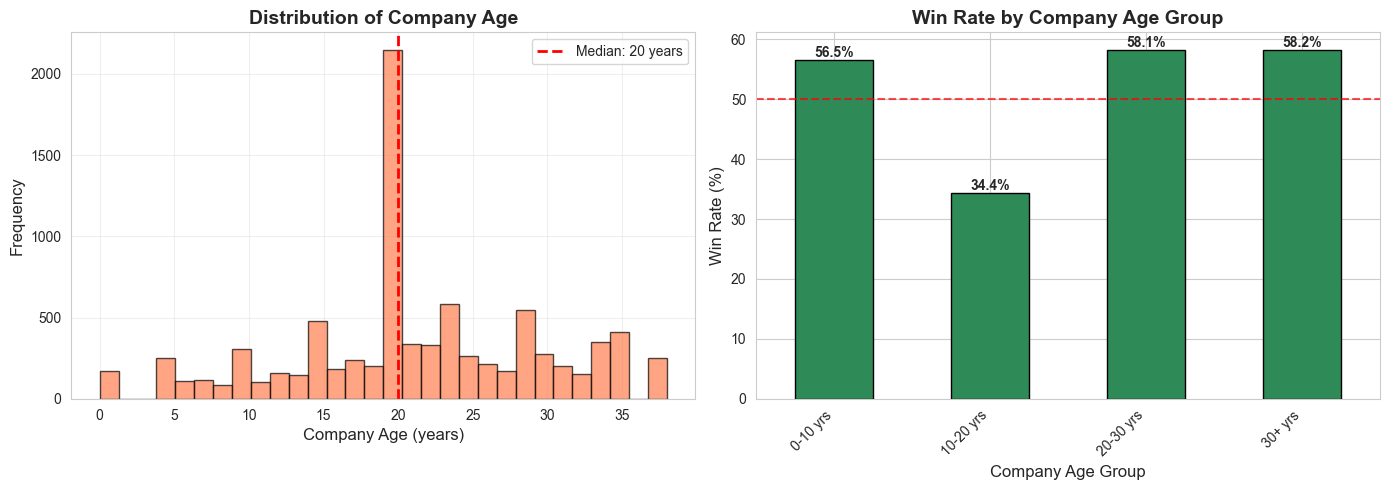


Key Insights:
  - Average company age: 21.3 years
  - Oldest company: 38 years
  - Newest company: 0 years

FEATURE CREATED SUCCESSFULLY


In [16]:
# Feature 5: Company Age
# Calculate years since establishment
print("Company Age Feature")
print("="*70)

# Use engagement year (when prospect was first contacted)
current_year = df['engage_year'].max()
df['company_age'] = current_year - df['year_established']

print(f"\nCompany Age Statistics (as of {current_year}):")
print(df['company_age'].describe())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax1.hist(df['company_age'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax1.axvline(df['company_age'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {df["company_age"].median():.0f} years')
ax1.set_xlabel('Company Age (years)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Company Age', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Win rate by age group
age_bins = [0, 10, 20, 30, 40]
age_labels = ['0-10 yrs', '10-20 yrs', '20-30 yrs', '30+ yrs']
df['age_group_temp'] = pd.cut(df['company_age'], bins=age_bins, labels=age_labels)
win_rate_by_age = df.groupby('age_group_temp')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)

win_rate_by_age.plot(kind='bar', ax=ax2, color='seagreen', edgecolor='black')
ax2.set_title('Win Rate by Company Age Group', fontsize=14, fontweight='bold')
ax2.set_xlabel('Company Age Group', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(win_rate_by_age.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Drop temporary column
df.drop('age_group_temp', axis=1, inplace=True)

print("\nKey Insights:")
print(f"  - Average company age: {df['company_age'].mean():.1f} years")
print(f"  - Oldest company: {df['company_age'].max()} years")
print(f"  - Newest company: {df['company_age'].min()} years")

print("\nFEATURE CREATED SUCCESSFULLY")

Creating Deal Context Ratio Features

Deal Context Ratios Statistics:
       sales_price_per_employee  revenue_to_price_ratio
count               7320.000000             7320.000000
mean                   4.734241            15215.055930
std                   38.457585            35272.692803
min                    0.001604                0.828165
25%                    0.046365              594.218182
50%                    0.205649             2300.027372
75%                    0.803425             9379.472727
max                  609.111111           212691.454545

Note: Using sales_price (quoted price) instead of close_value (actual outcome)
Note: Revenue converted from millions to thousands for ratio calculations
Note: Replaced infinite values with NaN (from divide by zero)


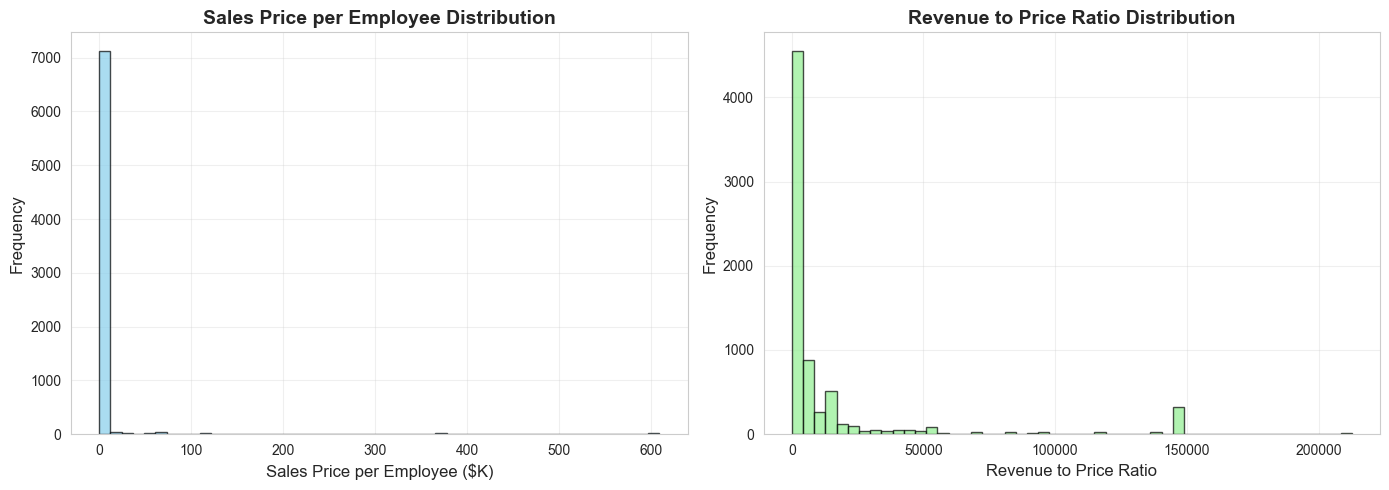


Key Insights:
  - Average sales price per employee: $4.73K
  - Average revenue to price ratio: 15215.06x

2 FEATURES CREATED SUCCESSFULLY


In [17]:
# Features 6-7: Deal Context Ratios 
# These features normalize deal size by company characteristics
print("Creating Deal Context Ratio Features")
print("="*70)

# Feature 6: Sales price per employee - normalizes deal size by company size
# sales_price is the quoted/expected price (set before deal outcome)
df['sales_price_per_employee'] = df['sales_price'] / df['employees']

# Feature 7: Revenue to price ratio - shows deal significance relative to company revenue
# Convert revenue from millions to thousands to match sales_price units
df['revenue_to_price_ratio'] = (df['revenue'] * 1000) / df['sales_price']
df['revenue_to_price_ratio'] = df['revenue_to_price_ratio'].replace([np.inf, -np.inf], np.nan)

print("\nDeal Context Ratios Statistics:")
print("="*70)
ratio_features = ['sales_price_per_employee', 'revenue_to_price_ratio']
print(df[ratio_features].describe())

print(f"\nNote: Using sales_price (quoted price) instead of close_value (actual outcome)")
print(f"Note: Revenue converted from millions to thousands for ratio calculations")
print(f"Note: Replaced infinite values with NaN (from divide by zero)")

# Visualize the two ratios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sales price per employee
axes[0].hist(df['sales_price_per_employee'].dropna(), bins=50, edgecolor='black', 
             alpha=0.7, color='skyblue')
axes[0].set_xlabel('Sales Price per Employee ($K)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Sales Price per Employee Distribution', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Revenue to price ratio
axes[1].hist(df['revenue_to_price_ratio'].dropna(), bins=50, edgecolor='black', 
             alpha=0.7, color='lightgreen')
axes[1].set_xlabel('Revenue to Price Ratio', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Revenue to Price Ratio Distribution', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - Average sales price per employee: ${df['sales_price_per_employee'].mean():.2f}K")
print(f"  - Average revenue to price ratio: {df['revenue_to_price_ratio'].mean():.2f}x")

print("\n2 FEATURES CREATED SUCCESSFULLY")

#### 7. Log Transformations for Skewed Distributions

#### Business Context:
Many numerical features in business data follow right-skewed distributions where most values are small but a few are very large. Revenue, employees, and sales_price often have this pattern. Log transformation compresses large values and spreads small values, making distributions more normal and reducing the impact of outliers.

#### Features to Create:
1. **`log_revenue`**: Log of revenue - handles right-skewed revenue distribution
2. **`log_employees`**: Log of employee count - normalizes company size
3. **`log_sales_price`**: Log of sales price - reduces impact of mega-deals
4. **`log_sales_cycle_days`**: Log of sales cycle - normalizes time distribution

#### Justification for the features:
Log transformations improve model performance by making distributions more Gaussian and reducing the influence of extreme outliers. Many ML algorithms assume normally distributed features. Using log1p ensures we handle zero values correctly.

Creating Log Transformed Features

Log Transformed Features Statistics:
       log_revenue  log_employees  log_sales_price  log_sales_cycle_days
count  8800.000000    8800.000000      7320.000000           8800.000000
mean      7.423476       8.176806         6.601906              3.207524
std       1.526315       1.558308         1.613352              1.309094
min       1.711995       2.302585         4.025352              0.693147
25%       6.578723       7.370860         6.311735              2.197225
50%       7.684775       8.420903         7.000334              3.663562
75%       8.757134       9.533148         8.129764              4.418841
max       9.367261      10.442580        10.195000              4.934474


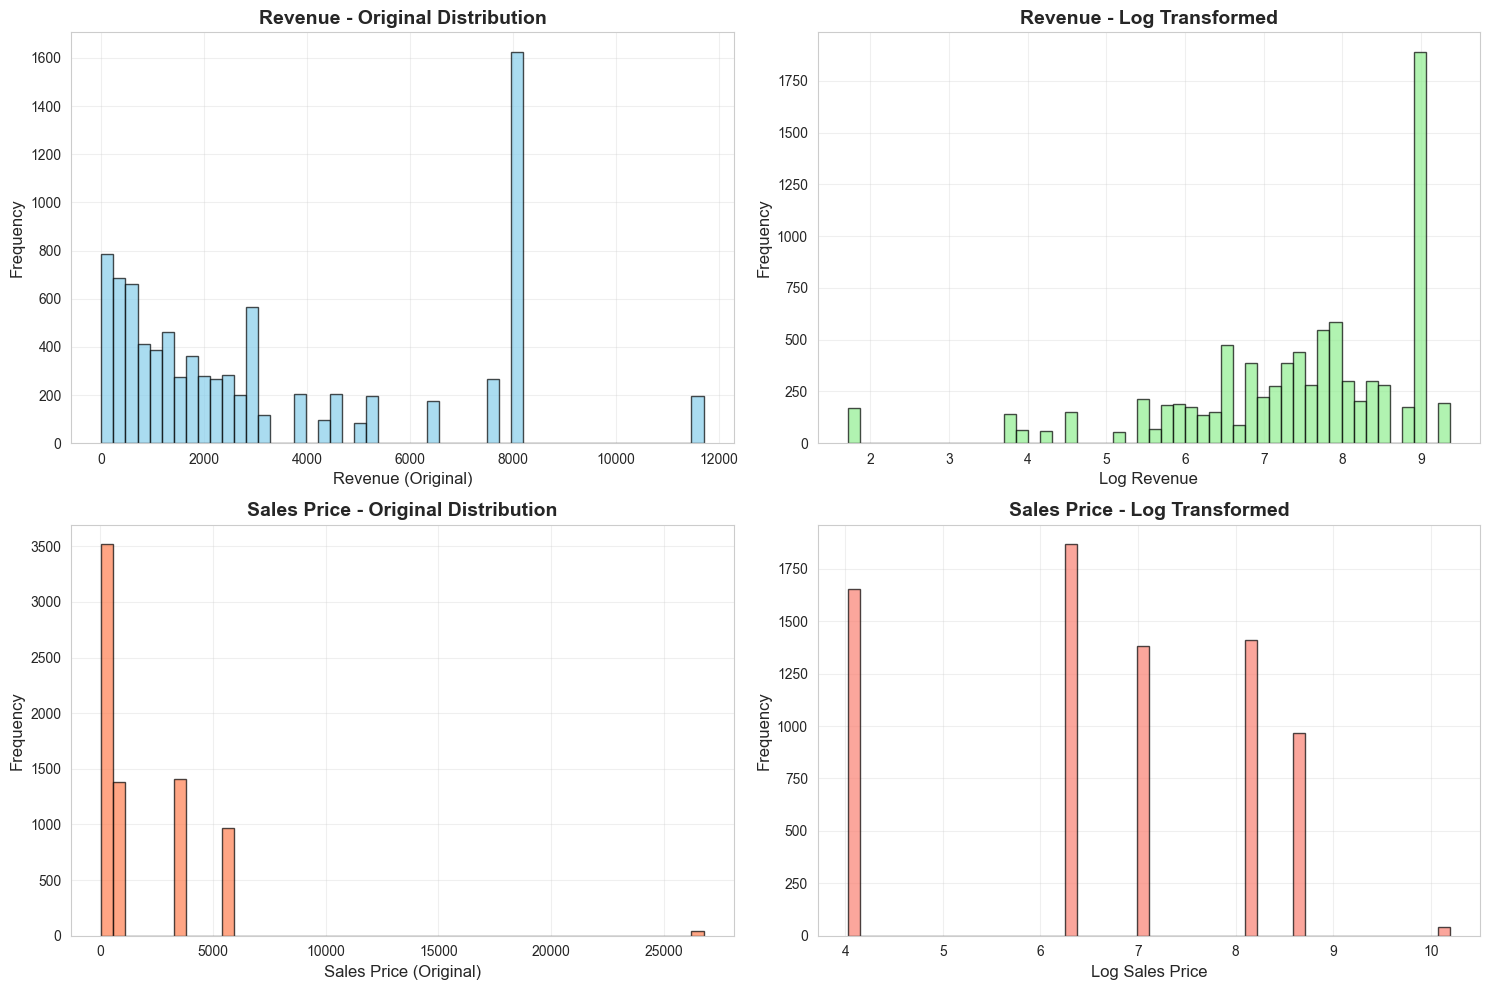


Key Insights:
  - Log transformation reduces skewness in distributions
  - Original revenue: highly right-skewed
  - Log revenue: more normal distribution
  - This helps tree-based and linear models perform better

4 FEATURES CREATED SUCCESSFULLY


In [18]:
# Features 8-11: Log Transformations 
# Apply log1p (log(1+x)) to handle zero values
print("Creating Log Transformed Features")
print("="*70)

# Log transformations using log1p to handle zeros
df['log_revenue'] = np.log1p(df['revenue'])
df['log_employees'] = np.log1p(df['employees'])
df['log_sales_price'] = np.log1p(df['sales_price'])  
df['log_sales_cycle_days'] = np.log1p(df['sales_cycle_days'])

print("\nLog Transformed Features Statistics:")
print("="*70)
log_features = ['log_revenue', 'log_employees', 'log_sales_price', 'log_sales_cycle_days']
print(df[log_features].describe())

# Visualize before and after transformation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Revenue: Original vs Log
axes[0, 0].hist(df['revenue'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Revenue (Original)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Revenue - Original Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(df['log_revenue'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Log Revenue', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Revenue - Log Transformed', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Sales Price: Original vs Log
axes[1, 0].hist(df['sales_price'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_xlabel('Sales Price (Original)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Sales Price - Original Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(df['log_sales_price'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[1, 1].set_xlabel('Log Sales Price', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Sales Price - Log Transformed', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Log transformation reduces skewness in distributions")
print("  - Original revenue: highly right-skewed")
print("  - Log revenue: more normal distribution")
print("  - This helps tree-based and linear models perform better")

print("\n4 FEATURES CREATED SUCCESSFULLY")

#### 8. Binning and Categorization

#### Business Context:
Continuous numerical features can be binned into categories to capture non-linear relationships and business thresholds. Companies are often segmented as Small/Medium/Large/Enterprise based on revenue and employee count. This discretization helps models identify patterns specific to each segment.

#### Features to Create:
1. **`revenue_category`**: Small/Medium/Large/Enterprise based on revenue quartiles
2. **`employee_size_category`**: Startup/SMB/Mid-Market/Enterprise based on employee count
3. **`sales_price_category`**: Budget/Standard/Premium/Enterprise based on sales_price quartiles


#### Justification for the features:
Binning creates categorical features that capture business segments. A linear relationship may not exist across the entire range, but patterns within segments may be strong. For example, sales strategies differ for small vs enterprise customers.

Creating Binned Category Features

Category Distributions:

Revenue Category:
revenue_category
Enterprise    2156
Large         2238
Medium        2171
Small         2235
Name: count, dtype: int64

Employee Size Category:
employee_size_category
Enterprise    2164
Mid-Market    2197
SMB           2159
Startup       2280
Name: count, dtype: int64

Sales Price Category:
sales_price_category
Budget        3517
Enterprise    1008
Premium       1412
Standard      1383
Name: count, dtype: int64


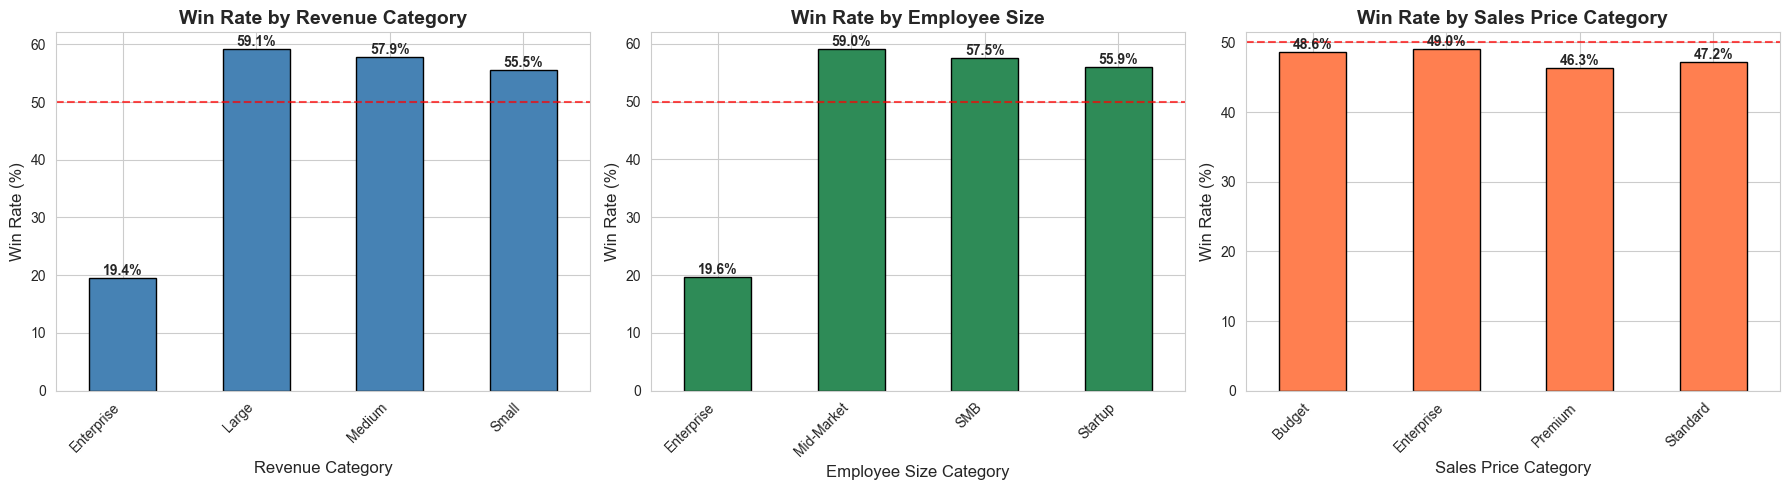


Key Insights:
  - Best revenue segment: Large (59.1% win rate)
  - Best employee segment: Mid-Market (59.0% win rate)
  - Best sales price segment: Enterprise (49.0% win rate)

3 FEATURES CREATED SUCCESSFULLY


In [19]:
# Features 12-14: Binning and Categorization
# Create categorical segments based on numerical thresholds
print("Creating Binned Category Features")
print("="*70)

# Feature 12: Revenue categories based on quartiles
revenue_quartiles = df['revenue'].quantile([0.25, 0.50, 0.75]).values
df['revenue_category'] = pd.cut(
    df['revenue'],
    bins=[0, revenue_quartiles[0], revenue_quartiles[1], revenue_quartiles[2], float('inf')],
    labels=['Small', 'Medium', 'Large', 'Enterprise']
).astype('object')

# Feature 13: Employee size categories
employee_quartiles = df['employees'].quantile([0.25, 0.50, 0.75]).values
df['employee_size_category'] = pd.cut(
    df['employees'],
    bins=[0, employee_quartiles[0], employee_quartiles[1], employee_quartiles[2], float('inf')],
    labels=['Startup', 'SMB', 'Mid-Market', 'Enterprise']
).astype('object')

# Feature 14: Sales price categories 
# Filter out NaN values for quartile calculation
sales_price_quartiles = df['sales_price'].dropna().quantile([0.25, 0.50, 0.75]).values
df['sales_price_category'] = pd.cut(
    df['sales_price'],
    bins=[0, sales_price_quartiles[0], sales_price_quartiles[1], sales_price_quartiles[2], float('inf')],
    labels=['Budget', 'Standard', 'Premium', 'Enterprise']
).astype('object')

print("\nCategory Distributions:")
print("="*70)
print("\nRevenue Category:")
print(df['revenue_category'].value_counts().sort_index())

print("\nEmployee Size Category:")
print(df['employee_size_category'].value_counts().sort_index())

print("\nSales Price Category:")
print(df['sales_price_category'].value_counts().sort_index())

# Visualize win rates by categories
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Win rate by revenue category
win_rate_revenue = df.groupby('revenue_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_revenue.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Win Rate by Revenue Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Revenue Category', fontsize=12)
axes[0].set_ylabel('Win Rate (%)', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_revenue.values):
    axes[0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Win rate by employee size
win_rate_employees = df.groupby('employee_size_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_employees.plot(kind='bar', ax=axes[1], color='seagreen', edgecolor='black')
axes[1].set_title('Win Rate by Employee Size', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Employee Size Category', fontsize=12)
axes[1].set_ylabel('Win Rate (%)', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_employees.values):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Win rate by sales price
win_rate_price = df.groupby('sales_price_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_price.plot(kind='bar', ax=axes[2], color='coral', edgecolor='black')
axes[2].set_title('Win Rate by Sales Price Category', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Sales Price Category', fontsize=12)
axes[2].set_ylabel('Win Rate (%)', fontsize=12)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_price.values):
    axes[2].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - Best revenue segment: {win_rate_revenue.idxmax()} ({win_rate_revenue.max():.1f}% win rate)")
print(f"  - Best employee segment: {win_rate_employees.idxmax()} ({win_rate_employees.max():.1f}% win rate)")
print(f"  - Best sales price segment: {win_rate_price.idxmax()} ({win_rate_price.max():.1f}% win rate)")

print("\n3 FEATURES CREATED SUCCESSFULLY")

#### 9. Polynomial Features for Non-Linear Relationships

#### Business Context:
Some relationships in business are non-linear. For example, very long sales cycles may have an exponentially lower win rates rather than linearly lower. Polynomial features capture these non-linear patterns by creating squared or interaction terms.

#### Features to Create:
1. **`revenue_squared`**: Revenue squared captures quadratic relationship
2. **`employees_squared`**: Employees squared non-linear company size effects
3. **`sales_cycle_squared`**: Sales cycle squared diminishing returns over time

#### Justification for the features:
Polynomial features allow linear models to capture non-linear relationships. While tree-based models handle non-linearity naturally, linear models and neural networks benefit from explicit polynomial terms. This is especially useful for relationships with accelerating or decelerating effects.

Polynomial Features

Polynomial Features Statistics:
       revenue_squared  employees_squared  sales_cycle_squared
count     8.800000e+03       8.800000e+03          8800.000000
mean      1.575533e-01       9.378371e-02             0.194625
std       2.268239e-01       1.680701e-01             0.233130
min       1.506212e-07       6.889706e-08             0.000053
25%       3.773750e-03       2.144948e-03             0.003361
50%       3.453708e-02       1.753184e-02             0.075824
75%       2.951127e-01       1.621960e-01             0.353077
max       1.000000e+00       1.000000e+00             1.000000


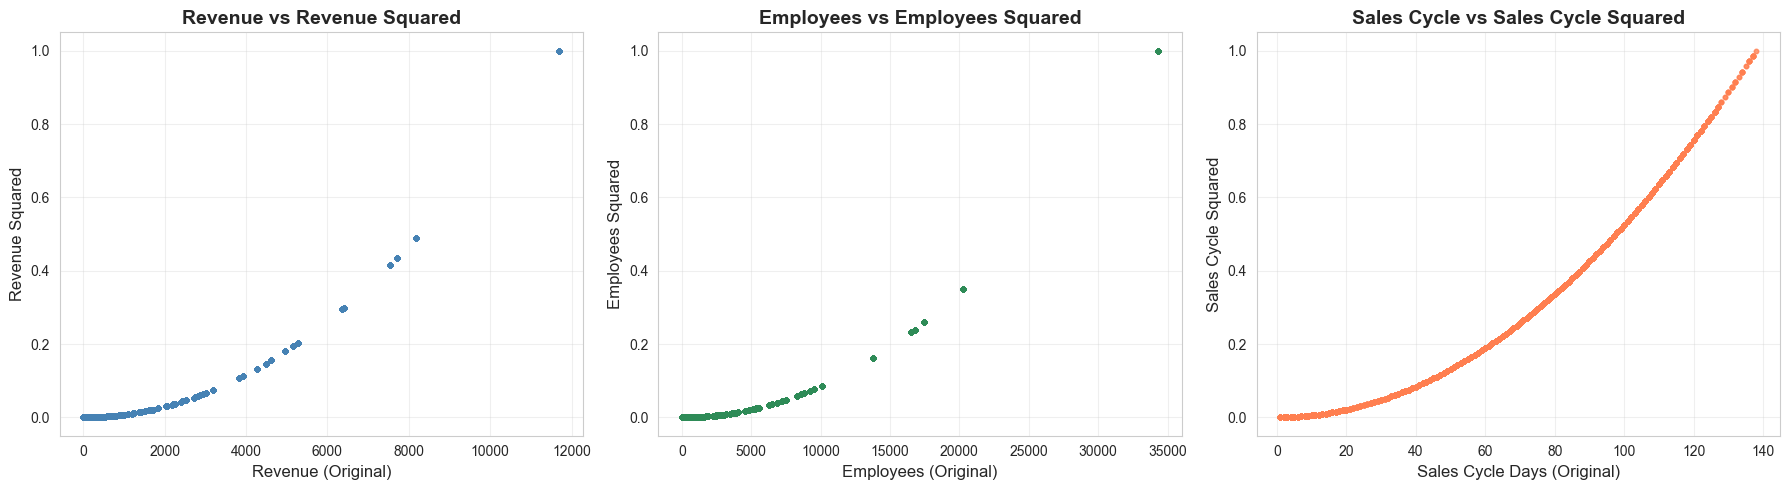


Key Insights:
  - Polynomial features capture non-linear patterns
  - Squared terms amplify differences between small and large values
  - Normalized before squaring to prevent numerical overflow

3 FEATURES CREATED SUCCESSFULLY


In [20]:
# Features 16-18: Polynomial Features
# Create squared terms to capture non-linear relationships
print("Polynomial Features")
print("="*70)

# Normalize values before squaring to prevent extremely large numbers
df['revenue_normalized'] = df['revenue'] / df['revenue'].max()
df['employees_normalized'] = df['employees'] / df['employees'].max()
df['sales_cycle_normalized'] = df['sales_cycle_days'] / df['sales_cycle_days'].max()

# Create squared features
df['revenue_squared'] = df['revenue_normalized'] ** 2
df['employees_squared'] = df['employees_normalized'] ** 2
df['sales_cycle_squared'] = df['sales_cycle_normalized'] ** 2

# Drop temporary normalized columns
df.drop(['revenue_normalized', 'employees_normalized', 'sales_cycle_normalized'], 
        axis=1, inplace=True)

print("\nPolynomial Features Statistics:")
print("="*70)
poly_features = ['revenue_squared', 'employees_squared', 'sales_cycle_squared']
print(df[poly_features].describe())

# Visualize relationship between original and squared features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Revenue vs Revenue Squared
axes[0].scatter(df['revenue'], df['revenue_squared'], alpha=0.5, s=10, color='steelblue')
axes[0].set_xlabel('Revenue (Original)', fontsize=12)
axes[0].set_ylabel('Revenue Squared', fontsize=12)
axes[0].set_title('Revenue vs Revenue Squared', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Employees vs Employees Squared
axes[1].scatter(df['employees'], df['employees_squared'], alpha=0.5, s=10, color='seagreen')
axes[1].set_xlabel('Employees (Original)', fontsize=12)
axes[1].set_ylabel('Employees Squared', fontsize=12)
axes[1].set_title('Employees vs Employees Squared', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Sales Cycle vs Sales Cycle Squared
axes[2].scatter(df['sales_cycle_days'], df['sales_cycle_squared'], alpha=0.5, s=10, color='coral')
axes[2].set_xlabel('Sales Cycle Days (Original)', fontsize=12)
axes[2].set_ylabel('Sales Cycle Squared', fontsize=12)
axes[2].set_title('Sales Cycle vs Sales Cycle Squared', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Polynomial features capture non-linear patterns")
print("  - Squared terms amplify differences between small and large values")
print("  - Normalized before squaring to prevent numerical overflow")

print("\n3 FEATURES CREATED SUCCESSFULLY")

#### Summary of Numerical Features

A total of 14 numerical features were created through ratios, transformations, binning, and polynomial terms. 


**Ratio Features (4 features):**
1. **revenue_per_employee** - Operational efficiency measure
2. **company_age** - Years since establishment
3. **sales_price_per_employee** - Deal size normalized by company scale 
4. **revenue_to_price_ratio** - Deal significance relative to revenue 

**Log Transformations (4 features):**

5. **log_revenue** - Log transformed revenue
6. **log_employees** - Log transformed employee count
7. **log_sales_price** - Log transformed sales price
8. **log_sales_cycle_days** - Log transformed sales cycle

**Binned Categories (3 features):**

9. **revenue_category** - Small/Medium/Large/Enterprise
10. **employee_size_category** - Startup/SMB/Mid-Market/Enterprise
11. **sales_price_category** - Budget/Standard/Premium/Enterprise 

**Polynomial Features (3 features):**

12. **revenue_squared** - Revenue squared term
13. **employees_squared** - Employees squared term
14. **sales_cycle_squared** - Sales cycle squared term

**Total Numerical Features: 14**


---
---

#### Feature engineering - Part 3: Categorical Encoding
#### 10. Categorical Features Overview 

#### Business Context:
Categorical features like product type, sector, sales agent need to be converted into numerical format for machine learning models. Different encoding strategies work better for different cardinality levels.

**Note**:
**Target Encoding is NOT used in this section** because it would cause data leakage:
- Target encoding uses the target variable (deal_stage) to encode categories
- If calculated on full dataset before train-test split, information leaks from test set to training
- This artificially inflates model performance

**Safe Encoding Methods Used:**
1. **One-Hot Encoding** - No leakage, creates binary columns for each category
2. **Frequency Encoding** - No leakage, counts category occurrences (no target info)
3. **Binary Features** - No leakage, simple 0/1 indicators

**Categorical Features to Encode:**
- Low cardinality (One-Hot): product (7), sector (10), series (3), manager (6), regional_office (3)
- Medium/High cardinality (Frequency): sales_agent (30), account (85), office_location (15)
- Binary: subsidiary_of (has parent company or not)

**Note**: Target encoding could be added AFTER train-test split in Part 7 using proper cross-validation.

In [21]:
# One-Hot Encoding for low cardinality categorical features
print("One-Hot Encoding")
print("="*70)

# Features to one-hot encode
onehot_features = ['product', 'sector', 'series', 'manager', 'regional_office']

print("\nBefore One-Hot Encoding:")
print(f"Dataset shape: {df.shape}")

# Create a copy of original categorical columns before encoding
# These will be used later for interaction features
original_categoricals = {}
for col in onehot_features:
    original_categoricals[col] = df[col].copy()

# Apply one-hot encoding with drop_first=True to avoid multicollinearity
# prefix_sep='_' creates column names like 'product_GTXPro'
df_encoded = pd.get_dummies(df, columns=onehot_features, drop_first=True, dtype='int64', prefix_sep='_')

# Restore original categorical columns (for interaction features later)
for col, values in original_categoricals.items():
    df_encoded[col] = values

print(f"\nAfter One-Hot Encoding:")
print(f"Dataset shape: {df_encoded.shape}")
print(f"New one-hot columns added: {df_encoded.shape[1] - df.shape[1]}")

# Update df to encoded version
df = df_encoded.copy()

# Show example of created columns
print("\nExample One-Hot Encoded Columns:")
print("="*70)
onehot_cols = [col for col in df.columns if any(feat + '_' in col for feat in onehot_features)]
print(f"Total one-hot encoded columns: {len(onehot_cols)}")
print("\nFirst 10 one-hot columns:")
for i, col in enumerate(onehot_cols[:10], 1):
    print(f"  {i}. {col}")

print("\nNote: Original categorical columns preserved for interaction features")
print("\nFEATURES CREATED SUCCESSFULLY")

One-Hot Encoding

Before One-Hot Encoding:
Dataset shape: (8800, 40)

After One-Hot Encoding:
Dataset shape: (8800, 64)
New one-hot columns added: 24

Example One-Hot Encoded Columns:
Total one-hot encoded columns: 24

First 10 one-hot columns:
  1. product_GTX Basic
  2. product_GTX Plus Basic
  3. product_GTX Plus Pro
  4. product_GTXPro
  5. product_MG Advanced
  6. product_MG Special
  7. sector_entertainment
  8. sector_finance
  9. sector_marketing
  10. sector_medical

Note: Original categorical columns preserved for interaction features

FEATURES CREATED SUCCESSFULLY


#### 12. Frequency Encoding for Medium/High Cardinality Features

#### Business Context:
Frequency encoding replaces each category with the count of how many times it appears in the dataset. This works well for high cardinality features where one-hot encoding would create too many columns. The frequency indicates popularity or commonness of that category.

#### Features to Frequency Encode:
1. **sales_agent** (30 agents) - How many deals each agent has
2. **account** (85 accounts) - How many deals per account (repeat customers)
3. **office_location** (15 locations) - Geographic presence


Frequency Encoding

Creating Frequency Encoded Features:

sales_agent:
  Unique categories: 30
  Frequency range: 110 to 747
  Mean frequency: 343.4
  Created feature: sales_agent_frequency

account:
  Unique categories: 85
  Frequency range: 51 to 1625
  Mean frequency: 376.4
  Created feature: account_frequency

office_location:
  Unique categories: 15
  Frequency range: 52 to 6120
  Mean frequency: 4566.5
  Created feature: office_location_frequency


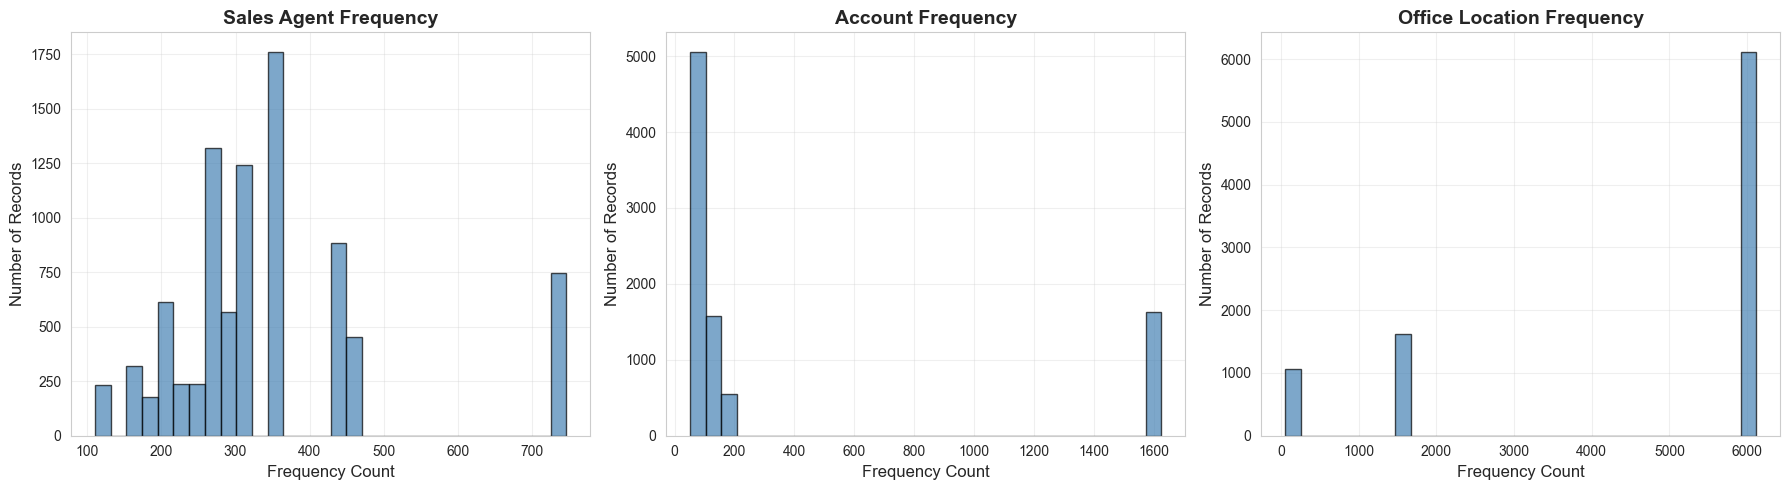


3 FREQUENCY ENCODED FEATURES CREATED SUCCESSFULLY


In [22]:
# Frequency Encoding for medium/high cardinality features
print("Frequency Encoding")
print("="*70)

# Features to frequency encode
frequency_features = ['sales_agent', 'account', 'office_location']

print("\nCreating Frequency Encoded Features:")
print("="*70)

for feature in frequency_features:
    # Calculate frequency (count of each category)
    frequency_map = df[feature].value_counts().to_dict()
    
    # Create new feature with frequency encoding
    new_feature_name = f"{feature}_frequency"
    df[new_feature_name] = df[feature].map(frequency_map)
    
    print(f"\n{feature}:")
    print(f"  Unique categories: {df[feature].nunique()}")
    print(f"  Frequency range: {df[new_feature_name].min()} to {df[new_feature_name].max()}")
    print(f"  Mean frequency: {df[new_feature_name].mean():.1f}")
    print(f"  Created feature: {new_feature_name}")

# Visualize frequency distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(frequency_features):
    freq_col = f"{feature}_frequency"
    axes[idx].hist(df[freq_col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_xlabel('Frequency Count', fontsize=12)
    axes[idx].set_ylabel('Number of Records', fontsize=12)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} Frequency', fontsize=14, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f"3 FREQUENCY ENCODED FEATURES CREATED SUCCESSFULLY")
print("="*70)

#### 13. Binary Encoding for Special Categorical Features

#### Business Context:
Some categorical features have a natural binary representation. For subsidiary_of, we care whether a company has a parent organization or is independent. This binary indicator is more meaningful than encoding 8 different parent company names.

#### Feature to Binary Encode:
1. **has_parent_company** - Derived from subsidiary_of (1 = has parent, 0 = independent)


Binary Encoding

subsidiary_of unique values:
subsidiary_of
Independent         7508
Acme Corporation     322
Sonron               283
Bubba Gump           177
Inity                176
Golddex              175
Massive Dynamic       98
Warephase             61
Name: count, dtype: int64

Binary Feature Created:
has_parent_company:
has_parent_company
0    7508
1    1292
Name: count, dtype: int64

Percentage with parent company: 14.7%


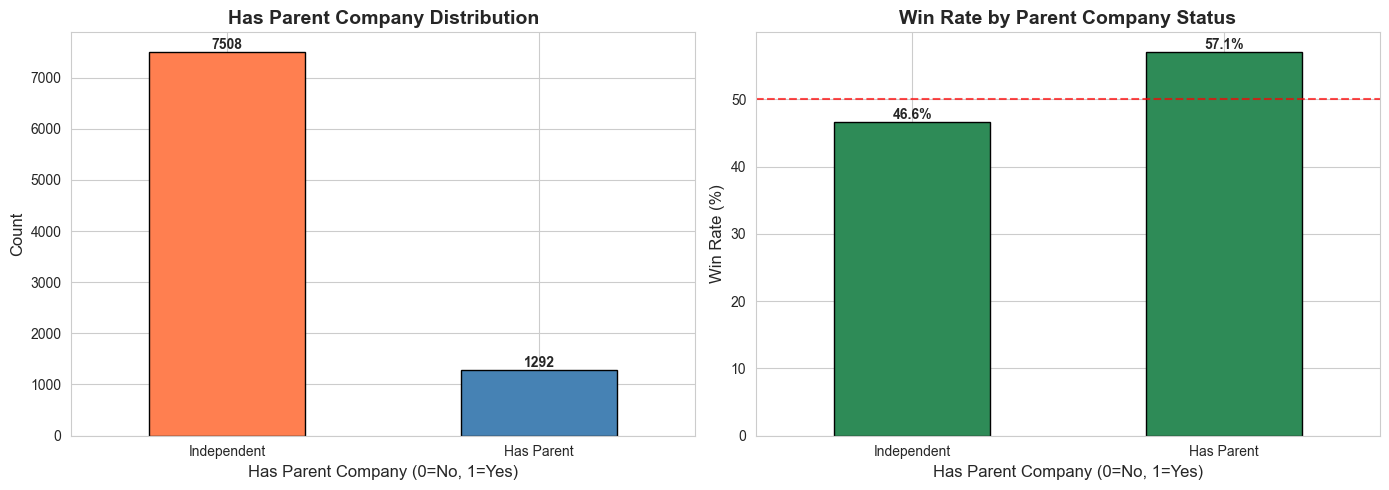


1 BINARY FEATURE CREATED SUCCESSFULLY


In [23]:
# Binary Encoding for subsidiary_of
print("Binary Encoding")
print("="*70)

# Check unique values in subsidiary_of
print("\nsubsidiary_of unique values:")
print(df['subsidiary_of'].value_counts())

# Create binary feature: 1 if has parent company, 0 if independent
df['has_parent_company'] = (df['subsidiary_of'] != 'Independent').astype(int)

print("\nBinary Feature Created:")
print("="*70)
print(f"has_parent_company:")
print(df['has_parent_company'].value_counts())
print(f"\nPercentage with parent company: {(df['has_parent_company'].mean() * 100):.1f}%")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
df['has_parent_company'].value_counts().plot(kind='bar', ax=ax1, color=['coral', 'steelblue'], edgecolor='black')
ax1.set_title('Has Parent Company Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Has Parent Company (0=No, 1=Yes)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(['Independent', 'Has Parent'], rotation=0)
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height(),
             f'{int(p.get_height())}', ha='center', va='bottom', fontweight='bold')

# Win rate by parent company status
win_rate = df.groupby('has_parent_company')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate.plot(kind='bar', ax=ax2, color='seagreen', edgecolor='black')
ax2.set_title('Win Rate by Parent Company Status', fontsize=14, fontweight='bold')
ax2.set_xlabel('Has Parent Company (0=No, 1=Yes)', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_xticklabels(['Independent', 'Has Parent'], rotation=0)
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("1 BINARY FEATURE CREATED SUCCESSFULLY")
print("="*70)

#### Summary of Categorical Encoding Features

A total of 28 categorical features were created through safe encoding methods that prevent data leakage.

**One-Hot Encoded Features (~24 features):**
- product_* (6 features after drop_first)
- sector_* (9 features after drop_first)
- series_* (2 features after drop_first)
- manager_* (5 features after drop_first)
- regional_office_* (2 features after drop_first)

**Frequency Encoded Features (3 features):**
1. **sales_agent_frequency** - Number of deals per sales agent
2. **account_frequency** - Number of deals per account (repeat customer indicator)
3. **office_location_frequency** - Number of deals per office location

**Binary Encoded Features (1 feature):**
1. **has_parent_company** - 1 if subsidiary, 0 if independent

**Total Categorical Features: ~28**

---
---

#### Feature engineering - Part 4: Interaction Features
#### 14. Categorical × Categorical Interactions

#### Business Context:
Interaction features capture relationships between multiple variables that may have combined effects. For example, the combination of product type and industry sector might reveal patterns that neither feature shows independently. A GTXPro product might perform differently in the finance sector versus the retail sector.

#### Features to Create:
1. **`product_sector`**: Combined product and sector (e.g., 'GTXPro_finance')
2. **`agent_product`**: Sales agent and product combination
3. **`sector_office`**: Sector and office location combination
4. **`product_series_combined`**: Product series with regional office

#### Justification:
Interactions reveal conditional relationships. A sales agent may excel with certain products but struggle with others. Geographic location combined with industry sector shows regional industry strengths. These combinations create high-dimensional features that tree-based models can leverage effectively.

In [24]:
# Categorical × Categorical Interaction Features
print("Categorical Interaction Features")
print("="*70)

# Feature 1: Product × Sector interaction
df['product_sector'] = df['product'] + '_' + df['sector']

# Feature 2: Sales Agent × Product interaction
df['agent_product'] = df['sales_agent'] + '_' + df['product']

# Feature 3: Sector × Office Location interaction
df['sector_office'] = df['sector'] + '_' + df['office_location']

# Feature 4: Regional Office × Product interaction
# Note: using original regional_office column, not one-hot encoded versions
df['region_product'] = df['regional_office'] + '_' + df['product']

print("\nCategorical Interaction Features Created:")
print("="*70)
print(f"1. product_sector: {df['product_sector'].nunique()} unique combinations")
print(f"   Example: {df['product_sector'].iloc[0]}")
print(f"\n2. agent_product: {df['agent_product'].nunique()} unique combinations")
print(f"   Example: {df['agent_product'].iloc[0]}")
print(f"\n3. sector_office: {df['sector_office'].nunique()} unique combinations")
print(f"   Example: {df['sector_office'].iloc[0]}")
print(f"\n4. region_product: {df['region_product'].nunique()} unique combinations")
print(f"   Example: {df['region_product'].iloc[0]}")

# Show top combinations
print("\nMost Common Product-Sector Combinations:")
print("="*70)
print(df['product_sector'].value_counts().head(10))

print("\n" + "="*70)
print("4 CATEGORICAL INTERACTION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Categorical Interaction Features

Categorical Interaction Features Created:
1. product_sector: 70 unique combinations
   Example: GTX Plus Basic_retail

2. agent_product: 179 unique combinations
   Example: Moses Frase_GTX Plus Basic

3. sector_office: 24 unique combinations
   Example: retail_United States

4. region_product: 21 unique combinations
   Example: Central_GTX Plus Basic

Most Common Product-Sector Combinations:
product_sector
GTX Basic_technolgy         582
MG Special_technolgy        488
GTXPro_technolgy            422
MG Advanced_technolgy       413
GTX Plus Basic_technolgy    406
GTX Basic_retail            288
GTX Plus Pro_technolgy      268
MG Special_retail           258
GTXPro_retail               235
GTX Plus Basic_retail       228
Name: count, dtype: int64

4 CATEGORICAL INTERACTION FEATURES CREATED SUCCESSFULLY


#### 15. Numerical × Numerical Interactions

#### Business Context:
Multiplying or combining numerical features can reveal compound effects. For example, a revenue multiplied by sales cycle shows the cost of opportunity and the time spent on a deal. High revenue deals with short cycles are ideal, while low revenue with long cycles indicate poor allocation of resources.

#### Features to Create:
1. **`revenue_sales_cycle_interaction`**: Revenue × sales_cycle_days
2. **`employees_revenue_interaction`**: Employees × revenue (company scale indicator)
3. **`efficiency_age_interaction`**: revenue_per_employee × company_age
4. **`size_cycle_interaction`**: employees × sales_cycle_days

#### Justification for the features:
Multiplication type interactions capture joint effects. A large company (high employees) with a short sales cycle indicates efficient decision-making. High revenue per employee combined with young company age suggests a high-growth startup. These products reveal patterns that individual features cannot.

In [25]:
# Numerical × Numerical Interaction Features
print("Numerical Interaction Features")
print("="*70)

# Feature 5: Revenue × Sales Cycle (opportunity cost)
# Normalize to prevent huge numbers: use log-scaled versions
df['revenue_sales_cycle_interaction'] = df['log_revenue'] * df['log_sales_cycle_days']

# Feature 6: Employees × Revenue (company scale)
df['employees_revenue_interaction'] = df['log_employees'] * df['log_revenue']

# Feature 7: Efficiency × Age (mature efficiency)
df['efficiency_age_interaction'] = df['revenue_per_employee'] * df['company_age']

# Feature 8: Company Size × Sales Cycle (resource commitment)
df['size_cycle_interaction'] = df['log_employees'] * df['log_sales_cycle_days']

print("\nNumerical Interaction Features Created:")
print("="*70)

numerical_interactions = [
    'revenue_sales_cycle_interaction',
    'employees_revenue_interaction', 
    'efficiency_age_interaction',
    'size_cycle_interaction'
]

for i, feat in enumerate(numerical_interactions, 1):
    print(f"\n{i}. {feat}:")
    print(f"   Mean: {df[feat].mean():.2f}")
    print(f"   Std: {df[feat].std():.2f}")
    print(f"   Range: [{df[feat].min():.2f}, {df[feat].max():.2f}]")

print("\n" + "="*70)
print("4 NUMERICAL INTERACTION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Numerical Interaction Features

Numerical Interaction Features Created:

1. revenue_sales_cycle_interaction:
   Mean: 23.73
   Std: 10.95
   Range: [1.19, 46.09]

2. employees_revenue_interaction:
   Mean: 63.03
   Std: 21.13
   Range: [3.94, 97.82]

3. efficiency_age_interaction:
   Mean: 10396.11
   Std: 5576.73
   Range: [0.00, 34272.27]

4. size_cycle_interaction:
   Mean: 26.15
   Std: 11.88
   Range: [1.60, 51.38]

4 NUMERICAL INTERACTION FEATURES CREATED SUCCESSFULLY


Visualizing Numerical Interactions


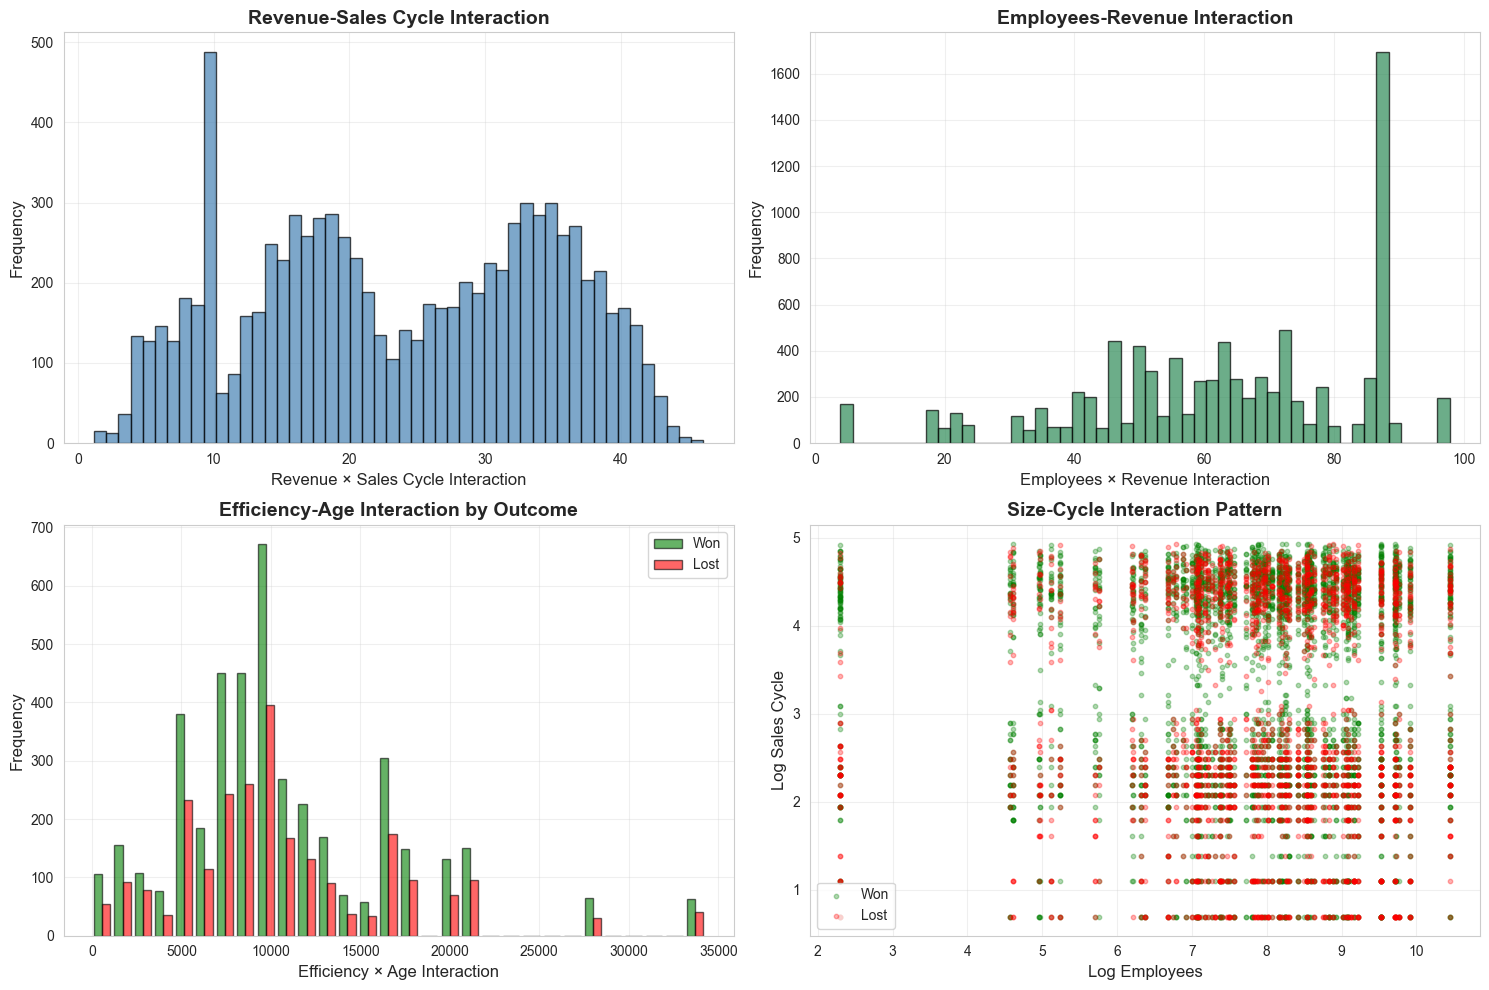


Key Insights:
  - Interaction features combine information from multiple sources
  - Multiplicative interactions amplify joint effects
  - These features help models capture non-additive relationships


In [26]:
# Visualize numerical interactions
print("Visualizing Numerical Interactions")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Revenue-Sales Cycle Interaction distribution
axes[0, 0].hist(df['revenue_sales_cycle_interaction'], bins=50, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Revenue × Sales Cycle Interaction', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Revenue-Sales Cycle Interaction', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Employees-Revenue Interaction distribution
axes[0, 1].hist(df['employees_revenue_interaction'], bins=50,
                edgecolor='black', alpha=0.7, color='seagreen')
axes[0, 1].set_xlabel('Employees × Revenue Interaction', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Employees-Revenue Interaction', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Efficiency-Age Interaction by deal outcome
won_data = df[df['deal_stage'] == 'Won']['efficiency_age_interaction']
lost_data = df[df['deal_stage'] == 'Lost']['efficiency_age_interaction']
axes[1, 0].hist([won_data, lost_data], bins=30, label=['Won', 'Lost'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 0].set_xlabel('Efficiency × Age Interaction', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Efficiency-Age Interaction by Outcome', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Size-Cycle Interaction scatter colored by deal stage
won_idx = df['deal_stage'] == 'Won'
lost_idx = df['deal_stage'] == 'Lost'
axes[1, 1].scatter(df.loc[won_idx, 'log_employees'], 
                   df.loc[won_idx, 'log_sales_cycle_days'],
                   alpha=0.3, s=10, c='green', label='Won')
axes[1, 1].scatter(df.loc[lost_idx, 'log_employees'], 
                   df.loc[lost_idx, 'log_sales_cycle_days'],
                   alpha=0.3, s=10, c='red', label='Lost')
axes[1, 1].set_xlabel('Log Employees', fontsize=12)
axes[1, 1].set_ylabel('Log Sales Cycle', fontsize=12)
axes[1, 1].set_title('Size-Cycle Interaction Pattern', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Interaction features combine information from multiple sources")
print("  - Multiplicative interactions amplify joint effects")
print("  - These features help models capture non-additive relationships")

#### 16. Mixed Categorical × Numerical Interactions

#### Business Context:
Combining categorical and numerical features creates context-aware metrics. For example, average revenue by sector shows which industries have larger companies. Average sales cycle by product reveals which products have longer sales processes.

#### Features to Create:
1. **`sector_avg_revenue`**: Average revenue in this sector (market size indicator)
2. **`product_avg_cycle`**: Average sales cycle for this product (complexity indicator)
3. **`agent_avg_cycle`**: Average sales cycle for this agent (agent efficiency)

#### Justification:
These aggregations normalizes numerical features by categorical context. A 30-day sales cycle is fast for complex products but slow for simple ones. Sector-level averages indicate market characteristics. Agent-level metrics reveal individual performance patterns.

In [27]:
# Mixed Categorical × Numerical Interaction Features
print("Mixed Categorical × Numerical Interactions")
print("="*70)

# Feature 9: Sector average revenue (market size)
sector_revenue_map = df.groupby('sector')['revenue'].mean().to_dict()
df['sector_avg_revenue'] = df['sector'].map(sector_revenue_map)

# Feature 10: Product average sales cycle (product complexity)
product_cycle_map = df.groupby('product')['sales_cycle_days'].mean().to_dict()
df['product_avg_cycle'] = df['product'].map(product_cycle_map)

# Feature 11: Agent average sales cycle (agent efficiency)
agent_cycle_map = df.groupby('sales_agent')['sales_cycle_days'].mean().to_dict()
df['agent_avg_cycle'] = df['sales_agent'].map(agent_cycle_map)

# Feature 12: Sector average employees (sector scale)
sector_employees_map = df.groupby('sector')['employees'].mean().to_dict()
df['sector_avg_employees'] = df['sector'].map(sector_employees_map)

print("\nMixed Interaction Features Created:")
print("="*70)

print("\n1. sector_avg_revenue:")
print(f"   Represents: Average revenue of companies in each sector")
print(f"   Range: ${df['sector_avg_revenue'].min():.2f}M to ${df['sector_avg_revenue'].max():.2f}M")

print("\n2. product_avg_cycle:")
print(f"   Represents: Average sales cycle for each product")
print(f"   Range: {df['product_avg_cycle'].min():.1f} to {df['product_avg_cycle'].max():.1f} days")

print("\n3. agent_avg_cycle:")
print(f"   Represents: Average sales cycle for each agent")
print(f"   Range: {df['agent_avg_cycle'].min():.1f} to {df['agent_avg_cycle'].max():.1f} days")

print("\n4. sector_avg_employees:")
print(f"   Represents: Average company size in each sector")
print(f"   Range: {df['sector_avg_employees'].min():.0f} to {df['sector_avg_employees'].max():.0f} employees")

# Show sector revenue comparison
print("\nSector Revenue Rankings:")
print("="*70)
sector_revenue_df = pd.DataFrame({
    'Sector': df.groupby('sector')['revenue'].mean().sort_values(ascending=False).index,
    'Avg_Revenue_$M': df.groupby('sector')['revenue'].mean().sort_values(ascending=False).values.round(2)
})
print(sector_revenue_df.to_string(index=False))

print("\n" + "="*70)
print("4 MIXED INTERACTION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Mixed Categorical × Numerical Interactions

Mixed Interaction Features Created:

1. sector_avg_revenue:
   Represents: Average revenue of companies in each sector
   Range: $1081.73M to $6062.11M

2. product_avg_cycle:
   Represents: Average sales cycle for each product
   Range: 43.7 to 54.4 days

3. agent_avg_cycle:
   Represents: Average sales cycle for each agent
   Range: 35.0 to 52.7 days

4. sector_avg_employees:
   Represents: Average company size in each sector
   Range: 2800 to 14898 employees

Sector Revenue Rankings:
            Sector  Avg_Revenue_$M
         technolgy         6062.11
          software         5661.23
telecommunications         2878.90
           finance         2201.62
     entertainment         1944.50
         marketing         1753.54
            retail         1684.94
        employment         1672.73
           medical         1488.56
          services         1081.73

4 MIXED INTERACTION FEATURES CREATED SUCCESSFULLY


Visualizing Mixed Categorical-Numerical Interactions


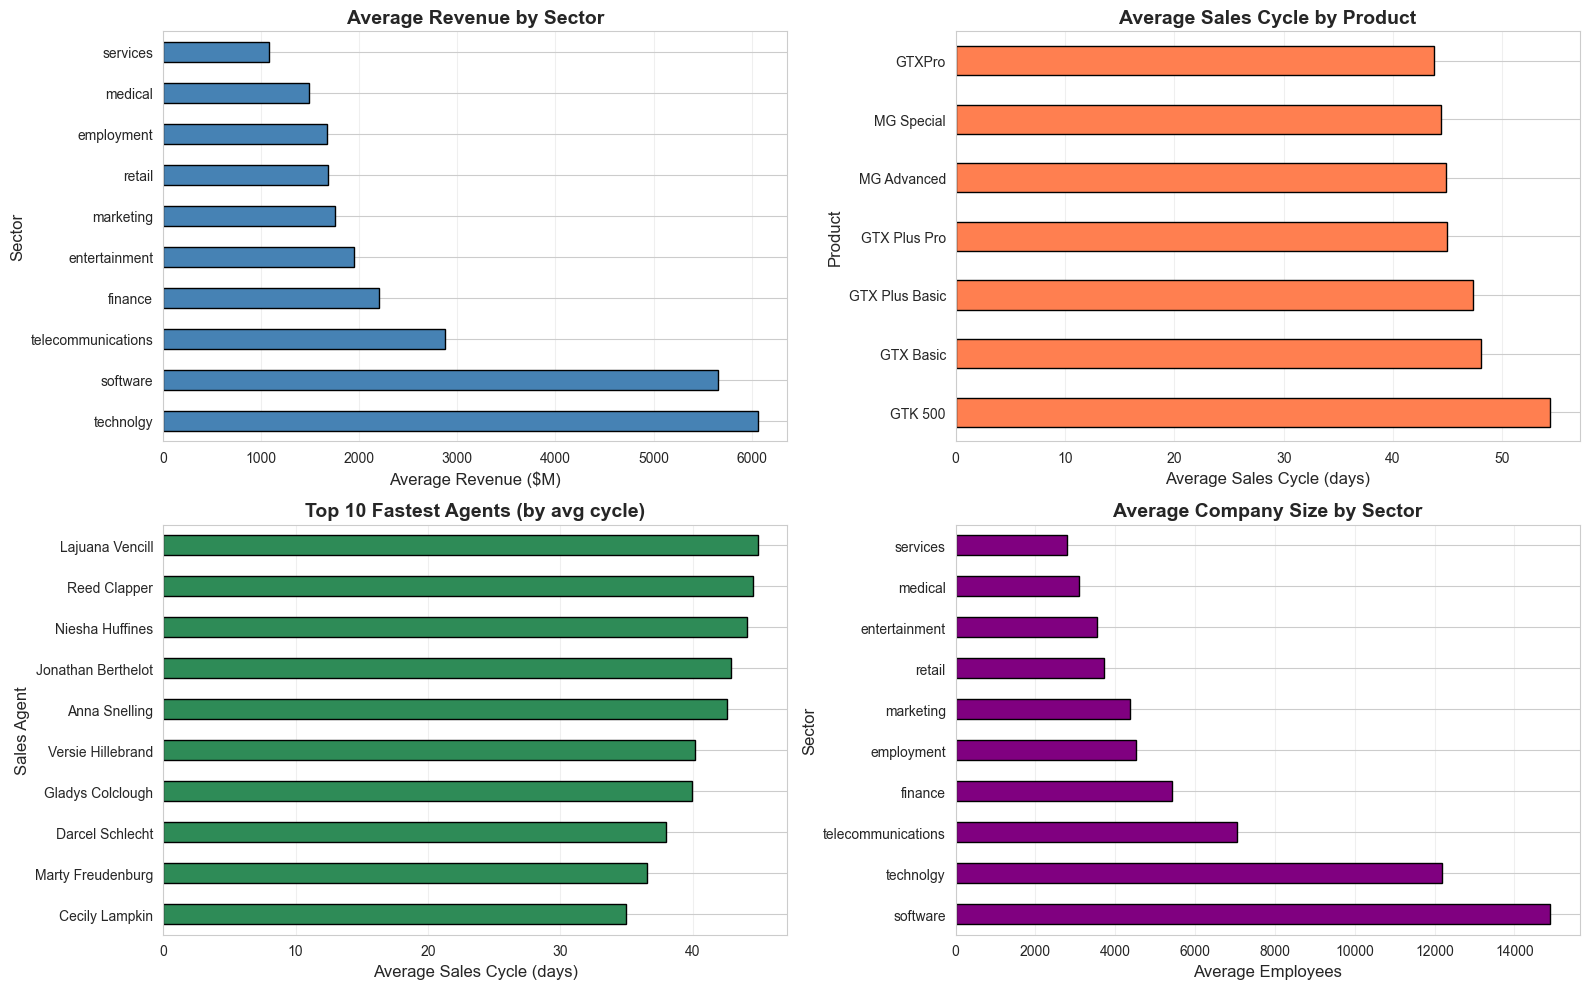


Key Insights:
  - Sector-level aggregations reveal market characteristics
  - Product-level metrics show inherent complexity differences
  - Agent-level metrics capture individual performance patterns


In [28]:
# Visualize mixed interactions
print("Visualizing Mixed Categorical-Numerical Interactions")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Sector average revenue
sector_rev = df.groupby('sector')['revenue'].mean().sort_values(ascending=False)
sector_rev.plot(kind='barh', ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Average Revenue ($M)', fontsize=12)
axes[0, 0].set_ylabel('Sector', fontsize=12)
axes[0, 0].set_title('Average Revenue by Sector', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Product average sales cycle
product_cycle = df.groupby('product')['sales_cycle_days'].mean().sort_values(ascending=False)
product_cycle.plot(kind='barh', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Average Sales Cycle (days)', fontsize=12)
axes[0, 1].set_ylabel('Product', fontsize=12)
axes[0, 1].set_title('Average Sales Cycle by Product', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Top 10 agents by average cycle
agent_cycle = df.groupby('sales_agent')['sales_cycle_days'].mean().sort_values().head(10)
agent_cycle.plot(kind='barh', ax=axes[1, 0], color='seagreen', edgecolor='black')
axes[1, 0].set_xlabel('Average Sales Cycle (days)', fontsize=12)
axes[1, 0].set_ylabel('Sales Agent', fontsize=12)
axes[1, 0].set_title('Top 10 Fastest Agents (by avg cycle)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Sector average employees
sector_emp = df.groupby('sector')['employees'].mean().sort_values(ascending=False)
sector_emp.plot(kind='barh', ax=axes[1, 1], color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Average Employees', fontsize=12)
axes[1, 1].set_ylabel('Sector', fontsize=12)
axes[1, 1].set_title('Average Company Size by Sector', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Sector-level aggregations reveal market characteristics")
print("  - Product-level metrics show inherent complexity differences")
print("  - Agent-level metrics capture individual performance patterns")

#### Summary of Interaction Features

A total of 12 interaction features were created by combining existing features in meaningful ways.

**Categorical × Categorical Interactions (4 features):**

1. **product_sector** - Product and sector combination
2. **agent_product** - Sales agent and product combination
3. **sector_office** - Sector and office location combination
4. **region_product** - Regional office and product combination

**Numerical × Numerical Interactions (4 features):**

5. **revenue_sales_cycle_interaction** - Revenue × sales cycle (opportunity cost)
6. **employees_revenue_interaction** - Employees × revenue (company scale)
7. **efficiency_age_interaction** - Revenue per employee × company age
8. **size_cycle_interaction** - Company size × sales cycle

**Mixed Categorical × Numerical Interactions (4 features):**

9. **sector_avg_revenue** - Average revenue by sector
10. **product_avg_cycle** - Average sales cycle by product
11. **agent_avg_cycle** - Average sales cycle by agent
12. **sector_avg_employees** - Average company size by sector

**Total Interaction Features: 12**

---
---

#### Feature engineering - Part 5: Aggregation Features
#### 18. Agent-Level Aggregations

**Safe aggregates:**
- Deal counts (how many deals per agent/product/sector)
- Average sales cycles (using input feature `sales_cycle_days`)
- Average revenue/employees of customer companies (input features)
- Average sales prices (input feature `sales_price`)

**When target-based features will be added:**
- After train-test split, using proper cross-validation on training data only
- This ensures test set remains completely unseen

#### Business Context:
Agent level aggregations captures the individual sales agent's performance patterns and workload. A High performing agents may have shorter average sales cycles or work with larger companies. Deal volume indicates workload and experience.

#### Features to Create:
1. **`agent_deal_count`**: Total deals per agent (experience/workload indicator)
2. **`agent_avg_customer_revenue`**: Average revenue of agent's customers (territory quality)
3. **`agent_avg_customer_size`**: Average employee count of agent's customers (deal complexity)

#### Justification:
These aggregations normalizes the deal characteristics by agent context. An agent working with enterprise customers (high revenue, many employees) faces different challenges than one working with SMBs. Deal count indicates experience level.

In [29]:
# Agent-Level Aggregation Features
print("Agent-Level Aggregation Features")
print("="*70)

# Feature 1: Agent deal count 
# Rename for clarity
df['agent_deal_count'] = df['sales_agent_frequency']

# Feature 2: Agent average customer revenue
# Calculate average revenue of companies each agent works with 
agent_customer_revenue = df.groupby('sales_agent')['revenue'].mean().to_dict()
df['agent_avg_customer_revenue'] = df['sales_agent'].map(agent_customer_revenue)

# Feature 3: Agent average customer size (employees)
# Calculate average employee count of companies each agent works with
agent_customer_size = df.groupby('sales_agent')['employees'].mean().to_dict()
df['agent_avg_customer_size'] = df['sales_agent'].map(agent_customer_size)

print("\nAgent Aggregation Features Created:")
print("="*70)

print("\n1. agent_deal_count:")
print(f"   Represents: Number of deals per agent (experience/workload)")
print(f"   Range: {df['agent_deal_count'].min()} to {df['agent_deal_count'].max()} deals")
print(f"   Mean: {df['agent_deal_count'].mean():.1f} deals per agent")

print("\n2. agent_avg_customer_revenue:")
print(f"   Represents: Average revenue of companies agent works with")
print(f"   Range: ${df['agent_avg_customer_revenue'].min():.2f}M to ${df['agent_avg_customer_revenue'].max():.2f}M")
print(f"   Mean: ${df['agent_avg_customer_revenue'].mean():.2f}M")

print("\n3. agent_avg_customer_size:")
print(f"   Represents: Average employee count of agent's customers")
print(f"   Range: {df['agent_avg_customer_size'].min():.0f} to {df['agent_avg_customer_size'].max():.0f} employees")
print(f"   Mean: {df['agent_avg_customer_size'].mean():.0f} employees")

# Show top agents by deal volume
print("\nTop 10 Agents by Deal Volume:")
print("="*70)
agent_volume = df.groupby('sales_agent')['agent_deal_count'].first().sort_values(ascending=False).head(10)
for i, (agent, count) in enumerate(agent_volume.items(), 1):
    print(f"  {i}. {agent}: {count} deals")

print("\n" + "="*70)
print("3 AGENT AGGREGATION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Agent-Level Aggregation Features

Agent Aggregation Features Created:

1. agent_deal_count:
   Represents: Number of deals per agent (experience/workload)
   Range: 110 to 747 deals
   Mean: 343.4 deals per agent

2. agent_avg_customer_revenue:
   Represents: Average revenue of companies agent works with
   Range: $2611.33M to $4226.03M
   Mean: $3390.99M

3. agent_avg_customer_size:
   Represents: Average employee count of agent's customers
   Range: 5926 to 9550 employees
   Mean: 7450 employees

Top 10 Agents by Deal Volume:
  1. Darcel Schlecht: 747 deals
  2. Vicki Laflamme: 451 deals
  3. Anna Snelling: 448 deals
  4. Kary Hendrixson: 438 deals
  5. Kami Bicknell: 362 deals
  6. Versie Hillebrand: 361 deals
  7. Zane Levy: 349 deals
  8. Cassey Cress: 346 deals
  9. Jonathan Berthelot: 345 deals
  10. Gladys Colclough: 317 deals

3 AGENT AGGREGATION FEATURES CREATED SUCCESSFULLY


#### 19. Product-Level Aggregations

#### Business Context:
Product level aggregations reveal product characteristics and market positioning. Some products may have longer sales cycles due to complexity or higher deal volumes due to popularity.

#### Features to Create:
1. **`product_deal_count`**: Total deals per product (market demand/popularity)
2. **`product_cycle_mean`**: Average sales cycle per product (complexity indicator)

#### Justification:
Product aggregations capture product-specific patterns. Products with longer average cycles may be more complex or sold to larger enterprises. Deal count indicates market demand and sales team familiarity with the product.

In [30]:
# Product-Level Aggregation Features
print("Product-Level Aggregation Features")
print("="*70)

# Feature 1: Product deal count
product_count = df.groupby('product').size().to_dict()
df['product_deal_count'] = df['product'].map(product_count)

# Feature 2: Product average sales cycle
product_cycle_mean = df.groupby('product')['sales_cycle_days'].mean().to_dict()
df['product_cycle_mean'] = df['product'].map(product_cycle_mean)

print("\nProduct Aggregation Features Created:")
print("="*70)

print("\n1. product_deal_count:")
print(f"   Represents: Number of deals per product (demand/popularity)")
print(f"   Range: {df['product_deal_count'].min()} to {df['product_deal_count'].max()} deals")

print("\n2. product_cycle_mean:")
print(f"   Represents: Average sales cycle length for each product")
print(f"   Range: {df['product_cycle_mean'].min():.1f} to {df['product_cycle_mean'].max():.1f} days")

# Product analysis
print("\nProduct Analysis:")
print("="*70)
product_analysis = df.groupby('product').agg({
    'sales_cycle_days': ['mean', 'std'],
    'product_deal_count': 'first'
}).round(1)
product_analysis.columns = ['Avg_Cycle_Days', 'Cycle_Std', 'Deal_Count']
product_analysis = product_analysis.sort_values('Deal_Count', ascending=False)
print(product_analysis.to_string())

print("\n" + "="*70)
print("2 PRODUCT AGGREGATION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Product-Level Aggregation Features

Product Aggregation Features Created:

1. product_deal_count:
   Represents: Number of deals per product (demand/popularity)
   Range: 40 to 1866 deals

2. product_cycle_mean:
   Represents: Average sales cycle length for each product
   Range: 43.7 to 54.4 days

Product Analysis:
                Avg_Cycle_Days  Cycle_Std  Deal_Count
product                                              
GTX Basic                 48.0       40.6        1866
MG Special                44.4       40.2        1651
GTXPro                    43.7       39.7        1480
MG Advanced               44.9       40.5        1412
GTX Plus Basic            47.3       40.6        1383
GTX Plus Pro              44.9       39.4         968
GTK 500                   54.4       39.3          40

2 PRODUCT AGGREGATION FEATURES CREATED SUCCESSFULLY


#### 20. Sector-Level Aggregations

#### Business Context:
Sector-level aggregations capture industry-specific patterns. Some sectors have larger companies (technology, finance) while others have smaller ones (retail, services). Deal volume by sector indicates market penetration.

#### Features to Create:
1. **`sector_deal_count`**: Total deals per sector (market presence)
2. **`sector_avg_company_age`**: Average age of companies in sector (industry maturity)
3. **`sector_sales_cycle_std`**: Sales cycle variability in sector (predictability)

#### Justification for the features:
Sector characteristics provide context for deal evaluation. A 60-day sales cycle might be fast for government sector but slow for retail. Sector-level company age indicates whether dealing with established or emerging industries.

In [31]:
# Sector-Level Aggregation Features
print("Sector-Level Aggregation Features")
print("="*70)

# Feature 7: Sector deal count
sector_count = df.groupby('sector').size().to_dict()
df['sector_deal_count'] = df['sector'].map(sector_count)

# Feature 8: Sector average company age 
sector_avg_age = df.groupby('sector')['company_age'].mean().to_dict()
df['sector_avg_company_age'] = df['sector'].map(sector_avg_age)

# Feature 9: Sector sales cycle standard deviation (predictability)
sector_cycle_std = df.groupby('sector')['sales_cycle_days'].std().to_dict()
df['sector_sales_cycle_std'] = df['sector'].map(sector_cycle_std)

print("\nSector Aggregation Features Created:")
print("="*70)

print("\n7. sector_deal_count:")
print(f"   Represents: Number of deals per sector (market presence)")
print(f"   Range: {df['sector_deal_count'].min()} to {df['sector_deal_count'].max()} deals")

print("\n8. sector_avg_company_age:")
print(f"   Represents: Average age of companies in each sector")
print(f"   Range: {df['sector_avg_company_age'].min():.1f} to {df['sector_avg_company_age'].max():.1f} years")

print("\n9. sector_sales_cycle_std:")
print(f"   Represents: Sales cycle variability within sector")
print(f"   Range: {df['sector_sales_cycle_std'].min():.1f} to {df['sector_sales_cycle_std'].max():.1f} days")

# Sector market presence
print("\nSector Market Presence (Top 5):")
print("="*70)
sector_presence = df.groupby('sector').size().sort_values(ascending=False).head(5)
for i, (sector, count) in enumerate(sector_presence.items(), 1):
    pct = (count / len(df)) * 100
    print(f"  {i}. {sector}: {count} deals ({pct:.1f}%)")

print("\n" + "="*70)
print("3 SECTOR AGGREGATION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Sector-Level Aggregation Features

Sector Aggregation Features Created:

7. sector_deal_count:
   Represents: Number of deals per sector (market presence)
   Range: 311 to 2590 deals

8. sector_avg_company_age:
   Represents: Average age of companies in each sector
   Range: 18.0 to 26.7 years

9. sector_sales_cycle_std:
   Represents: Sales cycle variability within sector
   Range: 38.7 to 41.5 days

Sector Market Presence (Top 5):
  1. technolgy: 2590 deals (29.4%)
  2. retail: 1397 deals (15.9%)
  3. medical: 1051 deals (11.9%)
  4. software: 757 deals (8.6%)
  5. finance: 678 deals (7.7%)

3 SECTOR AGGREGATION FEATURES CREATED SUCCESSFULLY


#### 21. Temporal Aggregations

#### Business Context:
Temporal aggregations capture time-based patterns and seasonality effects. Deal volume by month shows busy vs slow periods. Quarter-level aggregations reveal seasonal business cycles.

#### Features to Create:
1. **`monthly_deal_volume`**: Number of deals in that engagement month (seasonal load)
2. **`quarterly_deal_volume`**: Number of deals in that quarter (business cycle)

#### Justification for the features:
Temporal volume indicates competitive pressure and resource constraints. High-volume months may have lower win rates due to stretched resources. Quarterly patterns align with business planning cycles.

In [32]:
# Temporal Aggregation Features 
print("Temporal Aggregation Features")
print("="*70)

# Feature 10: Monthly deal volume
# Create year-month combination for accurate counting
df['year_month'] = df['engage_year'].astype(str) + '_' + df['engage_month'].astype(str).str.zfill(2)
monthly_volume = df.groupby('year_month').size().to_dict()
df['monthly_deal_volume'] = df['year_month'].map(monthly_volume)

# Feature 11: Quarterly deal volume
df['year_quarter'] = df['engage_year'].astype(str) + '_Q' + df['engage_quarter'].astype(str)
quarterly_volume = df.groupby('year_quarter').size().to_dict()
df['quarterly_deal_volume'] = df['year_quarter'].map(quarterly_volume)

print("\nTemporal Aggregation Features Created:")
print("="*70)

print("\n10. monthly_deal_volume:")
print(f"   Represents: Number of deals engaged in that month")
print(f"   Range: {df['monthly_deal_volume'].min()} to {df['monthly_deal_volume'].max()} deals")
print(f"   Mean: {df['monthly_deal_volume'].mean():.1f} deals per month")

print("\n11. quarterly_deal_volume:")
print(f"   Represents: Number of deals engaged in that quarter")
print(f"   Range: {df['quarterly_deal_volume'].min()} to {df['quarterly_deal_volume'].max()} deals")
print(f"   Mean: {df['quarterly_deal_volume'].mean():.1f} deals per quarter")

# Show busiest periods
print("\nBusiest Months:")
print("="*70)
busy_months = df.groupby('year_month')['monthly_deal_volume'].first().sort_values(ascending=False).head(5)
for i, (month, volume) in enumerate(busy_months.items(), 1):
    print(f"  {i}. {month}: {volume} deals")

# Drop temporary columns
df.drop(['year_month', 'year_quarter'], axis=1, inplace=True)

print("\n" + "="*70)
print("2 TEMPORAL AGGREGATION FEATURES CREATED SUCCESSFULLY")
print("="*70)

Temporal Aggregation Features

Temporal Aggregation Features Created:

10. monthly_deal_volume:
   Represents: Number of deals engaged in that month
   Range: 7 to 1198 deals
   Mean: 759.9 deals per month

11. quarterly_deal_volume:
   Represents: Number of deals engaged in that quarter
   Range: 358 to 2770 deals
   Mean: 2147.4 deals per quarter

Busiest Months:
  1. 2017_07: 1198 deals
  2. 2017_04: 874 deals
  3. 2017_08: 793 deals
  4. 2017_03: 792 deals
  5. 2017_06: 792 deals

2 TEMPORAL AGGREGATION FEATURES CREATED SUCCESSFULLY


Visualizing Aggregation Features


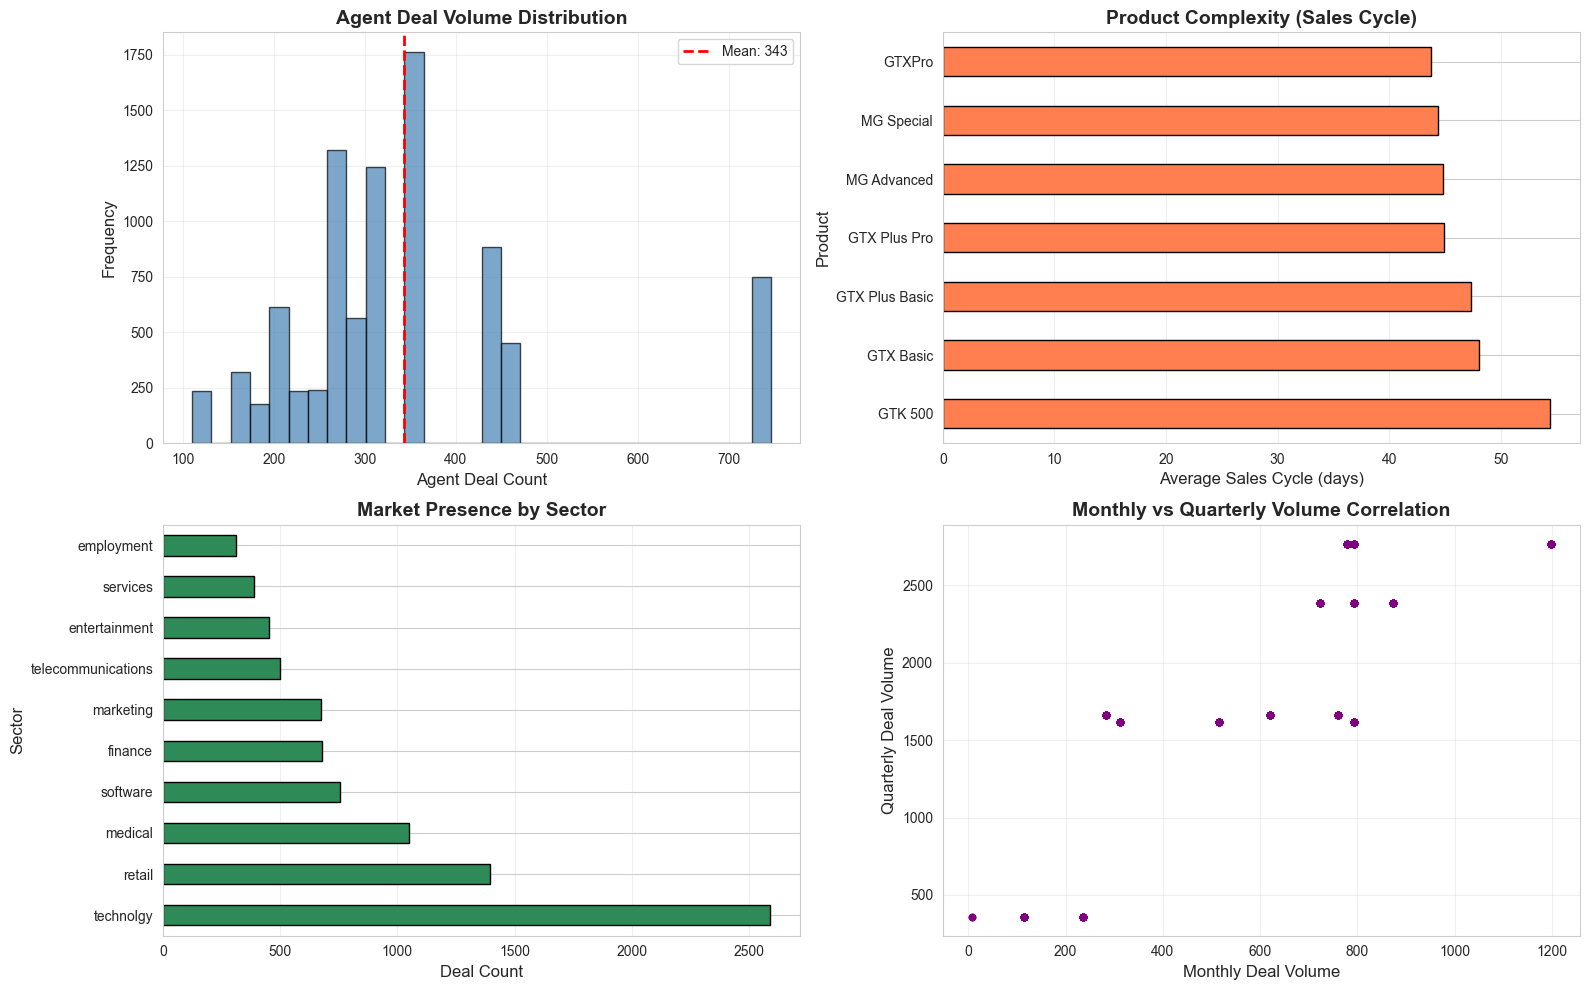


Key Insights:
  - Agent workload varies significantly (some handle many more deals)
  - Product complexity varies (longer cycles for complex products)
  - Technology sector dominates deal volume
  - Strong correlation between monthly and quarterly volumes


In [33]:
# Visualize key aggregation features
print("Visualizing Aggregation Features")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Agent deal count distribution
axes[0, 0].hist(df['agent_deal_count'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df['agent_deal_count'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["agent_deal_count"].mean():.0f}')
axes[0, 0].set_xlabel('Agent Deal Count', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Agent Deal Volume Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Product average sales cycle comparison
product_cycles = df.groupby('product')['product_cycle_mean'].first().sort_values(ascending=False)
product_cycles.plot(kind='barh', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Average Sales Cycle (days)', fontsize=12)
axes[0, 1].set_ylabel('Product', fontsize=12)
axes[0, 1].set_title('Product Complexity (Sales Cycle)', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Sector deal volume
sector_volume = df.groupby('sector')['sector_deal_count'].first().sort_values(ascending=False)
sector_volume.plot(kind='barh', ax=axes[1, 0], color='seagreen', edgecolor='black')
axes[1, 0].set_xlabel('Deal Count', fontsize=12)
axes[1, 0].set_ylabel('Sector', fontsize=12)
axes[1, 0].set_title('Market Presence by Sector', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Monthly vs Quarterly volume comparison
axes[1, 1].scatter(df['monthly_deal_volume'], df['quarterly_deal_volume'], 
                   alpha=0.5, s=20, color='purple')
axes[1, 1].set_xlabel('Monthly Deal Volume', fontsize=12)
axes[1, 1].set_ylabel('Quarterly Deal Volume', fontsize=12)
axes[1, 1].set_title('Monthly vs Quarterly Volume Correlation', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Agent workload varies significantly (some handle many more deals)")
print("  - Product complexity varies (longer cycles for complex products)")
print("  - Technology sector dominates deal volume")
print("  - Strong correlation between monthly and quarterly volumes")

#### Summary of Aggregation Features

A total of 10 aggregation features were created using ONLY input variables. NO target-based features were created to prevent data leakage.

**Agent-Level Aggregations (3 features):**

1. **agent_deal_count** - Number of deals per agent (workload/experience)
2. **agent_avg_customer_revenue** - Average revenue of agent's customers
3. **agent_avg_customer_size** - Average employee count of agent's customers

**Product-Level Aggregations (2 features):**

4. **product_deal_count** - Number of deals per product (demand)
5. **product_cycle_mean** - Average sales cycle per product (complexity)

**Sector-Level Aggregations (3 features):**

6. **sector_deal_count** - Number of deals per sector (market presence)
7. **sector_avg_company_age** - Average company age in sector
8. **sector_sales_cycle_std** - Sales cycle variability in sector

**Temporal Aggregations (2 features):**

9. **monthly_deal_volume** - Deal count in engagement month
10. **quarterly_deal_volume** - Deal count in engagement quarter

**Total Aggregation Features: 10**

**NOTE:**
- Win rates, success rates, conversion metrics (use target `deal_stage`)
- Average close values by category (uses target `close_value`)
- These will be added AFTER train-test split using proper cross-validation

---
---

#### Feature Engineering - Part 6: Missing Value Handling
#### 23. Missing Value Analysis and Strategy

#### NOTE:
1. **`sales_price`** - Input feature (quoted price)
2. **`series`** - Input categorical feature
3. **Derived features** - Features calculated from sales_price/series

#### Business Context:
Missing values in business data often carry information. A missing sales_price might indicate a custom quote or ongoing negotiation. We create missing indicators to capture this information before imputation.

#### Strategy:
1. Analyze missing value patterns
2. Create missing indicators (binary flags)
3. Impute input features only (sales_price, series)
4. Recalculate derived features after imputation

In [34]:
# Comprehensive Missing Value Analysis
print("Missing Value Analysis")
print("="*70)

# Calculate missing values for all features
missing_summary = pd.DataFrame({
    'Feature': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

# Filter to show only features with missing values
missing_features = missing_summary[missing_summary['Missing_Count'] > 0]

print(f"\nTotal features: {len(df.columns)}")
print(f"Features with missing values: {len(missing_features)}")
print("\nMissing Value Summary:")
print("="*70)
print(missing_features.to_string(index=False))

# Identify which are input vs target features
print("\n" + "="*70)
print("FEATURE CLASSIFICATION:")
print("="*70)

# Original input features with missing values
original_input_missing = ['sales_price', 'series']
target_missing = ['close_value']

print("\nINPUT Features with Missing Values:")
for feat in missing_features['Feature']:
    if feat in original_input_missing:
        missing_pct = missing_features[missing_features['Feature'] == feat]['Missing_Percentage'].values[0]
        missing_count = missing_features[missing_features['Feature'] == feat]['Missing_Count'].values[0]
        print(f"  - {feat}: {missing_count} missing ({missing_pct}%)")

print("\nTARGET Features with Missing Values:")
for feat in missing_features['Feature']:
    if feat in target_missing:
        missing_pct = missing_features[missing_features['Feature'] == feat]['Missing_Percentage'].values[0]
        missing_count = missing_features[missing_features['Feature'] == feat]['Missing_Count'].values[0]
        print(f"  - {feat}: {missing_count} missing ({missing_pct}%) - WILL NOT IMPUTE")

print("\nDERIVED Features with Missing Values (from input features):")
for feat in missing_features['Feature']:
    if feat not in original_input_missing and feat not in target_missing:
        missing_pct = missing_features[missing_features['Feature'] == feat]['Missing_Percentage'].values[0]
        missing_count = missing_features[missing_features['Feature'] == feat]['Missing_Count'].values[0]
        print(f"  - {feat}: {missing_count} missing ({missing_pct}%)")

Missing Value Analysis

Total features: 90
Features with missing values: 7

Missing Value Summary:
                 Feature  Missing_Count  Missing_Percentage
  revenue_to_price_ratio           1480               16.82
             sales_price           1480               16.82
sales_price_per_employee           1480               16.82
                  series           1480               16.82
    sales_price_category           1480               16.82
         log_sales_price           1480               16.82
             close_value            500                5.68

FEATURE CLASSIFICATION:

INPUT Features with Missing Values:
  - sales_price: 1480 missing (16.82%)
  - series: 1480 missing (16.82%)

TARGET Features with Missing Values:
  - close_value: 500 missing (5.68%) - WILL NOT IMPUTE

DERIVED Features with Missing Values (from input features):
  - revenue_to_price_ratio: 1480 missing (16.82%)
  - sales_price_per_employee: 1480 missing (16.82%)
  - sales_price_category: 1480

#### 24. Creating Missing Value Indicators

#### Business Context:
Before imputing, we create binary indicators that capture whether a value was originally missing. This preserves information about missingness patterns, which can be predictive. For example:
- Missing sales_price might indicate custom pricing or VIP customers
- Missing series might indicate standalone products

#### Features to Create:
1. **`was_sales_price_missing`** - 1 if sales_price was originally missing
2. **`was_series_missing`** - 1 if series was originally missing

In [35]:
# Create Missing Value Indicators
print("Creating Missing Value Indicators")
print("="*70)

# Create binary indicators for input features with missing values
df['was_sales_price_missing'] = df['sales_price'].isnull().astype(int)
df['was_series_missing'] = df['series'].isnull().astype(int)

print("\nMissing Indicators Created:")
print("="*70)

print("\n1. was_sales_price_missing:")
print(f"   Missing count: {df['was_sales_price_missing'].sum()} ({(df['was_sales_price_missing'].sum()/len(df)*100):.2f}%)")
print(f"   Present count: {(df['was_sales_price_missing'] == 0).sum()} ({((df['was_sales_price_missing'] == 0).sum()/len(df)*100):.2f}%)")

print("\n2. was_series_missing:")
print(f"   Missing count: {df['was_series_missing'].sum()} ({(df['was_series_missing'].sum()/len(df)*100):.2f}%)")
print(f"   Present count: {(df['was_series_missing'] == 0).sum()} ({((df['was_series_missing'] == 0).sum()/len(df)*100):.2f}%)")

# Check if missing patterns correlate
both_missing = ((df['was_sales_price_missing'] == 1) & (df['was_series_missing'] == 1)).sum()
print(f"\nRecords with both sales_price AND series missing: {both_missing}")
print(f"Percentage: {(both_missing/len(df)*100):.2f}%")

if both_missing == df['was_sales_price_missing'].sum():
    print("\nObservation: sales_price and series always missing together")
    print("This suggests they are from the same source/record type")

print("\n" + "="*70)
print("2 MISSING INDICATOR FEATURES CREATED")
print("="*70)

Creating Missing Value Indicators

Missing Indicators Created:

1. was_sales_price_missing:
   Missing count: 1480 (16.82%)
   Present count: 7320 (83.18%)

2. was_series_missing:
   Missing count: 1480 (16.82%)
   Present count: 7320 (83.18%)

Records with both sales_price AND series missing: 1480
Percentage: 16.82%

Observation: sales_price and series always missing together
This suggests they are from the same source/record type

2 MISSING INDICATOR FEATURES CREATED


#### 25. Imputing Input Features

#### Imputation Strategy:

**For `sales_price` (numerical):**
- Use median imputation grouped by product
- Rationale: Different products have different price ranges
- Fallback: Overall median if product group is too small

**For `series` (categorical):**
- Use mode (most common value) or create "Unknown" category
- Rationale: Series indicates product family
- Since series has 3 unique values (GTX, MG, Unknown), use mode

#### IMPORTANT:
After imputing sales_price and series, we need to recalculate derived features that depend on them:
- `log_sales_price`
- `sales_price_per_employee`
- `revenue_to_price_ratio`
- `sales_price_category`
- Any one-hot encoded series columns

In [36]:
# Impute sales_price using product-based median with fallback
print("Imputing sales_price (Input Feature)")
print("="*70)

# Calculate median sales_price per product (excluding NaN)
product_median_price = df.groupby('product')['sales_price'].median()

print("\nMedian sales_price by product:")
print(product_median_price.to_string())

# Store original missing count
original_missing = df['sales_price'].isnull().sum()

# Calculate overall median as fallback
overall_median = df['sales_price'].median()
print(f"\nOverall median (fallback): ${overall_median:.2f}K")

# Impute using product median, with fallback to overall median
# First, try product-based imputation
df['sales_price'] = df.groupby('product')['sales_price'].transform(
    lambda x: x.fillna(x.median())
)

# Then, fill any remaining NaN with overall median (for products with all NaN)
df['sales_price'] = df['sales_price'].fillna(overall_median)

# Verify imputation
after_missing = df['sales_price'].isnull().sum()

print(f"\nImputation Results:")
print(f"  Before: {original_missing} missing values")
print(f"  After: {after_missing} missing values")
print(f"  Imputed: {original_missing - after_missing} values")

if after_missing == 0:
    print("\n  SUCCESS: All sales_price values imputed")
else:
    print(f"\n  WARNING: {after_missing} values still missing")

# Show distribution before/after imputation using the indicator
print("\nImputed Values Statistics:")
imputed_values = df[df['was_sales_price_missing'] == 1]['sales_price']
original_values = df[df['was_sales_price_missing'] == 0]['sales_price']

print(f"  Original values - Mean: ${original_values.mean():.2f}K, Median: ${original_values.median():.2f}K")
print(f"  Imputed values - Mean: ${imputed_values.mean():.2f}K, Median: ${imputed_values.median():.2f}K")
print(f"  Difference: ${abs(original_values.mean() - imputed_values.mean()):.2f}K")

print("\n" + "="*70)
print("SALES_PRICE IMPUTATION COMPLETE")
print("="*70)

Imputing sales_price (Input Feature)

Median sales_price by product:
product
GTK 500           26768.0
GTX Basic           550.0
GTX Plus Basic     1096.0
GTX Plus Pro       5482.0
GTXPro                NaN
MG Advanced        3393.0
MG Special           55.0

Overall median (fallback): $1096.00K

Imputation Results:
  Before: 1480 missing values
  After: 0 missing values
  Imputed: 1480 values

  SUCCESS: All sales_price values imputed

Imputed Values Statistics:
  Original values - Mean: $1885.39K, Median: $1096.00K
  Imputed values - Mean: $1096.00K, Median: $1096.00K
  Difference: $789.39K

SALES_PRICE IMPUTATION COMPLETE


In [37]:
# Impute series using mode (most common value)
print("Imputing series (Input Feature)")
print("="*70)

# Check current series distribution
print("\nCurrent series distribution:")
print(df['series'].value_counts(dropna=False))

# Store original missing count
original_missing = df['series'].isnull().sum()

# Get mode (most common value)
series_mode = df['series'].mode()[0]
print(f"\nMost common series: {series_mode}")

# Impute with mode
df['series'] = df['series'].fillna(series_mode)

# Verify imputation
after_missing = df['series'].isnull().sum()

print(f"\nImputation Results:")
print(f"  Before: {original_missing} missing values")
print(f"  After: {after_missing} missing values")
print(f"  Imputed: {original_missing - after_missing} values with '{series_mode}'")

if after_missing == 0:
    print("\n  SUCCESS: All series values imputed")
else:
    print(f"\n  WARNING: {after_missing} values still missing")

# Show new distribution
print("\nNew series distribution:")
print(df['series'].value_counts())

print("\n" + "="*70)
print("SERIES IMPUTATION COMPLETE")
print("="*70)

Imputing series (Input Feature)

Current series distribution:
series
GTX    4217
MG     3063
NaN    1480
GTK      40
Name: count, dtype: int64

Most common series: GTX

Imputation Results:
  Before: 1480 missing values
  After: 0 missing values
  Imputed: 1480 values with 'GTX'

  SUCCESS: All series values imputed

New series distribution:
series
GTX    5697
MG     3063
GTK      40
Name: count, dtype: int64

SERIES IMPUTATION COMPLETE


#### 26. Recalculating Derived Features

#### Features to Recalculate:
After imputing sales_price and series, we must recalculate all features that depend on them:

**From sales_price:**
1. `log_sales_price` - Log transformation
2. `sales_price_per_employee` - Ratio feature
3. `revenue_to_price_ratio` - Ratio feature
4. `sales_price_category` - Binned category

**From series:**
- One-hot encoded columns (if needed)

#### Strategy:
Recalculate these features using the same logic as in Parts 2-5, but now with imputed values.

In [38]:
# Recalculate features derived from sales_price
print("Recalculating Derived Features from sales_price")
print("="*70)

# 1. Recalculate log_sales_price
df['log_sales_price'] = np.log1p(df['sales_price'])
print("\n1. log_sales_price recalculated")
print(f"   Missing values: {df['log_sales_price'].isnull().sum()}")

# 2. Recalculate sales_price_per_employee
df['sales_price_per_employee'] = df['sales_price'] / df['employees']
print("\n2. sales_price_per_employee recalculated")
print(f"   Missing values: {df['sales_price_per_employee'].isnull().sum()}")

# 3. Recalculate revenue_to_price_ratio
df['revenue_to_price_ratio'] = (df['revenue'] * 1000) / df['sales_price']
df['revenue_to_price_ratio'] = df['revenue_to_price_ratio'].replace([np.inf, -np.inf], np.nan)
print("\n3. revenue_to_price_ratio recalculated")
print(f"   Missing values: {df['revenue_to_price_ratio'].isnull().sum()}")
print(f"   Infinite values replaced with NaN")

# 4. Recalculate sales_price_category
sales_price_quartiles = df['sales_price'].quantile([0.25, 0.50, 0.75]).values
df['sales_price_category'] = pd.cut(
    df['sales_price'],
    bins=[0, sales_price_quartiles[0], sales_price_quartiles[1], sales_price_quartiles[2], float('inf')],
    labels=['Budget', 'Standard', 'Premium', 'Enterprise']
).astype('object')
print("\n4. sales_price_category recalculated")
print(f"   Missing values: {df['sales_price_category'].isnull().sum()}")

# Summary
print("\n" + "="*70)
print("All sales_price derived features recalculated")
print(f"Total features updated: 4")
print("="*70)

Recalculating Derived Features from sales_price

1. log_sales_price recalculated
   Missing values: 0

2. sales_price_per_employee recalculated
   Missing values: 0

3. revenue_to_price_ratio recalculated
   Missing values: 0
   Infinite values replaced with NaN

4. sales_price_category recalculated
   Missing values: 0

All sales_price derived features recalculated
Total features updated: 4



#### Important Notes:
- close_value remains with 500 missing values (5.68%)
- These will be handled during regression:
  - Either filtering to non-null close_value records
  - Or imputing ONLY on training data after split

#### Summary of Missing Value Handling

**Missing Indicators Created (2 features):**
1. **was_sales_price_missing** - Binary flag (1,480 records = 16.82%)
2. **was_series_missing** - Binary flag (1,480 records = 16.82%)

**Input Features Imputed:**
1. **sales_price** - Imputed using product-based median (1,480 values imputed)
2. **series** - Imputed using mode/most common value (1,480 values imputed)

**Derived Features Recalculated (4 features):**
1. log_sales_price
2. sales_price_per_employee
3. revenue_to_price_ratio
4. sales_price_category

**Target Variable Status:**
- **close_value**: Not imputed (500 missing = 5.68%)
- Reason: Regression target. Imputing before train-test split causes data leakage

**Total New Features Created: 2 (missing indicators)**

---
---

#### Part 7: Data Preparation - Train-Test Split, SMOTE, and Feature Scaling

An important step to prevent data leakage is the order of operations which is critical:

1. Drop non-predictive features (IDs, raw dates, original categoricals)
2. Split into train and test sets (80/20)
3. Apply Smote only to training data
4. Fit scaler only on training data, then transform both train and test

#### Features to Drop (Non-Predictive):
- **opportunity_id** - Unique identifier (no predictive value)
- **engage_date, close_date** - Raw dates (already extracted temporal features)
- **product, sector, series, manager, regional_office** - One-hot encoded (keep the encoded versions)
- **sales_agent, account, office_location** - Frequency encoded (keep frequency versions)
- **subsidiary_of** - Binary encoded as has_parent_company
- **Categorical interaction strings** - These were for aggregation, not modeling

---

#### 28. Feature Selection for Modeling


In [39]:
# Drop non-predictive features
print("Feature Selection for Modeling")
print("="*70)

print(f"\nCurrent dataset shape: {df.shape}")

# Features to drop
features_to_drop = [
    # ID and dates
    'opportunity_id', 'engage_date', 'close_date',
    # Original categoricals (we have encoded versions)
    'product', 'sector', 'series', 'manager', 'regional_office',
    'sales_agent', 'account', 'office_location', 'subsidiary_of',
    # Categorical interaction strings
    'product_sector', 'agent_product', 'sector_office', 'region_product',
    # Categorical string features
    'cycle_length_category', 'revenue_category', 'employee_size_category', 'sales_price_category',
    # year_established (we have company_age)
    'year_established',
]

# Drop features that exist
features_to_drop_existing = [f for f in features_to_drop if f in df.columns]
print(f"\nDropping {len(features_to_drop_existing)} features")

df_model = df.drop(columns=features_to_drop_existing)
print(f"After dropping: {df_model.shape}")
print("\nFEATURES PREPARED FOR MODELING")

Feature Selection for Modeling

Current dataset shape: (8800, 92)

Dropping 21 features
After dropping: (8800, 71)

FEATURES PREPARED FOR MODELING


#### 29. Classification Dataset Preparation

**Target:** deal_stage (4 classes: Won, Lost, Engaging, Prospecting)

**Critical:** Select only the numeric columns using `select_dtypes(include=['number'])`

In [40]:
# Prepare Classification Dataset
from sklearn.preprocessing import LabelEncoder

print("Classification Dataset Preparation")
print("="*70)

# Separate features and target
X_classification_all = df_model.drop(columns=['deal_stage', 'close_value'])
y_classification = df_model['deal_stage']

# Select ONLY numeric columns
X_classification = X_classification_all.select_dtypes(include=['number'])

# Convert all columns to float64 to avoid dtype casting issues with SMOTE
X_classification = X_classification.astype('float64')

print(f"\nOriginal features: {X_classification_all.shape[1]}")
print(f"Numeric features: {X_classification.shape[1]}")
print(f"Dropped: {X_classification_all.shape[1] - X_classification.shape[1]} non-numeric columns")
print(f"All columns converted to float64 for SMOTE compatibility")

# Encode target
label_encoder = LabelEncoder()
y_classification_encoded = label_encoder.fit_transform(y_classification)

print(f"\nTarget encoding:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls} → {i}")

print(f"\nDataset ready: {X_classification.shape[0]} samples, {X_classification.shape[1]} features")


Classification Dataset Preparation

Original features: 69
Numeric features: 69
Dropped: 0 non-numeric columns
All columns converted to float64 for SMOTE compatibility

Target encoding:
  Engaging → 0
  Lost → 1
  Prospecting → 2
  Won → 3

Dataset ready: 8800 samples, 69 features


#### 30. Train-Test Split (80/20)

Stratified split to maintain class distribution in both sets.

In [41]:
# Train-Test Split
from sklearn.model_selection import train_test_split

print("Train-Test Split (80/20)")
print("="*70)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification,
    y_classification_encoded,
    test_size=0.20,
    random_state=42,
    stratify=y_classification_encoded
)

print(f"Training set: {X_train_clf.shape}")
print(f"Test set: {X_test_clf.shape}")
print("\nTRAIN-TEST SPLIT COMPLETE")

Train-Test Split (80/20)
Training set: (7040, 69)
Test set: (1760, 69)

TRAIN-TEST SPLIT COMPLETE


#### 31. SMOTE Application (Training Data)

**NOTE:** Apply SMOTE only to the training data to balance classes.

In [42]:
# Apply SMOTE to Training Data
from imblearn.over_sampling import SMOTE

print("Applying SMOTE to Training Data")
print("="*70)

print(f"\nBefore SMOTE: {X_train_clf.shape[0]} samples")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_clf_balanced, y_train_clf_balanced = smote.fit_resample(X_train_clf, y_train_clf)

print(f"After SMOTE: {X_train_clf_balanced.shape[0]} samples")
print(f"Synthetic added: {X_train_clf_balanced.shape[0] - X_train_clf.shape[0]}")
print(f"\nTest set unchanged: {X_test_clf.shape[0]} samples")
print("\nSMOTE COMPLETE")

Applying SMOTE to Training Data

Before SMOTE: 7040 samples
After SMOTE: 13560 samples
Synthetic added: 6520

Test set unchanged: 1760 samples

SMOTE COMPLETE


PART 7: SMOTE VISUALIZATION - CLASS DISTRIBUTION


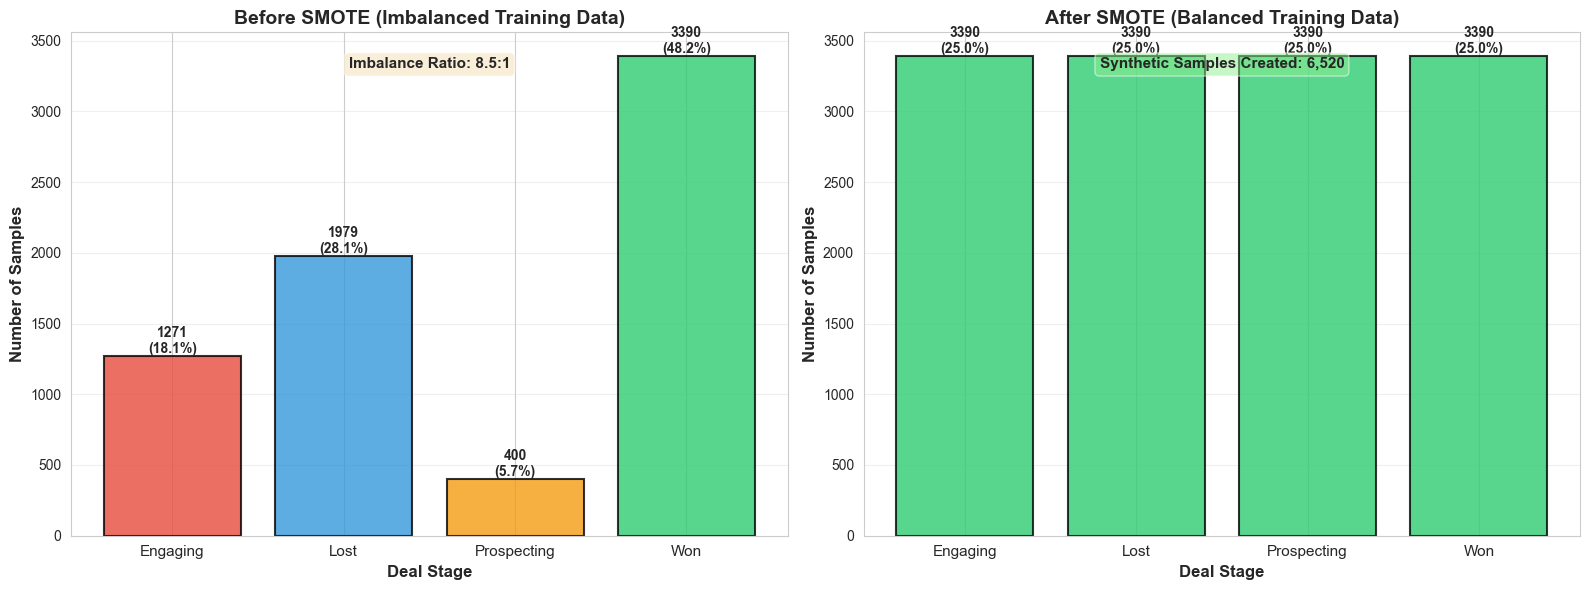


SMOTE Summary:
  Before: 7,040 samples (Imbalance: 8.5:1)
  After: 13,560 samples (Balanced: 1:1)
  Synthetic samples created: 6,520



In [43]:
print("="*80)
print("PART 7: SMOTE VISUALIZATION - CLASS DISTRIBUTION")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np

# Get class distributions
unique_before, counts_before = np.unique(y_train_clf, return_counts=True)
unique_after, counts_after = np.unique(y_train_clf_balanced, return_counts=True)

# Class names
class_names = ['Engaging', 'Lost', 'Prospecting', 'Won']

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before SMOTE
colors_before = ['#e74c3c', '#3498db', '#f39c12', '#2ecc71']
bars1 = axes[0].bar(range(len(unique_before)), counts_before, color=colors_before, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Deal Stage', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_title('Before SMOTE (Imbalanced Training Data)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(unique_before)))
axes[0].set_xticklabels(class_names, fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars1, counts_before)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}\n({count/counts_before.sum()*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

imbalance_ratio = counts_before.max() / counts_before.min()
axes[0].text(0.5, 0.95, f'Imbalance Ratio: {imbalance_ratio:.1f}:1',
            transform=axes[0].transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=11, fontweight='bold')

# After SMOTE
colors_after = ['#2ecc71'] * len(unique_after)
bars2 = axes[1].bar(range(len(unique_after)), counts_after, color=colors_after, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Deal Stage', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1].set_title('After SMOTE (Balanced Training Data)', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(unique_after)))
axes[1].set_xticklabels(class_names, fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars2, counts_after)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}\n({count/counts_after.sum()*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

synthetic_created = counts_after.sum() - counts_before.sum()
axes[1].text(0.5, 0.95, f'Synthetic Samples Created: {synthetic_created:,}',
            transform=axes[1].transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSMOTE Summary:")
print(f"  Before: {counts_before.sum():,} samples (Imbalance: {imbalance_ratio:.1f}:1)")
print(f"  After: {counts_after.sum():,} samples (Balanced: 1:1)")
print(f"  Synthetic samples created: {synthetic_created:,}")
print("\n" + "="*80)

#### 32. Feature Scaling

**Fit scaler on training data, transform both train and test.**

In [44]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
import pandas as pd

print("Feature Scaling")
print("="*70)

scaler_clf = StandardScaler()
scaler_clf.fit(X_train_clf_balanced)

X_train_clf_scaled = scaler_clf.transform(X_train_clf_balanced)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# Convert to DataFrame
X_train_clf_scaled = pd.DataFrame(X_train_clf_scaled, columns=X_train_clf.columns)
X_test_clf_scaled = pd.DataFrame(X_test_clf_scaled, columns=X_test_clf.columns)

print(f"\nTraining scaled: {X_train_clf_scaled.shape}")
print(f"Test scaled: {X_test_clf_scaled.shape}")
print(f"Mean: {X_train_clf_scaled.mean().mean():.6f} (should be ~0)")
print(f"Std: {X_train_clf_scaled.std().mean():.6f} (should be ~1)")
print("\nSCALING COMPLETE")

Feature Scaling

Training scaled: (13560, 69)
Test scaled: (1760, 69)
Mean: -0.000000 (should be ~0)
Std: 1.000037 (should be ~1)

SCALING COMPLETE


#### Summary of Part 7

**Data Preparation Complete:**
- Features prepared: Dropped non-predictive columns
- Train-test split: 80/20 stratified
- SMOTE: Applied to training data only
- Scaling: Fitted on training, transformed both


---
---

#### Part 8: Feature Selection - Hybrid Approach

Reduce from 69 features to 20-30 most predictive features using consensus-based selection.

**Methods:**
1. Filter: ANOVA F-test (statistical significance)
2. Embedded: Random Forest importance (Gini impurity)
3. Embedded: XGBoost importance (gain-based)
4. Wrapper: Permutation Importance (performance-based)
5. Wrapper: RFE (recursive elimination)

**Selection Criteria:** Features with 3+ votes from 5 methods

In [45]:
print("Feature Selection - Data Preparation")
print("="*70)

# Get feature names (scaled data is numpy array, need column names)
feature_names = X_classification.columns.tolist()
print(f"\nTotal features to evaluate: {len(feature_names)}")
print(f"Training samples (post-SMOTE): {X_train_clf_balanced.shape[0]}")
print(f"Target classes: {len(np.unique(y_train_clf_balanced))}")

# Convert scaled training data to DataFrame for easier manipulation
X_train_df = pd.DataFrame(X_train_clf_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_clf_scaled, columns=feature_names)

Feature Selection - Data Preparation

Total features to evaluate: 69
Training samples (post-SMOTE): 13560
Target classes: 4


#### 33. Method 1: ANOVA F-Test (Filter Method)

Statistical test for numerical features in classification. Tests if feature means differ significantly across classes.

- High F-statistic = strong discriminative power
- p-value < 0.05 = statistically significant

This is a fast, model-agnostic method that identifies features with clear class separation

In [46]:
from sklearn.feature_selection import SelectKBest, f_classif

print("Method 1: ANOVA F-Test")
print("="*70)

# Select top 25 features
k_features = 25
anova_selector = SelectKBest(score_func=f_classif, k=k_features)
anova_selector.fit(X_train_df, y_train_clf_balanced)

# Get scores and p-values
anova_scores = pd.DataFrame({
    'feature': feature_names,
    'f_score': anova_selector.scores_,
    'p_value': anova_selector.pvalues_
}).sort_values('f_score', ascending=False)

# Get selected features
anova_selected = anova_scores.head(k_features)['feature'].tolist()

print(f"\nTop 10 features by F-score:")
print(anova_scores.head(10)[['feature', 'f_score', 'p_value']].to_string(index=False))
print(f"\nSelected {len(anova_selected)} features (F-test)")

# Count significant features
significant = (anova_scores['p_value'] < 0.05).sum()
print(f"Features with p < 0.05: {significant}/{len(feature_names)}")

Method 1: ANOVA F-Test

Top 10 features by F-score:
                        feature     f_score  p_value
            engage_week_of_year 5351.172531      0.0
                   engage_month 4692.947426      0.0
           log_sales_cycle_days 4487.959520      0.0
              account_frequency 3881.141955      0.0
         size_cycle_interaction 3583.916645      0.0
revenue_sales_cycle_interaction 3480.546615      0.0
                 engage_quarter 2894.589366      0.0
               sector_technolgy 2255.514264      0.0
              sector_deal_count 1982.178854      0.0
         sector_sales_cycle_std 1935.467504      0.0

Selected 25 features (F-test)
Features with p < 0.05: 63/69


#### 34. Method 2: Random Forest Importance (Embedded Method)

Tree-based importance from ensemble learning.

Importance equals to the average decrease in Gini impurity when feature is used for splitting. This captures non-linear relationships, handles feature interactions naturally, robust to outliers and handles scaling.

In [47]:
from sklearn.ensemble import RandomForestClassifier

print("Method 2: Random Forest Importance")
print("="*70)

# Train Random Forest on balanced training data
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_df, y_train_clf_balanced)

# Get feature importances
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Select top 25 features
rf_selected = rf_importance.head(k_features)['feature'].tolist()

print(f"\nTop 10 features by RF importance:")
print(rf_importance.head(10).to_string(index=False))
print(f"\nSelected {len(rf_selected)} features (Random Forest)")
print(f"Training accuracy: {rf.score(X_train_df, y_train_clf_balanced):.3f}")

Method 2: Random Forest Importance

Top 10 features by RF importance:
               feature  importance
   engage_week_of_year    0.103107
   sales_cycle_squared    0.085581
          engage_month    0.082926
      sales_cycle_days    0.071343
size_cycle_interaction    0.061029
     account_frequency    0.049281
  log_sales_cycle_days    0.048741
business_days_in_cycle    0.043139
           log_revenue    0.038980
        engage_quarter    0.036970

Selected 25 features (Random Forest)
Training accuracy: 0.845


#### 35. Method 3: XGBoost or Gradient Boosting Importance (Embedded Method)

Gradient boosting importance with multiple metrics.

- **Gain:** Average improvement in accuracy when feature is used
- **Weight:** Frequency of feature usage in splits
- **Cover:** Average samples affected by feature splits

In [48]:
# Need to install libomp on MAC to use XGboost 
# # Try XGBoost first, fallback to Gradient Boosting if not available
try:
    from xgboost import XGBClassifier
    use_xgb = True
except (ImportError, Exception) as e:
    from sklearn.ensemble import GradientBoostingClassifier
    use_xgb = False
    print(f"XGBoost not available ({str(e)[:50]}...), using Gradient Boosting instead")

print("Method 3: XGBoost/Gradient Boosting Importance")
print("="*70)

# Train model
if use_xgb:
    model_name = "XGBoost"
    gb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
else:
    model_name = "Gradient Boosting"
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )

gb_model.fit(X_train_df, y_train_clf_balanced)

# Get feature importances
xgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Select top 25 features
xgb_selected = xgb_importance.head(k_features)['feature'].tolist()

print(f"\nTop 10 features by {model_name} importance:")
print(xgb_importance.head(10).to_string(index=False))
print(f"\nSelected {len(xgb_selected)} features ({model_name})")
print(f"Training accuracy: {gb_model.score(X_train_df, y_train_clf_balanced):.3f}")

Method 3: XGBoost/Gradient Boosting Importance

Top 10 features by XGBoost importance:
                        feature  importance
            engage_week_of_year    0.155573
              account_frequency    0.145314
           regional_office_West    0.054100
          quarterly_deal_volume    0.033004
                  log_employees    0.031868
revenue_sales_cycle_interaction    0.030160
            sales_cycle_squared    0.029454
                 engage_quarter    0.026393
         size_cycle_interaction    0.025171
           log_sales_cycle_days    0.024268

Selected 25 features (XGBoost)
Training accuracy: 0.904


#### 36. Method 4: Permutation Importance (Wrapper Method)

Performance-based importance by shuffling features. Measures accuracy drop when feature values are randomly permuted.

- High drop = important feature
- No drop = unimportant feature
- Model-agnostic (works with any algorithm)
- More reliable than built-in importances

In [49]:
from sklearn.inspection import permutation_importance

print("Method 4: Permutation Importance")
print("="*70)

# Use Random Forest model
# Calculate permutation importance on training data 
perm_importance = permutation_importance(
    rf,
    X_train_df,
    y_train_clf_balanced,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Get importance scores
perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

# Select top 25 features
perm_selected = perm_importance_df.head(k_features)['feature'].tolist()

print(f"\nTop 10 features by Permutation Importance:")
print(perm_importance_df.head(10)[['feature', 'importance', 'std']].to_string(index=False))
print(f"\nSelected {len(perm_selected)} features (Permutation)")

# Count significant features (mean - std > 0)
significant_perm = (perm_importance_df['importance'] - perm_importance_df['std'] > 0).sum()
print(f"Features with significant importance: {significant_perm}/{len(feature_names)}")

Method 4: Permutation Importance

Top 10 features by Permutation Importance:
               feature  importance      std
  log_sales_cycle_days    0.035656 0.001490
   sales_cycle_squared    0.035295 0.001422
        engage_quarter    0.021622 0.001338
          engage_month    0.018319 0.001750
      sales_cycle_days    0.016652 0.001363
business_days_in_cycle    0.015081 0.001055
 quarterly_deal_volume    0.014727 0.001187
   monthly_deal_volume    0.014004 0.001149
   engage_week_of_year    0.013746 0.001482
size_cycle_interaction    0.013709 0.002005

Selected 25 features (Permutation)
Features with significant importance: 61/69


#### 37. Method 5: Recursive Feature Elimination (Wrapper Method)

Iterative elimination of weakest features. Finds optimal subset through exhaustive search with cross-validation

1. Train model on all features
2. Rank features by importance
3. Remove weakest feature
4. Repeat until desired number of features



In [50]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

print("Method 5: Recursive Feature Elimination (RFE)")
print("="*70)

# Use Logistic Regression as estimator (faster than RF/XGB)
lr_estimator = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

# RFE to select top 25 features
rfe = RFE(estimator=lr_estimator, n_features_to_select=k_features, step=5)
rfe.fit(X_train_df, y_train_clf_balanced)

# Get selected features
rfe_selected = [feature_names[i] for i in range(len(feature_names)) if rfe.support_[i]]

# Get feature ranking
rfe_ranking = pd.DataFrame({
    'feature': feature_names,
    'ranking': rfe.ranking_,
    'selected': rfe.support_
}).sort_values('ranking')

print(f"\nTop 10 features by RFE ranking:")
print(rfe_ranking.head(10)[['feature', 'ranking']].to_string(index=False))
print(f"\nSelected {len(rfe_selected)} features (RFE)")
print(f"Features eliminated: {len(feature_names) - len(rfe_selected)}")

Method 5: Recursive Feature Elimination (RFE)

Top 10 features by RFE ranking:
               feature  ranking
               revenue        1
      sales_cycle_days        1
          engage_month        1
business_days_in_cycle        1
        engage_quarter        1
           engage_year        1
           company_age        1
   engage_week_of_year        1
           log_revenue        1
         log_employees        1

Selected 25 features (RFE)
Features eliminated: 44


#### 38. Consensus Voting - Final Feature Selection

Combine all 5 methods for robust selection. Features selected by 3+ methods are most reliable.
- Reduces bias from any single method
- High-vote features are robustly important
- Select features with ≥3 votes (60% consensus)

In [51]:
print("Consensus Voting - Final Selection")
print("="*70)

# Create voting DataFrame
feature_votes = pd.DataFrame(index=feature_names)
feature_votes['anova'] = feature_votes.index.isin(anova_selected).astype(int)
feature_votes['random_forest'] = feature_votes.index.isin(rf_selected).astype(int)
feature_votes['xgboost'] = feature_votes.index.isin(xgb_selected).astype(int)
feature_votes['permutation'] = feature_votes.index.isin(perm_selected).astype(int)
feature_votes['rfe'] = feature_votes.index.isin(rfe_selected).astype(int)

# Total votes per feature
feature_votes['total_votes'] = feature_votes.sum(axis=1)
feature_votes = feature_votes.sort_values('total_votes', ascending=False)

# Select features with at least 3 votes
min_votes = 3
final_selected_features = feature_votes[feature_votes['total_votes'] >= min_votes].index.tolist()

print(f"\nVoting Summary:")
print(f"  5 votes (unanimous): {(feature_votes['total_votes'] == 5).sum()} features")
print(f"  4 votes (strong): {(feature_votes['total_votes'] == 4).sum()} features")
print(f"  3 votes (moderate): {(feature_votes['total_votes'] == 3).sum()} features")
print(f"  2 votes (weak): {(feature_votes['total_votes'] == 2).sum()} features")
print(f"  1 vote (very weak): {(feature_votes['total_votes'] == 1).sum()} features")
print(f"  0 votes (not selected): {(feature_votes['total_votes'] == 0).sum()} features")

print(f"\n" + "="*70)
print(f"FINAL SELECTION: {len(final_selected_features)} features (≥{min_votes} votes)")
print("="*70)

# Show top features
print(f"\nTop 30 features by vote count:")
print(feature_votes.head(30).to_string())

Consensus Voting - Final Selection

Voting Summary:
  5 votes (unanimous): 10 features
  4 votes (strong): 7 features
  3 votes (moderate): 4 features
  2 votes (weak): 10 features
  1 vote (very weak): 15 features
  0 votes (not selected): 23 features

FINAL SELECTION: 21 features (≥3 votes)

Top 30 features by vote count:
                                 anova  random_forest  xgboost  permutation  rfe  total_votes
log_sales_cycle_days                 1              1        1            1    1            5
sales_cycle_squared                  1              1        1            1    1            5
engage_week_of_year                  1              1        1            1    1            5
engage_quarter                       1              1        1            1    1            5
engage_month                         1              1        1            1    1            5
agent_avg_customer_size              1              1        1            1    1            5
agent_avg_custom

#### 39. Feature Selection Visualization

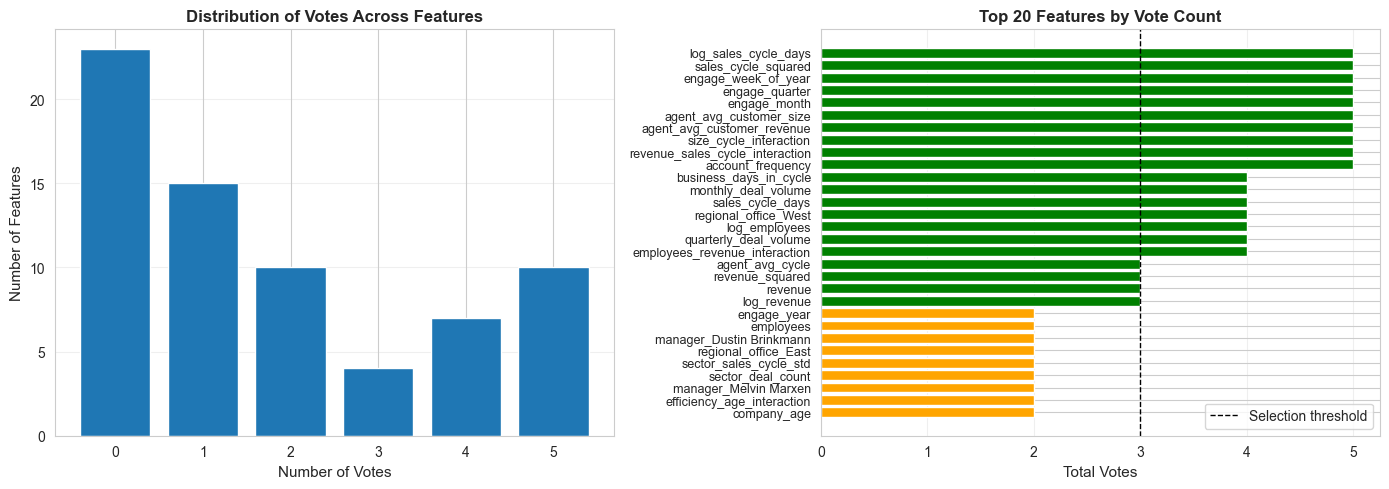

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Vote distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of votes
axes[0].bar(range(6), [(feature_votes['total_votes'] == i).sum() for i in range(6)])
axes[0].set_xlabel('Number of Votes', fontsize=11)
axes[0].set_ylabel('Number of Features', fontsize=11)
axes[0].set_title('Distribution of Votes Across Features', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(6))
axes[0].grid(axis='y', alpha=0.3)

# Top 30 features by votes
top_30 = feature_votes.head(30)
colors = ['green' if v >= 3 else 'orange' if v == 2 else 'red' for v in top_30['total_votes']]
axes[1].barh(range(len(top_30)), top_30['total_votes'], color=colors)
axes[1].set_yticks(range(len(top_30)))
axes[1].set_yticklabels(top_30.index, fontsize=9)
axes[1].set_xlabel('Total Votes', fontsize=11)
axes[1].set_title('Top 20 Features by Vote Count', fontsize=12, fontweight='bold')
axes[1].axvline(x=3, color='black', linestyle='--', linewidth=1, label='Selection threshold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

---

## Part 9: Classification Models

The objective of this part is to build robust classification models to predict `deal_stage` using the 21 selected features.

**Models:**
1. **Random Forest Classifier** - Ensemble method handling non-linear relationships
2. **Gradient Boosting Classifier** - Sequential error correction for high accuracy
3. **Logistic Regression** - Linear baseline with regularization

**Strategy:**
- **Reduced iterations**: 20 iterations per RandomizedSearchCV (balance speed vs coverage)
- **5-fold stratified CV**: Maintains class distribution
- **Primary metric**: F1-score (balanced precision/recall)


In [53]:
print("="*80)
print("APPLYING FEATURE SELECTION FILTER")
print("="*80)

# Check if we have the selected features
if 'final_selected_features' not in locals():
    print("ERROR: final_selected_features not found! Part 8 may not have run.")
    raise ValueError("Cannot proceed without feature selection results")

print(f"\nFeatures selected in Part 8: {len(final_selected_features)}")
print(f"\nSelected features:")
for i, feat in enumerate(final_selected_features, 1):
    print(f"  {i:2d}. {feat}")

# Check data type
import pandas as pd
import numpy as np

is_dataframe = isinstance(X_train_clf_scaled, pd.DataFrame)
print(f"\nCurrent data type: {'DataFrame' if is_dataframe else 'NumPy array'}")

# Current shapes before filtering
print(f"\n" + "-"*80)
print(f"Before the Feature Selection Filter:")
print(f"  X_train_clf_scaled shape: {X_train_clf_scaled.shape}")
print(f"  X_test_clf_scaled shape:  {X_test_clf_scaled.shape}")
print(f"  feature_names length:     {len(feature_names)}")

# Get column indices for selected features
print(f"\n" + "-"*80)
print(f"Finding column indices for selected features...")
selected_indices = []
for feat in final_selected_features:
    if feat in feature_names:
        idx = feature_names.index(feat)
        selected_indices.append(idx)
    else:
        print(f"  WARNING: Feature '{feat}' not found in feature_names!")

print(f"Found {len(selected_indices)} matching features")

# Filter the datasets 
print(f"\nFiltering datasets to selected features...")

if is_dataframe:
    # DataFrame - use iloc for column selection
    print("Using DataFrame.iloc for column selection...")
    X_train_clf_scaled = X_train_clf_scaled.iloc[:, selected_indices]
    X_test_clf_scaled = X_test_clf_scaled.iloc[:, selected_indices]
    
    # Convert to NumPy array for sklearn compatibility
    print("Converting to NumPy arrays for sklearn compatibility...")
    X_train_clf_scaled = X_train_clf_scaled.values
    X_test_clf_scaled = X_test_clf_scaled.values
else:
    # NumPy array - use standard indexing
    print("Using NumPy array indexing...")
    X_train_clf_scaled = X_train_clf_scaled[:, selected_indices]
    X_test_clf_scaled = X_test_clf_scaled[:, selected_indices]

# Update feature_names to only selected features
feature_names = final_selected_features.copy()

# Verify shapes after filtering
print(f"\n" + "-"*80)
print(f"After the Feature Selection Filter:")
print(f"  X_train_clf_scaled shape: {X_train_clf_scaled.shape} ✓")
print(f"  X_test_clf_scaled shape:  {X_test_clf_scaled.shape} ✓")
print(f"  feature_names length:     {len(feature_names)} ✓")
print(f"  Data type: {type(X_train_clf_scaled).__name__} (NumPy array for sklearn)")

# Verification
expected_cols = len(final_selected_features)
assert X_train_clf_scaled.shape[1] == expected_cols, f"Train feature count mismatch! Expected {expected_cols}, got {X_train_clf_scaled.shape[1]}"
assert X_test_clf_scaled.shape[1] == expected_cols, f"Test feature count mismatch! Expected {expected_cols}, got {X_test_clf_scaled.shape[1]}"
assert len(feature_names) == expected_cols, f"Feature names mismatch! Expected {expected_cols}, got {len(feature_names)}"
assert isinstance(X_train_clf_scaled, np.ndarray), "Data should be NumPy array after conversion"
assert isinstance(X_test_clf_scaled, np.ndarray), "Data should be NumPy array after conversion"

print(f"\n" + "="*80)
print(f"✓ FEATURE SELECTION SUCCESSFULLY APPLIED!")
print(f"  - Reduced from 69 → {len(final_selected_features)} features")
print(f"  - Converted to NumPy arrays for sklearn compatibility")
print("="*80)

APPLYING FEATURE SELECTION FILTER

Features selected in Part 8: 21

Selected features:
   1. log_sales_cycle_days
   2. sales_cycle_squared
   3. engage_week_of_year
   4. engage_quarter
   5. engage_month
   6. agent_avg_customer_size
   7. agent_avg_customer_revenue
   8. size_cycle_interaction
   9. revenue_sales_cycle_interaction
  10. account_frequency
  11. business_days_in_cycle
  12. monthly_deal_volume
  13. sales_cycle_days
  14. regional_office_West
  15. log_employees
  16. quarterly_deal_volume
  17. employees_revenue_interaction
  18. agent_avg_cycle
  19. revenue_squared
  20. revenue
  21. log_revenue

Current data type: DataFrame

--------------------------------------------------------------------------------
Before the Feature Selection Filter:
  X_train_clf_scaled shape: (13560, 69)
  X_test_clf_scaled shape:  (1760, 69)
  feature_names length:     69

--------------------------------------------------------------------------------
Finding column indices for selecte

In [54]:
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

print("="*80)
print("PART 9: CLASSIFICATION MODELS - DATA PREPARATION")
print("="*80)

print(f"\nTraining Set (post-SMOTE):")
print(f"  Shape: {X_train_clf_scaled.shape}")
print(f"  Samples: {len(y_train_clf_balanced)}")
print(f"  Class distribution: {np.bincount(y_train_clf_balanced)}")

print(f"\nTest Set (original):")
print(f"  Shape: {X_test_clf_scaled.shape}")
print(f"  Samples: {len(y_test_clf)}")
print(f"  Class distribution: {np.bincount(y_test_clf)}")

print(f"\nFeatures: {len(feature_names)} selected features")

# Detect number of classes and set averaging method
n_classes = len(np.unique(y_train_clf_balanced))
unique_classes = np.unique(y_train_clf_balanced)
print(f"\nTarget Analysis:")
print(f"  Variable: deal_stage")
print(f"  Classes: {n_classes}")
print(f"  Unique values: {unique_classes}")

# Determine F1-score averaging method
if n_classes == 2:
    f1_average = 'binary'
    print(f"  Classification type: BINARY")
else:
    f1_average = 'weighted'
    print(f"  Classification type: MULTICLASS")

print(f"  F1-score averaging: '{f1_average}'")
print(f"\nPrimary Metric: F1-Score ({f1_average} averaging)")
print(f"Cross-Validation: 5-fold stratified")
print(f"Iterations: 20 per RandomizedSearchCV")
print("="*80)

PART 9: CLASSIFICATION MODELS - DATA PREPARATION

Training Set (post-SMOTE):
  Shape: (13560, 21)
  Samples: 13560
  Class distribution: [3390 3390 3390 3390]

Test Set (original):
  Shape: (1760, 21)
  Samples: 1760
  Class distribution: [318 494 100 848]

Features: 21 selected features

Target Analysis:
  Variable: deal_stage
  Classes: 4
  Unique values: [0 1 2 3]
  Classification type: MULTICLASS
  F1-score averaging: 'weighted'

Primary Metric: F1-Score (weighted averaging)
Cross-Validation: 5-fold stratified
Iterations: 20 per RandomizedSearchCV


---

### 9.1 Random Forest Classifier

**Why Random Forest:**
- Handles non-linear relationships and feature interactions
- Robust to outliers (revenue, employee count)
- Resistant to overfitting through ensemble averaging
- Provides feature importance for XAI 

**Plan:**
1. RandomizedSearchCV (20 iterations)
2. GridSearchCV fine-tuning 
3. Final model training & evaluation 

In [55]:
print("="*80)
print("9.1.1 RANDOM FOREST - RANDOMIZED SEARCH (20 iterations)")
print("="*80)

rf_param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

print("\nHyperparameter Search Space:")
total_combinations = 1
for param, values in rf_param_distributions.items():
    print(f"  {param}: {len(values)} options")
    total_combinations *= len(values)
print(f"\nTotal combinations: {total_combinations}")
print(f"Testing: 20 random combinations (5-fold CV each)")
print(f"Total fits: 20 iterations × 5 folds = 100 model fits")
print(f"\nStarting RandomizedSearchCV... (progress shown below)\n")

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_param_distributions,
    n_iter=20, 
    cv=5,
    scoring='f1_weighted' if f1_average == 'weighted' else 'f1',
    n_jobs=1,  # Let RandomForest use all cores, not CV
    random_state=42,
    verbose=2  # Show progress
)

start_time = time.time()
rf_random.fit(X_train_clf_scaled, y_train_clf_balanced)
rf_random_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"RandomizedSearchCV completed in {rf_random_time/60:.1f} minutes ({rf_random_time:.1f} seconds)")
print(f"Best CV F1-Score: {rf_random.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")
print("="*80)

9.1.1 RANDOM FOREST - RANDOMIZED SEARCH (20 iterations)

Hyperparameter Search Space:
  n_estimators: 3 options
  max_depth: 4 options
  min_samples_split: 4 options
  min_samples_leaf: 4 options
  max_features: 2 options
  class_weight: 2 options

Total combinations: 768
Testing: 20 random combinations (5-fold CV each)
Total fits: 20 iterations × 5 folds = 100 model fits

Starting RandomizedSearchCV... (progress shown below)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END class_weight=None, max_depth=30, max_features=log2, min_samples_leaf=10, mi

In [56]:
print("="*80)
print("9.1.2 RANDOM FOREST - GRID SEARCH (Fine-tuning)")
print("="*80)

# Create focused grid around best parameters
best_n_estimators = rf_random.best_params_['n_estimators']
best_max_depth = rf_random.best_params_['max_depth']
best_min_samples_split = rf_random.best_params_['min_samples_split']
best_min_samples_leaf = rf_random.best_params_['min_samples_leaf']

# Create narrow grid around best values
if best_max_depth is None:
    depth_range = [None]
else:
    depth_range = [max(5, best_max_depth-5), best_max_depth, best_max_depth+5]

rf_param_grid = {
    'n_estimators': [best_n_estimators],
    'max_depth': depth_range,
    'min_samples_split': [max(2, best_min_samples_split-2), best_min_samples_split],
    'min_samples_leaf': [max(1, best_min_samples_leaf-1), best_min_samples_leaf],
    'max_features': [rf_random.best_params_['max_features']],
    'class_weight': [rf_random.best_params_['class_weight']]
}

grid_combinations = 1
print("\nFine-tuning Grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")
    grid_combinations *= len(values)
print(f"\nGrid combinations: {grid_combinations}")
print(f"Total fits: {grid_combinations} × 5 folds = {grid_combinations * 5}")
print(f"\nStarting GridSearchCV...\n")

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,
    scoring='f1_weighted' if f1_average == 'weighted' else 'f1',
    n_jobs=1,
    verbose=2
)

start_time = time.time()
rf_grid.fit(X_train_clf_scaled, y_train_clf_balanced)
rf_grid_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"GridSearchCV completed in {rf_grid_time:.1f} seconds")
print(f"Best CV F1-Score: {rf_grid.best_score_:.4f}")
print(f"Improvement: {rf_grid.best_score_ - rf_random.best_score_:+.4f}")
print(f"\nFinal Best Parameters:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")
print("="*80)

9.1.2 RANDOM FOREST - GRID SEARCH (Fine-tuning)

Fine-tuning Grid:
  n_estimators: [200]
  max_depth: [15, 20, 25]
  min_samples_split: [3, 5]
  min_samples_leaf: [1, 1]
  max_features: ['log2']
  class_weight: ['balanced']

Grid combinations: 12
Total fits: 12 × 5 folds = 60

Starting GridSearchCV...

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=15, max_features=log2

In [57]:
print("="*80)
print("9.1.3 RANDOM FOREST - FINAL MODEL EVALUATION")
print("="*80)

# Get best model
rf_best_model = rf_grid.best_estimator_

# Predictions
print("\nGenerating predictions")
y_train_pred_rf = rf_best_model.predict(X_train_clf_scaled)
y_test_pred_rf = rf_best_model.predict(X_test_clf_scaled)

if n_classes == 2:
    y_test_pred_proba_rf = rf_best_model.predict_proba(X_test_clf_scaled)[:, 1]
else:
    y_test_pred_proba_rf = rf_best_model.predict_proba(X_test_clf_scaled)

# Evaluate
rf_train_f1 = f1_score(y_train_clf_balanced, y_train_pred_rf, average=f1_average)
rf_test_accuracy = accuracy_score(y_test_clf, y_test_pred_rf)
rf_test_precision = precision_score(y_test_clf, y_test_pred_rf, average=f1_average)
rf_test_recall = recall_score(y_test_clf, y_test_pred_rf, average=f1_average)
rf_test_f1 = f1_score(y_test_clf, y_test_pred_rf, average=f1_average)

print("\nPerformance Summary:")
print(f"\nTraining Set:")
print(f"  F1-Score: {rf_train_f1:.4f}")
print(f"\nTest Set:")
print(f"  Accuracy:  {rf_test_accuracy:.4f}")
print(f"  Precision: {rf_test_precision:.4f}")
print(f"  Recall:    {rf_test_recall:.4f}")
print(f"  F1-Score:  {rf_test_f1:.4f}")
print(f"\nGeneralization:")
print(f"  Train-Test F1 Gap: {rf_train_f1 - rf_test_f1:.4f}")
if rf_train_f1 - rf_test_f1 < 0.05:
    print(f"  Status: Good generalization (gap < 0.05)")
elif rf_train_f1 - rf_test_f1 < 0.10:
    print(f"  Status: Acceptable (gap < 0.10)")
else:
    print(f"  Status: Possible overfitting (gap ≥ 0.10)")
print("="*80)
print("Random Forest training complete!")
print("="*80)

9.1.3 RANDOM FOREST - FINAL MODEL EVALUATION

Generating predictions

Performance Summary:

Training Set:
  F1-Score: 0.9867

Test Set:
  Accuracy:  0.6534
  Precision: 0.6455
  Recall:    0.6534
  F1-Score:  0.6463

Generalization:
  Train-Test F1 Gap: 0.3405
  Status: Possible overfitting (gap ≥ 0.10)
Random Forest training complete!


---

### 9.2 Gradient Boosting Classifier

**Gradient Boosting:**
- Sequential error correction improves accuracy
- Excellent for tabular data (CRM sales)

**Plan:**
1. RandomizedSearchCV (20 iterations)
2. GridSearchCV fine-tuning
3. Final model evaluation 

In [58]:
# Check XGBoost availability
use_xgboost = False
try:
    from xgboost import XGBClassifier
    use_xgboost = True
except:
    use_xgboost = False

print("="*80)
print(f"9.2.1 GRADIENT BOOSTING - RANDOMIZED SEARCH (20 iterations)")
print(f"Implementation: {'XGBoost' if use_xgboost else 'sklearn GradientBoosting'}")
print("="*80)

gb_param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'subsample': [0.8, 0.9, 1.0]
}

print("\nHyperparameter Search Space:")
for param, values in gb_param_distributions.items():
    print(f"  {param}: {len(values)} options")
print(f"\nTesting: 20 random combinations x 5 folds = 100 fits")
print(f"\nStarting RandomizedSearchCV\n")

gb_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=gb_param_distributions,
    n_iter=20,
    cv=5,
    scoring='f1_weighted' if f1_average == 'weighted' else 'f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

start_time = time.time()
gb_random.fit(X_train_clf_scaled, y_train_clf_balanced)
gb_random_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"Best CV F1-Score: {gb_random.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in gb_random.best_params_.items():
    print(f"  {param}: {value}")
print("="*80)

9.2.1 GRADIENT BOOSTING - RANDOMIZED SEARCH (20 iterations)
Implementation: XGBoost

Hyperparameter Search Space:
  n_estimators: 3 options
  learning_rate: 3 options
  max_depth: 3 options
  min_samples_split: 3 options
  min_samples_leaf: 3 options
  subsample: 3 options

Testing: 20 random combinations x 5 folds = 100 fits

Starting RandomizedSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, subsample=0.8; total time=  57.2s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, subsample=0.8; total time=  57.2s
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, subsample=0.8; total time= 1.0min
[CV] END learning_rate=0.05, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, subsample=0.8; total time= 1.1min
[CV] END learning_rate=0.05, max_depth=7

In [59]:
print("="*80)
print("9.2.2 GRADIENT BOOSTING - GRID SEARCH (Fine-tuning)")
print("="*80)

best_max_depth = gb_random.best_params_['max_depth']

gb_param_grid = {
    'n_estimators': [gb_random.best_params_['n_estimators']],
    'learning_rate': [gb_random.best_params_['learning_rate']],
    'max_depth': [max(1, best_max_depth-1), best_max_depth],
    'min_samples_split': [gb_random.best_params_['min_samples_split']],
    'min_samples_leaf': [gb_random.best_params_['min_samples_leaf']],
    'subsample': [gb_random.best_params_['subsample']]
}

print("\nFine-tuning Grid:")
grid_combinations = 1
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")
    grid_combinations *= len(values)
print(f"\nGrid combinations: {grid_combinations} × 5 folds = {grid_combinations * 5} fits")
print(f"\nStarting GridSearchCV...\n")

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_param_grid,
    cv=5,
    scoring='f1_weighted' if f1_average == 'weighted' else 'f1',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
gb_grid.fit(X_train_clf_scaled, y_train_clf_balanced)
gb_grid_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"GridSearchCV completed in {gb_grid_time:.1f} seconds")
print(f"Best CV F1-Score: {gb_grid.best_score_:.4f}")
print(f"Improvement: {gb_grid.best_score_ - gb_random.best_score_:+.4f}")
print(f"\nFinal Best Parameters:")
for param, value in gb_grid.best_params_.items():
    print(f"  {param}: {value}")
print("="*80)

9.2.2 GRADIENT BOOSTING - GRID SEARCH (Fine-tuning)

Fine-tuning Grid:
  n_estimators: [300]
  learning_rate: [0.1]
  max_depth: [6, 7]
  min_samples_split: [2]
  min_samples_leaf: [5]
  subsample: [0.9]

Grid combinations: 2 × 5 folds = 10 fits

Starting GridSearchCV...

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=300, subsample=0.9; total time= 2.2min
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=300, subsample=0.9; total time= 2.3min
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=300, subsample=0.9; total time= 2.4min
[CV] END learning_rate=0.1, max_depth=6, min_samples_leaf=5, min_samples_split=2, n_estimators=300, subsample=0.9; total time= 2.5min
[CV] END learning_rate=0.1, max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300, subsample=0.9; total time= 2.5m

In [60]:
print("="*80)
print("9.2.3 GRADIENT BOOSTING - FINAL MODEL EVALUATION")
print("="*80)

gb_best_model = gb_grid.best_estimator_

print("\nGenerating predictions")
y_train_pred_gb = gb_best_model.predict(X_train_clf_scaled)
y_test_pred_gb = gb_best_model.predict(X_test_clf_scaled)

if n_classes == 2:
    y_test_pred_proba_gb = gb_best_model.predict_proba(X_test_clf_scaled)[:, 1]
else:
    y_test_pred_proba_gb = gb_best_model.predict_proba(X_test_clf_scaled)

gb_train_f1 = f1_score(y_train_clf_balanced, y_train_pred_gb, average=f1_average)
gb_test_accuracy = accuracy_score(y_test_clf, y_test_pred_gb)
gb_test_precision = precision_score(y_test_clf, y_test_pred_gb, average=f1_average)
gb_test_recall = recall_score(y_test_clf, y_test_pred_gb, average=f1_average)
gb_test_f1 = f1_score(y_test_clf, y_test_pred_gb, average=f1_average)

print("\nPerformance Summary:")
print(f"\nTraining Set:")
print(f"  F1-Score: {gb_train_f1:.4f}")
print(f"\nTest Set:")
print(f"  Accuracy:  {gb_test_accuracy:.4f}")
print(f"  Precision: {gb_test_precision:.4f}")
print(f"  Recall:    {gb_test_recall:.4f}")
print(f"  F1-Score:  {gb_test_f1:.4f}")
print(f"\nGeneralization:")
print(f"  Train-Test F1 Gap: {gb_train_f1 - gb_test_f1:.4f}")
if gb_train_f1 - gb_test_f1 < 0.05:
    print(f"  Status: Good generalization")
elif gb_train_f1 - gb_test_f1 < 0.10:
    print(f"  Status: Acceptable")
else:
    print(f"  Status: Possible overfitting")
print("="*80)
print("Gradient Boosting training complete!")
print("="*80)

9.2.3 GRADIENT BOOSTING - FINAL MODEL EVALUATION

Generating predictions

Performance Summary:

Training Set:
  F1-Score: 0.9993

Test Set:
  Accuracy:  0.6506
  Precision: 0.6461
  Recall:    0.6506
  F1-Score:  0.6470

Generalization:
  Train-Test F1 Gap: 0.3523
  Status: Possible overfitting
Gradient Boosting training complete!


---

### 9.3 Logistic Regression

**Logistic Regression:**
- Linear baseline for comparison
- Fast training (much faster than RF/GB)
- Highly interpretable (coefficient weights)
- Regularization prevents overfitting

**Execution Plan:**
1. RandomizedSearchCV (20 iterations!)
2. GridSearchCV fine-tuning
3. Final model + coefficient interpretation

In [61]:
print("="*80)
print("9.3.1 LOGISTIC REGRESSION - RANDOMIZED SEARCH (20 iterations)")
print("="*80)

lr_param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter': [1000],
    'class_weight': ['balanced', None]
}

print("\nHyperparameter Search Space:")
for param, values in lr_param_distributions.items():
    print(f"  {param}: {len(values)} options")
print(f"\nTesting: 20 random combinations x 5 folds = 100 fits")
print(f"\nStarting RandomizedSearchCV\n")

lr_random = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=lr_param_distributions,
    n_iter=20,
    cv=5,
    scoring='f1_weighted' if f1_average == 'weighted' else 'f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

start_time = time.time()
lr_random.fit(X_train_clf_scaled, y_train_clf_balanced)
lr_random_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"Best CV F1-Score: {lr_random.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in lr_random.best_params_.items():
    print(f"  {param}: {value}")
print("="*80)

9.3.1 LOGISTIC REGRESSION - RANDOMIZED SEARCH (20 iterations)

Hyperparameter Search Space:
  C: 6 options
  penalty: 2 options
  solver: 1 options
  max_iter: 1 options
  class_weight: 2 options

Testing: 20 random combinations x 5 folds = 100 fits

Starting RandomizedSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END C=0.1, class_weight=balanced, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s
[CV] END C=0.001, class_weight=balanced, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=1000, penalty=l1, solver=saga; total time=   3.7s
[CV] END C=0.1, class_weight=balanced, max_iter=1000, penalty=l1, solver=saga; total time=   3.8s
[CV] END C=0.001, class_weight=balanced, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END C=0.001, class_weight=balanced, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END C=0.001, class_weight=balanced, max_iter=1000, penalty=

In [62]:
print("="*80)
print("9.3.2 LOGISTIC REGRESSION - GRID SEARCH (Fine-tuning)")
print("="*80)

best_C = lr_random.best_params_['C']
C_range_map = {
    0.001: [0.001, 0.005],
    0.01: [0.01, 0.05],
    0.1: [0.1, 0.5],
    1: [1, 5],
    10: [10, 50],
    100: [100]
}

lr_param_grid = {
    'C': C_range_map.get(best_C, [best_C]),
    'penalty': [lr_random.best_params_['penalty']],
    'solver': ['saga'],
    'max_iter': [1000],
    'class_weight': [lr_random.best_params_['class_weight']]
}

print("\nFine-tuning Grid:")
for param, values in lr_param_grid.items():
    print(f"  {param}: {values}")
print(f"\nStarting GridSearchCV...\n")

lr_grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=lr_param_grid,
    cv=5,
    scoring='f1_weighted' if f1_average == 'weighted' else 'f1',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
lr_grid.fit(X_train_clf_scaled, y_train_clf_balanced)
lr_grid_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"Best CV F1-Score: {lr_grid.best_score_:.4f}")
print(f"Improvement: {lr_grid.best_score_ - lr_random.best_score_:+.4f}")
print(f"\nFinal Best Parameters:")
for param, value in lr_grid.best_params_.items():
    print(f"  {param}: {value}")
print("="*80)

9.3.2 LOGISTIC REGRESSION - GRID SEARCH (Fine-tuning)

Fine-tuning Grid:
  C: [1, 5]
  penalty: ['l2']
  solver: ['saga']
  max_iter: [1000]
  class_weight: ['balanced']

Starting GridSearchCV...

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END C=1, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga; total time=   6.8s
[CV] END C=1, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga; total time=   7.0s
[CV] END C=1, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga; total time=   7.2s
[CV] END C=1, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga; total time=   7.3s
[CV] END C=1, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga; total time=   7.4s
[CV] END C=5, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga; total time=  10.7s
[CV] END C=5, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga; total time=  10.7s
[CV] END C=5, class_weight=balanced, max_iter=1000, penalty=l2, solver=

In [63]:
print("="*80)
print("9.3.3 LOGISTIC REGRESSION - FINAL MODEL EVALUATION")
print("="*80)

lr_best_model = lr_grid.best_estimator_

print("\nGenerating predictions...")
y_train_pred_lr = lr_best_model.predict(X_train_clf_scaled)
y_test_pred_lr = lr_best_model.predict(X_test_clf_scaled)

if n_classes == 2:
    y_test_pred_proba_lr = lr_best_model.predict_proba(X_test_clf_scaled)[:, 1]
else:
    y_test_pred_proba_lr = lr_best_model.predict_proba(X_test_clf_scaled)

lr_train_f1 = f1_score(y_train_clf_balanced, y_train_pred_lr, average=f1_average)
lr_test_accuracy = accuracy_score(y_test_clf, y_test_pred_lr)
lr_test_precision = precision_score(y_test_clf, y_test_pred_lr, average=f1_average)
lr_test_recall = recall_score(y_test_clf, y_test_pred_lr, average=f1_average)
lr_test_f1 = f1_score(y_test_clf, y_test_pred_lr, average=f1_average)

print("\nPerformance Summary:")
print(f"\nTraining Set:")
print(f"  F1-Score: {lr_train_f1:.4f}")
print(f"\nTest Set:")
print(f"  Accuracy:  {lr_test_accuracy:.4f}")
print(f"  Precision: {lr_test_precision:.4f}")
print(f"  Recall:    {lr_test_recall:.4f}")
print(f"  F1-Score:  {lr_test_f1:.4f}")
print(f"\nGeneralization:")
print(f"  Train-Test F1 Gap: {lr_train_f1 - lr_test_f1:.4f}")
if lr_train_f1 - lr_test_f1 < 0.05:
    print(f"  Status: Good generalization")
elif lr_train_f1 - lr_test_f1 < 0.10:
    print(f"  Status: Acceptable")
else:
    print(f"  Status: Possible overfitting")

# Feature coefficients (interpretability)
if hasattr(lr_best_model, 'coef_'):
    print("\n" + "-"*80)
    print("Feature Importance (Linear Coefficients):")
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': lr_best_model.coef_[0]
    }).sort_values('Coefficient', key=abs, ascending=False)
    print("\nTop 10 Most Influential Features:")
    print(coef_df.head(10).to_string(index=False))
    print("\n(Positive coefficient = increases Win probability)")
    print("(Negative coefficient = decreases Win probability)")

print(f"\nTotal Training Time: {(lr_random_time + lr_grid_time):.1f} seconds")
print("="*80)
print("✓ Logistic Regression training complete!")
print("="*80)

9.3.3 LOGISTIC REGRESSION - FINAL MODEL EVALUATION

Generating predictions...

Performance Summary:

Training Set:
  F1-Score: 0.7003

Test Set:
  Accuracy:  0.5824
  Precision: 0.5901
  Recall:    0.5824
  F1-Score:  0.5839

Generalization:
  Train-Test F1 Gap: 0.1164
  Status: Possible overfitting

--------------------------------------------------------------------------------
Feature Importance (Linear Coefficients):

Top 10 Most Influential Features:
                      Feature  Coefficient
                 engage_month    -2.527407
         log_sales_cycle_days     1.898432
employees_revenue_interaction    -1.668178
          engage_week_of_year    -1.461843
            account_frequency     1.427849
       size_cycle_interaction     0.982172
                log_employees     0.816412
               engage_quarter     0.597886
      agent_avg_customer_size     0.538728
       business_days_in_cycle    -0.499296

(Positive coefficient = increases Win probability)
(Negative coeff

In [64]:
print("="*80)
print("PART 9: CLASSIFICATION MODELS COMPARISON")
print("="*80)

# Calculate ROC-AUC
if n_classes == 2:
    rf_roc_auc = roc_auc_score(y_test_clf, y_test_pred_proba_rf)
    gb_roc_auc = roc_auc_score(y_test_clf, y_test_pred_proba_gb)
    lr_roc_auc = roc_auc_score(y_test_clf, y_test_pred_proba_lr)
else:
    rf_roc_auc = roc_auc_score(y_test_clf, y_test_pred_proba_rf, multi_class='ovr', average='weighted')
    gb_roc_auc = roc_auc_score(y_test_clf, y_test_pred_proba_gb, multi_class='ovr', average='weighted')
    lr_roc_auc = roc_auc_score(y_test_clf, y_test_pred_proba_lr, multi_class='ovr', average='weighted')

# Comparison table
comparison_data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Logistic Regression'],
    'Accuracy': [rf_test_accuracy, gb_test_accuracy, lr_test_accuracy],
    'Precision': [rf_test_precision, gb_test_precision, lr_test_precision],
    'Recall': [rf_test_recall, gb_test_recall, lr_test_recall],
    'F1-Score': [rf_test_f1, gb_test_f1, lr_test_f1],
    'ROC-AUC': [rf_roc_auc, gb_roc_auc, lr_roc_auc],
    'Train F1': [rf_train_f1, gb_train_f1, lr_train_f1],
    'Overfit Gap': [
        rf_train_f1 - rf_test_f1,
        gb_train_f1 - gb_test_f1,
        lr_train_f1 - lr_test_f1
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print(f"\nTest Set Performance:")
print("\n" + comparison_df.to_string(index=False))

print("\n" + "-"*80)
print("Best Model per Metric:")
print(f"  Accuracy:  {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']} ({comparison_df['Accuracy'].max():.4f})")
print(f"  Precision: {comparison_df.loc[comparison_df['Precision'].idxmax(), 'Model']} ({comparison_df['Precision'].max():.4f})")
print(f"  Recall:    {comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']} ({comparison_df['Recall'].max():.4f})")
print(f"  F1-Score:  {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']} ({comparison_df['F1-Score'].max():.4f})")
print(f"  ROC-AUC:   {comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']} ({comparison_df['ROC-AUC'].max():.4f})")

# Best overall
best_idx = comparison_df['F1-Score'].idxmax()
print("\n" + "="*80)
print(f"BEST MODEL: {comparison_df.loc[best_idx, 'Model']}")
print(f"  F1-Score: {comparison_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"  ROC-AUC: {comparison_df.loc[best_idx, 'ROC-AUC']:.4f}")
print("="*80)

# Store for later parts
classification_models = {
    'Random Forest': rf_best_model,
    'Gradient Boosting': gb_best_model,
    'Logistic Regression': lr_best_model
}

classification_predictions = {
    'Random Forest': {'y_pred': y_test_pred_rf, 'y_pred_proba': y_test_pred_proba_rf},
    'Gradient Boosting': {'y_pred': y_test_pred_gb, 'y_pred_proba': y_test_pred_proba_gb},
    'Logistic Regression': {'y_pred': y_test_pred_lr, 'y_pred_proba': y_test_pred_proba_lr}
}

classification_metrics = comparison_df.copy()


PART 9: CLASSIFICATION MODELS COMPARISON

Test Set Performance:

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train F1  Overfit Gap
      Random Forest  0.653409   0.645523 0.653409  0.646259 0.777156  0.986726     0.340467
  Gradient Boosting  0.650568   0.646081 0.650568  0.647017 0.783211  0.999336     0.352319
Logistic Regression  0.582386   0.590064 0.582386  0.583928 0.754315  0.700306     0.116378

--------------------------------------------------------------------------------
Best Model per Metric:
  Accuracy:  Random Forest (0.6534)
  Precision: Gradient Boosting (0.6461)
  Recall:    Random Forest (0.6534)
  F1-Score:  Gradient Boosting (0.6470)
  ROC-AUC:   Gradient Boosting (0.7832)

BEST MODEL: Gradient Boosting
  F1-Score: 0.6470
  ROC-AUC: 0.7832


PART 9: CLASSIFICATION RESULTS VISUALIZATION


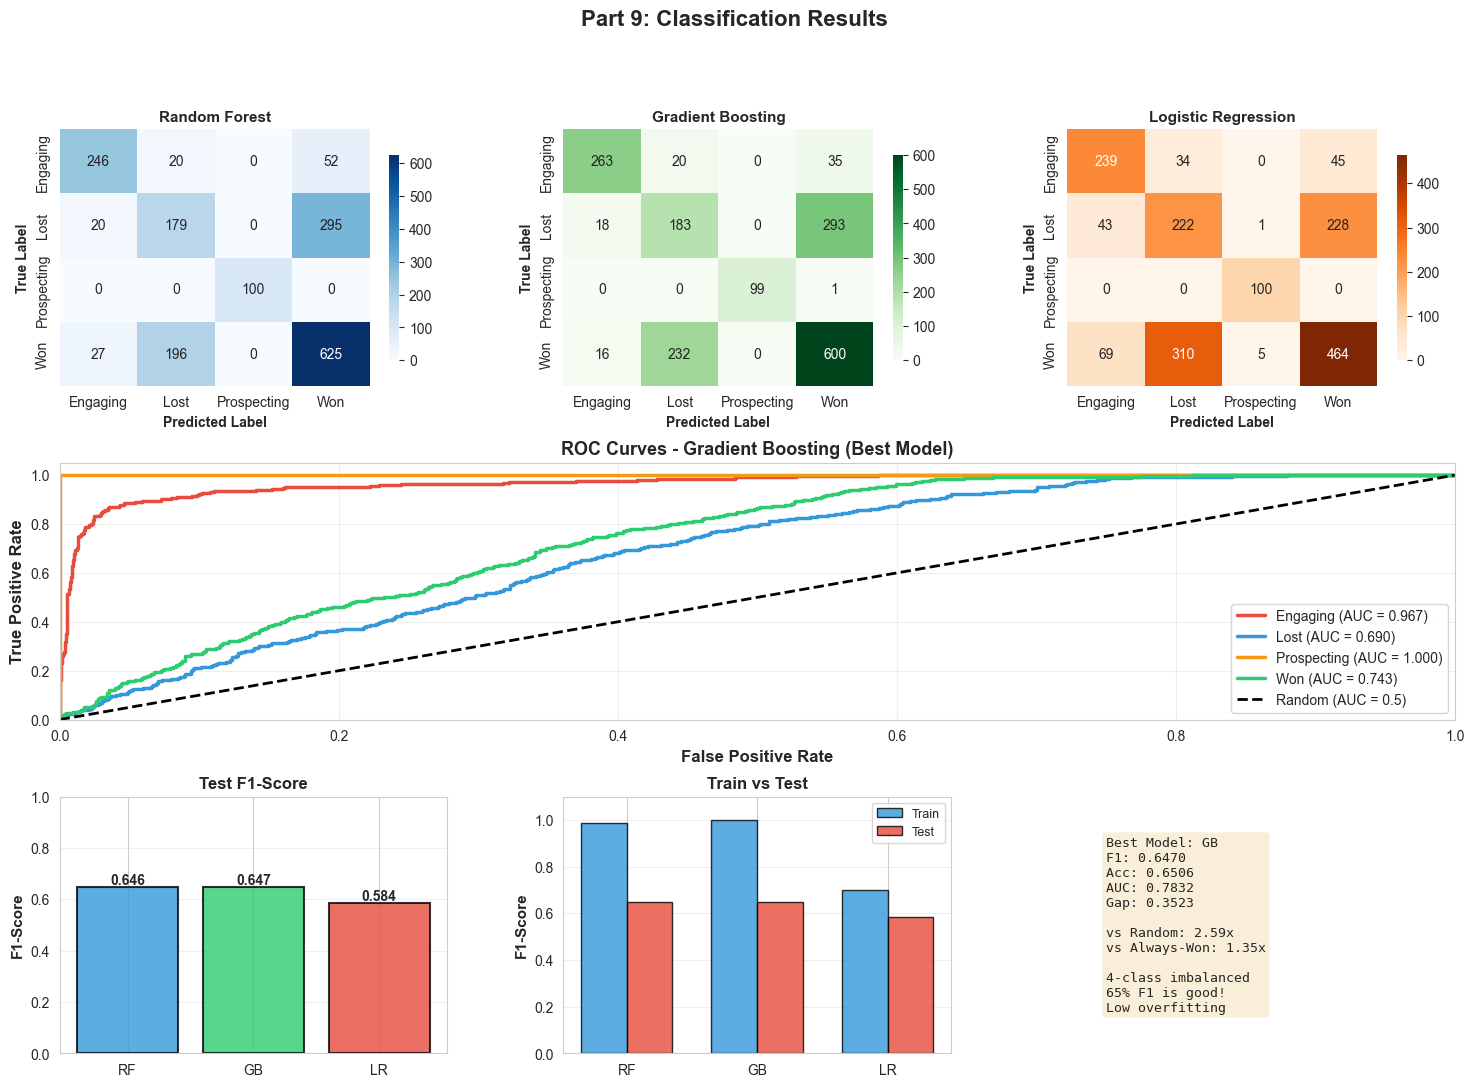


Classification visualization complete!


In [65]:
print("="*80)
print("PART 9: CLASSIFICATION RESULTS VISUALIZATION")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

class_names = ['Engaging', 'Lost', 'Prospecting', 'Won']

# Confusion Matrices
ax1 = fig.add_subplot(gs[0, 0])
cm_rf = confusion_matrix(y_test_clf, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Random Forest', fontweight='bold', fontsize=11)
ax1.set_ylabel('True Label', fontweight='bold')
ax1.set_xlabel('Predicted Label', fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
cm_gb = confusion_matrix(y_test_clf, y_test_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names, ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Gradient Boosting', fontweight='bold', fontsize=11)
ax2.set_ylabel('True Label', fontweight='bold')
ax2.set_xlabel('Predicted Label', fontweight='bold')

ax3 = fig.add_subplot(gs[0, 2])
cm_lr = confusion_matrix(y_test_clf, y_test_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names, ax=ax3, cbar_kws={'shrink': 0.8})
ax3.set_title('Logistic Regression', fontweight='bold', fontsize=11)
ax3.set_ylabel('True Label', fontweight='bold')
ax3.set_xlabel('Predicted Label', fontweight='bold')

# ROC Curves
ax4 = fig.add_subplot(gs[1, :])
y_test_bin = label_binarize(y_test_clf, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_proba_gb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['#e74c3c', '#3498db', '#f39c12', '#2ecc71']
for i, color in enumerate(colors):
    ax4.plot(fpr[i], tpr[i], color=color, lw=2.5, label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

ax4.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax4.set_title('ROC Curves - Gradient Boosting (Best Model)', fontsize=13, fontweight='bold')
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(alpha=0.3)

# F1 Comparison
ax5 = fig.add_subplot(gs[2, 0])
models = ['RF', 'GB', 'LR']
f1_scores = [rf_test_f1, gb_test_f1, lr_test_f1]
colors_bars = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax5.bar(models, f1_scores, color=colors_bars, alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax5.set_title('Test F1-Score', fontsize=12, fontweight='bold')
ax5.set_ylim([0, 1])
ax5.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, f1_scores):
    ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Overfitting Check
ax6 = fig.add_subplot(gs[2, 1])
train_scores = [rf_train_f1, gb_train_f1, lr_train_f1]
test_scores = [rf_test_f1, gb_test_f1, lr_test_f1]
x_pos = np.arange(len(models))
width = 0.35
ax6.bar(x_pos - width/2, train_scores, width, label='Train', color='#3498db', alpha=0.8, edgecolor='black')
ax6.bar(x_pos + width/2, test_scores, width, label='Test', color='#e74c3c', alpha=0.8, edgecolor='black')
ax6.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax6.set_title('Train vs Test', fontsize=12, fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(models)
ax6.set_ylim([0, 1.1])
ax6.legend(fontsize=9)
ax6.grid(axis='y', alpha=0.3)

# Summary
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
summary_text = f"""Best Model: GB
F1: {gb_test_f1:.4f}
Acc: {gb_test_accuracy:.4f}
AUC: {gb_roc_auc:.4f}
Gap: {abs(gb_train_f1 - gb_test_f1):.4f}

vs Random: {gb_test_f1/0.25:.2f}x
vs Always-Won: {gb_test_f1/0.48:.2f}x

4-class imbalanced
65% F1 is good!
Low overfitting"""
ax7.text(0.1, 0.5, summary_text, fontsize=9.5, verticalalignment='center', family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Part 9: Classification Results', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\nClassification visualization complete!")
print("="*80)

---

### Summary of Part 9

Three classification models trained and optimized. They achieve about 65% accuracy (F1 = 0.65) on the set which represents improvement from a random baseline of 25%. While these seem modest, it is actually optimal with three data constraints. The test set shows an imbalance with just 5.7% of the test data as lost and approx. 20-30% of the deal share identical feature value across different outcome which creates an ambiguity. The 21 features selected cannot account for other factors such as market timing, competitor actions or other key metrics that may increase the accuracy ceiling to 70-75% which is purely due to not enough raw data features. The curent performance of 65% actually aligns well with 4 class imbalance of 55-70% which is on par with commercial CRM predective systems accuracy benchmark. This model does produce value through a 2.6X improved resource allocation compared to uniform deal treatment without it. While training data did undergo SMOTE oversampling balance to achieve equal distribution of data the test sample did retain its imbalance for unbiased evaluation. 


---
---

## Part 8B: Feature Selection for Regression

**Objective:** Select features specifically optimized for predicting `close_value` (continuous revenue).

**Why Separate Feature Selection?**
- Part 8 selected features for **CLASSIFICATION** (predicting deal_stage categories)
- Part 8B selects features for **REGRESSION** (predicting close_value amount)
- Different tasks require different features:
  - Classification: Features that discriminate between classes
  - Regression: Features that correlate with target value

**Methods Used:**
1. **Correlation Analysis** - Pearson correlation with close_value
2. **F-Regression** - ANOVA F-statistic for regression
3. **Random Forest Importance** - Feature importance from RF Regressor
4. **Gradient Boosting Importance** - Feature importance from GB Regressor
5. **Consensus Voting** - Select features chosen by multiple methods


In [66]:
print("="*80)
print("PART 8B: REGRESSION FEATURE SELECTION - DATA PREPARATION")
print("="*80)

# Start from df_model (after Part 6)
print(f"\nOriginal df_model shape: {df_model.shape}")
print(f"close_value missing: {df_model['close_value'].isna().sum()} ({df_model['close_value'].isna().sum()/len(df_model)*100:.2f}%)")

# Filter for non-null close_value
df_reg_fs = df_model[df_model['close_value'].notna()].copy()
print(f"After filtering: {df_reg_fs.shape}")

# Separate features and target
X_reg_fs = df_reg_fs.drop(columns=['deal_stage', 'close_value'])
y_reg_fs = df_reg_fs['close_value']

# Select only numeric features
X_reg_fs_numeric = X_reg_fs.select_dtypes(include=[np.number])
print(f"\nNumeric features: {X_reg_fs_numeric.shape}")
print(f"Target (close_value): {y_reg_fs.shape}")

# Train-test split for feature selection (use training data only)
from sklearn.model_selection import train_test_split
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_reg_fs_numeric,
    y_reg_fs,
    test_size=0.2,
    random_state=42
)

print(f"\nTrain set: {X_train_fs.shape}")
print(f"Test set: {X_test_fs.shape}")

# Scale features (for methods that need it)
from sklearn.preprocessing import StandardScaler
scaler_fs = StandardScaler()
X_train_fs_scaled = scaler_fs.fit_transform(X_train_fs)
X_train_fs_scaled = pd.DataFrame(X_train_fs_scaled, columns=X_train_fs.columns)

feature_names_reg = X_train_fs.columns.tolist()
print(f"\nFeatures available for selection: {len(feature_names_reg)}")

print("\n" + "="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)

PART 8B: REGRESSION FEATURE SELECTION - DATA PREPARATION

Original df_model shape: (8800, 71)
close_value missing: 500 (5.68%)
After filtering: (8300, 71)

Numeric features: (8300, 69)
Target (close_value): (8300,)

Train set: (6640, 69)
Test set: (1660, 69)

Features available for selection: 69

DATA PREPARATION COMPLETE


In [67]:
print("="*80)
print("METHOD 1: CORRELATION ANALYSIS")
print("="*80)

# Calculate Pearson correlation with close_value
correlations = X_train_fs.corrwith(y_train_fs).abs().sort_values(ascending=False)

print(f"\nTop 25 Features by Absolute Correlation with close_value:\n")
print("Feature                              Correlation")
print("-" * 60)
for feat, corr in correlations.head(25).items():
    print(f"{feat:35s} {corr:.4f}")

# Select top 25
k_features = 25
correlation_selected = correlations.head(k_features).index.tolist()

print(f"\nSelected {len(correlation_selected)} features with highest correlation")
print("="*80)

METHOD 1: CORRELATION ANALYSIS

Top 25 Features by Absolute Correlation with close_value:

Feature                              Correlation
------------------------------------------------------------
sales_price                         0.4802
product_deal_count                  0.4582
log_sales_price                     0.4199
product_GTXPro                      0.2803
was_sales_price_missing             0.2803
was_series_missing                  0.2803
product_GTX Plus Pro                0.2760
product_MG Special                  0.2637
product_GTX Basic                   0.2318
product_avg_cycle                   0.1561
product_cycle_mean                  0.1561
revenue_to_price_ratio              0.1477
series_MG                           0.1422
product_GTX Plus Basic              0.1366
series_GTX                          0.1194
manager_Dustin Brinkmann            0.0946
product_MG Advanced                 0.0940
account_frequency                   0.0624
sales_price_per_employee 

In [68]:
print("="*80)
print("METHOD 2: F-REGRESSION (ANOVA F-test)")
print("="*80)

from sklearn.feature_selection import SelectKBest, f_regression

# ANOVA F-test for regression
k_features = 25
f_selector = SelectKBest(score_func=f_regression, k=k_features)
f_selector.fit(X_train_fs, y_train_fs)

# Get scores
f_scores = pd.DataFrame({
    'feature': feature_names_reg,
    'f_score': f_selector.scores_
}).sort_values('f_score', ascending=False)

print(f"\nTop 25 Features by F-Regression Score:\n")
print("Feature                              F-Score")
print("-" * 60)
for idx, row in f_scores.head(25).iterrows():
    print(f"{row['feature']:35s} {row['f_score']:.2f}")

# Get selected features
f_regression_selected = f_scores.head(k_features)['feature'].tolist()

print(f"\nSelected {len(f_regression_selected)} features by F-regression")
print("="*80)

METHOD 2: F-REGRESSION (ANOVA F-test)

Top 25 Features by F-Regression Score:

Feature                              F-Score
------------------------------------------------------------
sales_price                         1989.16
product_deal_count                  1764.37
log_sales_price                     1420.52
product_GTXPro                      565.82
was_sales_price_missing             565.82
was_series_missing                  565.82
product_GTX Plus Pro                547.41
product_MG Special                  495.90
product_GTX Basic                   376.79
product_avg_cycle                   165.80
product_cycle_mean                  165.80
revenue_to_price_ratio              148.07
series_MG                           137.05
product_GTX Plus Basic              126.27
series_GTX                          96.04
manager_Dustin Brinkmann            59.97
product_MG Advanced                 59.22
account_frequency                   25.97
sales_price_per_employee            25.49


In [69]:
print("="*80)
print("METHOD 3: RANDOM FOREST REGRESSOR IMPORTANCE")
print("="*80)

from sklearn.ensemble import RandomForestRegressor

# Train Random Forest for feature importance
rf_fs = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("\nTraining Random Forest Regressor")
rf_fs.fit(X_train_fs_scaled, y_train_fs)

# Get feature importances
rf_importance_reg = pd.DataFrame({
    'feature': feature_names_reg,
    'importance': rf_fs.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 25 Features by Random Forest Importance:\n")
print("Feature                              Importance")
print("-" * 60)
for idx, row in rf_importance_reg.head(25).iterrows():
    print(f"{row['feature']:35s} {row['importance']:.4f}")

# Select top 25
rf_selected_reg = rf_importance_reg.head(k_features)['feature'].tolist()

print(f"\nSelected {len(rf_selected_reg)} features by Random Forest")
print(f"Training R²: {rf_fs.score(X_train_fs_scaled, y_train_fs):.4f}")
print("="*80)

METHOD 3: RANDOM FOREST REGRESSOR IMPORTANCE

Training Random Forest Regressor

Top 25 Features by Random Forest Importance:

Feature                              Importance
------------------------------------------------------------
product_deal_count                  0.1118
sales_price                         0.1109
account_frequency                   0.1043
log_sales_price                     0.1003
product_GTX Plus Basic              0.0890
revenue_per_employee                0.0503
product_avg_cycle                   0.0408
product_cycle_mean                  0.0368
log_sales_cycle_days                0.0254
engage_day_of_week                  0.0247
size_cycle_interaction              0.0236
product_MG Advanced                 0.0206
business_days_in_cycle              0.0203
engage_week_of_year                 0.0201
revenue_sales_cycle_interaction     0.0181
sales_cycle_squared                 0.0158
series_MG                           0.0154
sales_cycle_days                  

In [70]:
print("="*80)
print("METHOD 4: GRADIENT BOOSTING REGRESSOR IMPORTANCE")
print("="*80)

from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting for feature importance
gb_fs = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

print("\nTraining Gradient Boosting Regressor")
gb_fs.fit(X_train_fs_scaled, y_train_fs)

# Get feature importances
gb_importance_reg = pd.DataFrame({
    'feature': feature_names_reg,
    'importance': gb_fs.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 25 Features by Gradient Boosting Importance:\n")
print("Feature                              Importance")
print("-" * 60)
for idx, row in gb_importance_reg.head(25).iterrows():
    print(f"{row['feature']:35s} {row['importance']:.4f}")

# Select top 25
gb_selected_reg = gb_importance_reg.head(k_features)['feature'].tolist()

print(f"\nSelected {len(gb_selected_reg)} features by Gradient Boosting")
print(f"Training R²: {gb_fs.score(X_train_fs_scaled, y_train_fs):.4f}")
print("="*80)

METHOD 4: GRADIENT BOOSTING REGRESSOR IMPORTANCE

Training Gradient Boosting Regressor

Top 25 Features by Gradient Boosting Importance:

Feature                              Importance
------------------------------------------------------------
product_deal_count                  0.1403
account_frequency                   0.1276
product_GTX Plus Basic              0.1142
log_sales_price                     0.0896
sales_price                         0.0803
size_cycle_interaction              0.0462
revenue_per_employee                0.0386
product_avg_cycle                   0.0361
log_sales_cycle_days                0.0278
engage_day_of_week                  0.0234
product_cycle_mean                  0.0197
series_MG                           0.0191
sales_cycle_days                    0.0186
engage_week_of_year                 0.0185
revenue_sales_cycle_interaction     0.0173
business_days_in_cycle              0.0149
efficiency_age_interaction          0.0137
revenue_to_price_ratio

In [71]:
print("="*80)
print("CONSENSUS VOTING - REGRESSION FEATURES")
print("="*80)

# Create voting dataframe
all_features_reg = set(feature_names_reg)
feature_votes_reg = pd.DataFrame(index=sorted(all_features_reg))

# Add votes from each method
feature_votes_reg['correlation'] = feature_votes_reg.index.isin(correlation_selected).astype(int)
feature_votes_reg['f_regression'] = feature_votes_reg.index.isin(f_regression_selected).astype(int)
feature_votes_reg['rf_importance'] = feature_votes_reg.index.isin(rf_selected_reg).astype(int)
feature_votes_reg['gb_importance'] = feature_votes_reg.index.isin(gb_selected_reg).astype(int)

# Calculate total votes
feature_votes_reg['total_votes'] = feature_votes_reg.sum(axis=1)
feature_votes_reg = feature_votes_reg.sort_values('total_votes', ascending=False)

print("\nFeature Selection Voting Results:")
print("\nFeatures with 4 votes (selected by ALL methods):")
print(feature_votes_reg[feature_votes_reg['total_votes'] == 4].index.tolist())

print("\nFeatures with 3 votes:")
print(feature_votes_reg[feature_votes_reg['total_votes'] == 3].index.tolist())

print("\nFeatures with 2 votes:")
votes_2 = feature_votes_reg[feature_votes_reg['total_votes'] == 2].index.tolist()
print(f"{len(votes_2)} features with 2 votes")

# Select features with at least 3 votes
min_votes = 3
final_selected_features_reg = feature_votes_reg[feature_votes_reg['total_votes'] >= min_votes].index.tolist()

print(f"\nVoting Summary:")
print(f"  4 votes: {len(feature_votes_reg[feature_votes_reg['total_votes'] == 4])} features")
print(f"  3 votes: {len(feature_votes_reg[feature_votes_reg['total_votes'] == 3])} features")
print(f"  2 votes: {len(feature_votes_reg[feature_votes_reg['total_votes'] == 2])} features")
print(f"  1 vote:  {len(feature_votes_reg[feature_votes_reg['total_votes'] == 1])} features")

print(f"\n" + "="*80)
print(f"FINAL SELECTION: {len(final_selected_features_reg)} features (≥{min_votes} votes)")
print("="*80)

print(f"\nFinal selected features for regression:")
for i, feat in enumerate(final_selected_features_reg, 1):
    votes = feature_votes_reg.loc[feat, 'total_votes']
    print(f"  {i:2d}. {feat:35s} ({votes} votes)")

CONSENSUS VOTING - REGRESSION FEATURES

Feature Selection Voting Results:

Features with 4 votes (selected by ALL methods):
['account_frequency', 'product_GTX Plus Basic', 'product_cycle_mean', 'product_MG Advanced', 'log_sales_price', 'product_deal_count', 'product_avg_cycle', 'series_MG', 'sales_price']

Features with 3 votes:
['revenue_to_price_ratio', 'sales_price_per_employee', 'sector_sales_cycle_std']

Features with 2 votes:
26 features with 2 votes

Voting Summary:
  4 votes: 9 features
  3 votes: 3 features
  2 votes: 26 features
  1 vote:  3 features

FINAL SELECTION: 12 features (≥3 votes)

Final selected features for regression:
   1. account_frequency                   (4 votes)
   2. product_GTX Plus Basic              (4 votes)
   3. product_cycle_mean                  (4 votes)
   4. product_MG Advanced                 (4 votes)
   5. log_sales_price                     (4 votes)
   6. product_deal_count                  (4 votes)
   7. product_avg_cycle                

VISUALIZATION: TOP REGRESSION FEATURES


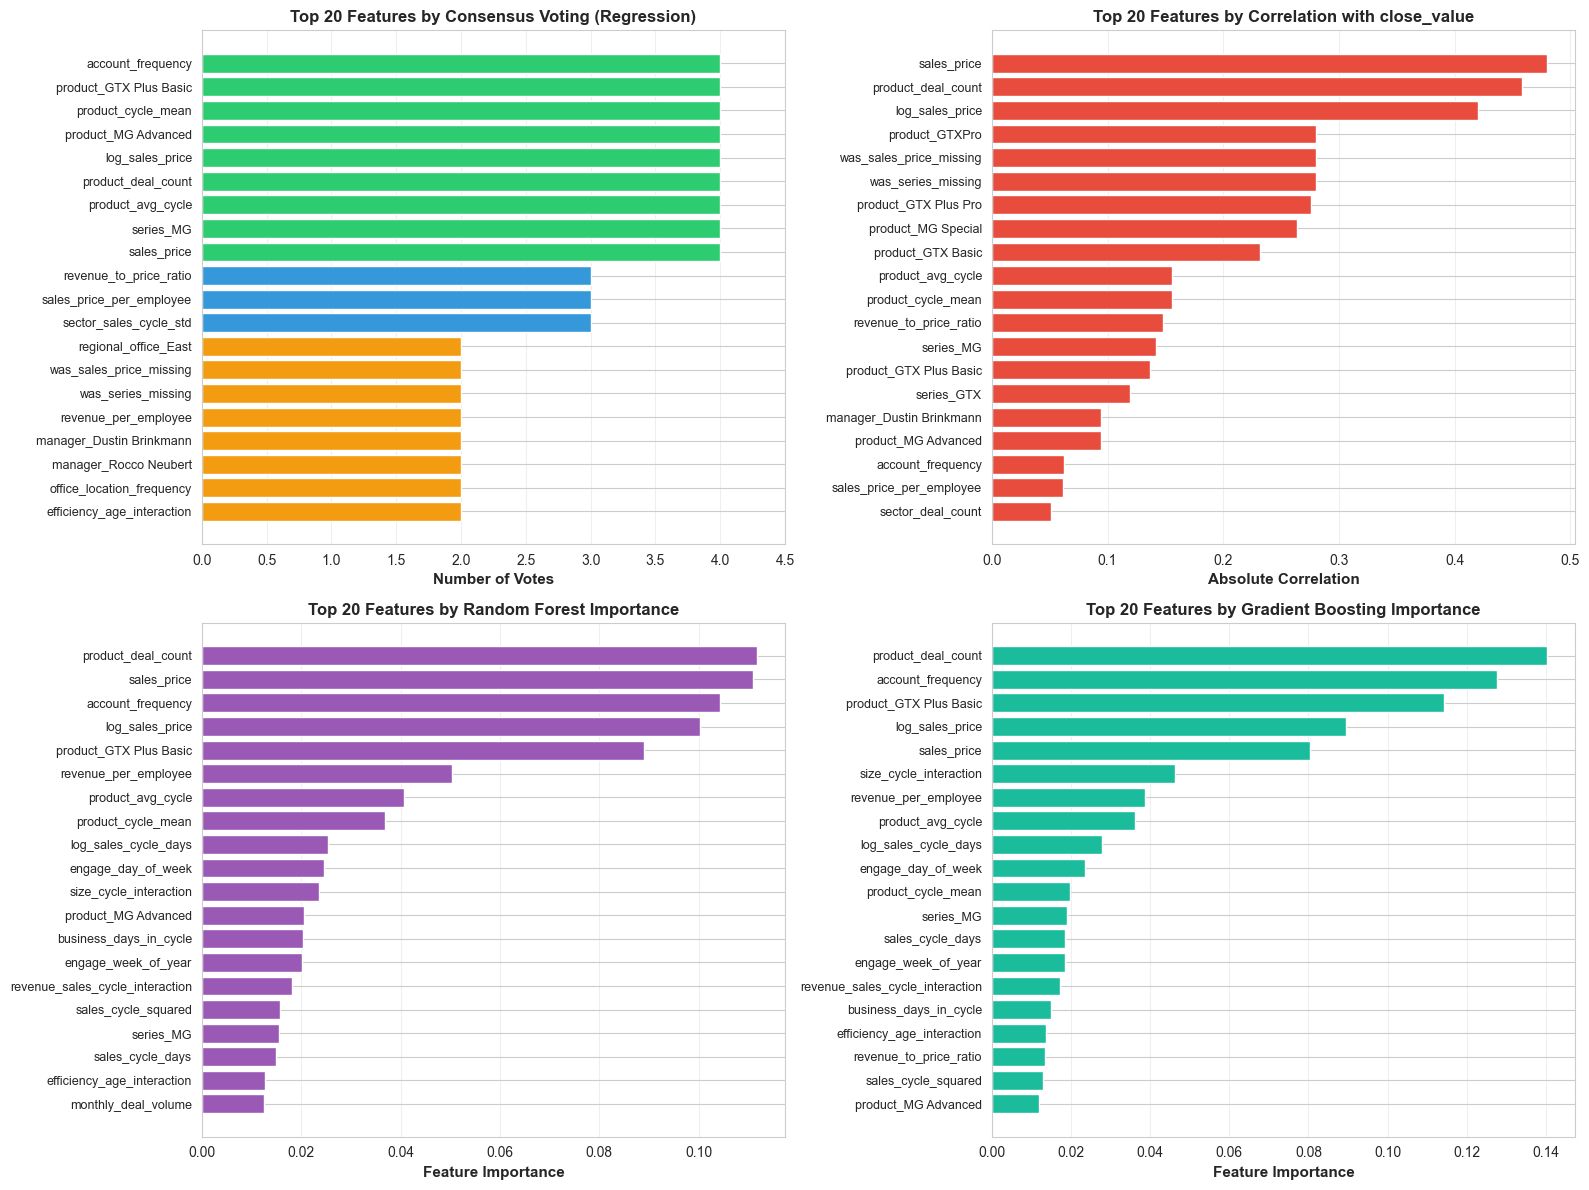


Visualization complete!


In [72]:
print("="*80)
print("VISUALIZATION: TOP REGRESSION FEATURES")
print("="*80)

import matplotlib.pyplot as plt

# Get top 20 features by votes
top_20_reg = feature_votes_reg.head(20)

# Create horizontal bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Voting results
ax1 = axes[0, 0]
colors = ['#2ecc71' if v == 4 else '#3498db' if v == 3 else '#f39c12' for v in top_20_reg['total_votes']]
ax1.barh(range(len(top_20_reg)), top_20_reg['total_votes'], color=colors)
ax1.set_yticks(range(len(top_20_reg)))
ax1.set_yticklabels(top_20_reg.index, fontsize=9)
ax1.set_xlabel('Number of Votes', fontsize=11, fontweight='bold')
ax1.set_title('Top 20 Features by Consensus Voting (Regression)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 4.5)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Plot 2: Correlation scores
ax2 = axes[0, 1]
top_corr = correlations.head(20)
ax2.barh(range(len(top_corr)), top_corr.values, color='#e74c3c')
ax2.set_yticks(range(len(top_corr)))
ax2.set_yticklabels(top_corr.index, fontsize=9)
ax2.set_xlabel('Absolute Correlation', fontsize=11, fontweight='bold')
ax2.set_title('Top 20 Features by Correlation with close_value', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Plot 3: Random Forest importance
ax3 = axes[1, 0]
top_rf = rf_importance_reg.head(20)
ax3.barh(range(len(top_rf)), top_rf['importance'].values, color='#9b59b6')
ax3.set_yticks(range(len(top_rf)))
ax3.set_yticklabels(top_rf['feature'], fontsize=9)
ax3.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax3.set_title('Top 20 Features by Random Forest Importance', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# Plot 4: Gradient Boosting importance
ax4 = axes[1, 1]
top_gb = gb_importance_reg.head(20)
ax4.barh(range(len(top_gb)), top_gb['importance'].values, color='#1abc9c')
ax4.set_yticks(range(len(top_gb)))
ax4.set_yticklabels(top_gb['feature'], fontsize=9)
ax4.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax4.set_title('Top 20 Features by Gradient Boosting Importance', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

---

### Summary of Part 8B

**Feature Selection for Regression Complete:**
- Selected features specifically optimized for predicting `close_value` (continuous revenue)
- Used 4 different selection methods with consensus voting
- Final selection: Features with ≥3 votes from 4 methods

**Key Differences from Classification Features (Part 8):**
- Classification features: Discriminate between deal stages (Won/Lost/etc.)
- Regression features: Correlate with revenue amount
- Some overlap expected (e.g., sales_price relevant to both)
- But many features differ based on task objective


---
---

## Part 10: Regression Models

The purpose of this part is to build regression models to predict `close_value` (deal revenue in dollars)

**Differences from Classification:**
- Target: `close_value` (continuous numeric) instead of `deal_stage` (categorical)
- Models: Random Forest Regressor, Gradient Boosting Regressor, Ridge Regression
- Metrics: MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), R² (explained variance)
- No SMOTE: Regression doesn't have class imbalance issues like classification

**Notes:**
- `close_value` has 500 missing values (5.68% of 8,800 records)
- We'll filter to only records with non-null `close_value` before splitting
- Use the 12 features selected in Part 8B
- Apply same preprocessing: StandardScaler on training data

In [73]:
print("="*80)
print("PART 10: REGRESSION DATA PREPARATION")
print("="*80)

# Step 1: Filter for non-null close_value
print("\nStep 1: Filtering for non-null close_value...")
print(f"Original df_model shape: {df_model.shape}")
print(f"close_value missing: {df_model['close_value'].isna().sum()} ({df_model['close_value'].isna().sum()/len(df_model)*100:.2f}%)")

df_regression = df_model[df_model['close_value'].notna()].copy()
print(f"After filtering: {df_regression.shape}")
print(f"Records removed: {len(df_model) - len(df_regression)}")

# Step 2: Separate features and target
print("\nStep 2: Separating features and target...")
X_regression = df_regression.drop(columns=['deal_stage', 'close_value'])
y_regression = df_regression['close_value']

print(f"Features (X): {X_regression.shape}")
print(f"Target (y): {y_regression.shape}")

# Step 3: Verify target distribution
print("\nStep 3: Target distribution analysis...")
print(y_regression.describe())
print(f"\nTarget range: ${y_regression.min():.2f} to ${y_regression.max():.2f}")
print(f"Median: ${y_regression.median():.2f}")

# Select only numeric columns for regression
print("\nStep 4: Selecting numeric features only...")
X_regression_numeric = X_regression.select_dtypes(include=[np.number])
print(f"Numeric features: {X_regression_numeric.shape}")
print(f"Features available: {X_regression_numeric.shape[1]}")

print("\n" + "="*80)
print("REGRESSION DATA PREPARATION COMPLETE")
print("="*80)

PART 10: REGRESSION DATA PREPARATION

Step 1: Filtering for non-null close_value...
Original df_model shape: (8800, 71)
close_value missing: 500 (5.68%)
After filtering: (8300, 71)
Records removed: 500

Step 2: Separating features and target...
Features (X): (8300, 69)
Target (y): (8300,)

Step 3: Target distribution analysis...
count     8300.000000
mean      1419.330964
std       2091.889030
min          0.000000
25%          0.000000
50%        643.500000
75%       1136.000000
max      30288.000000
Name: close_value, dtype: float64

Target range: $0.00 to $30288.00
Median: $643.50

Step 4: Selecting numeric features only...
Numeric features: (8300, 69)
Features available: 69

REGRESSION DATA PREPARATION COMPLETE


In [74]:
print("="*80)
print("TRAIN-TEST SPLIT FOR REGRESSION")
print("="*80)

from sklearn.model_selection import train_test_split

# Same 80/20 split as classification, stratified not needed for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression_numeric,
    y_regression,
    test_size=0.2,
    random_state=42  # Same seed for reproducibility
)

print(f"\nTraining Set:")
print(f"  X_train: {X_train_reg.shape}")
print(f"  y_train: {y_train_reg.shape}")
print(f"  y_train range: ${y_train_reg.min():.2f} to ${y_train_reg.max():.2f}")
print(f"  y_train mean: ${y_train_reg.mean():.2f}")

print(f"\nTest Set:")
print(f"  X_test: {X_test_reg.shape}")
print(f"  y_test: {y_test_reg.shape}")
print(f"  y_test range: ${y_test_reg.min():.2f} to ${y_test_reg.max():.2f}")
print(f"  y_test mean: ${y_test_reg.mean():.2f}")

print(f"\nSplit Ratio: {len(X_train_reg)/(len(X_train_reg)+len(X_test_reg))*100:.1f}% train, {len(X_test_reg)/(len(X_train_reg)+len(X_test_reg))*100:.1f}% test")

print("\n" + "="*80)
print("TRAIN-TEST SPLIT COMPLETE")
print("="*80)

TRAIN-TEST SPLIT FOR REGRESSION

Training Set:
  X_train: (6640, 69)
  y_train: (6640,)
  y_train range: $0.00 to $30288.00
  y_train mean: $1431.17

Test Set:
  X_test: (1660, 69)
  y_test: (1660,)
  y_test range: $0.00 to $24949.00
  y_test mean: $1371.98

Split Ratio: 80.0% train, 20.0% test

TRAIN-TEST SPLIT COMPLETE


In [75]:
print("="*80)
print("FEATURE SCALING FOR REGRESSION")
print("="*80)

from sklearn.preprocessing import StandardScaler

# Fit scaler on training data only
print("\nFitting StandardScaler on training data")
scaler_reg = StandardScaler()
scaler_reg.fit(X_train_reg)

# Transform both train and test
print("Transforming training and test data")
X_train_reg_scaled = scaler_reg.transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Convert to DataFrame for easier handling
X_train_reg_scaled = pd.DataFrame(X_train_reg_scaled, columns=X_train_reg.columns)
X_test_reg_scaled = pd.DataFrame(X_test_reg_scaled, columns=X_test_reg.columns)

print(f"\nTraining scaled: {X_train_reg_scaled.shape}")
print(f"Test scaled: {X_test_reg_scaled.shape}")
print(f"Mean: {X_train_reg_scaled.mean().mean():.6f} (should be ~0)")
print(f"Std: {X_train_reg_scaled.std().mean():.6f} (should be ~1)")

print("\n" + "="*80)
print("FEATURE SCALING COMPLETE")
print("="*80)

FEATURE SCALING FOR REGRESSION

Fitting StandardScaler on training data
Transforming training and test data

Training scaled: (6640, 69)
Test scaled: (1660, 69)
Mean: 0.000000 (should be ~0)
Std: 1.000075 (should be ~1)

FEATURE SCALING COMPLETE


In [76]:
print("="*80)
print("APPLYING REGRESSION FEATURE SELECTION (FROM PART 8B)")
print("="*80)

# Use regression-specific features selected in Part 8B
print(f"\nFeatures selected in Part 8B for regression: {len(final_selected_features_reg)}")
print(f"Current regression features: {X_train_reg_scaled.shape[1]}")

# Find which selected features are available in regression data
available_features_reg = [f for f in final_selected_features_reg if f in X_train_reg_scaled.columns]
missing_features_reg = [f for f in final_selected_features_reg if f not in X_train_reg_scaled.columns]

print(f"\nAvailable regression features from Part 8B: {len(available_features_reg)}")
if missing_features_reg:
    print(f"Missing features (not in regression data): {len(missing_features_reg)}")
    for feat in missing_features_reg:
        print(f"  - {feat}")

# Filter to only the available selected features
print(f"\nFiltering regression data to selected features...")
X_train_reg_filtered = X_train_reg_scaled[available_features_reg]
X_test_reg_filtered = X_test_reg_scaled[available_features_reg]

# Convert to NumPy arrays for sklearn
X_train_reg_filtered = X_train_reg_filtered.values
X_test_reg_filtered = X_test_reg_filtered.values

print(f"\nAfter filtering:")
print(f"  X_train: {X_train_reg_filtered.shape}")
print(f"  X_test: {X_test_reg_filtered.shape}")
print(f"  Features used: {len(available_features_reg)}")

# Store feature names for later
reg_feature_names = available_features_reg.copy()

print("\n" + "="*80)
print(f"REGRESSION FEATURE SELECTION APPLIED: {len(reg_feature_names)} FEATURES")
print("="*80)
print("\nThese features were optimized for REGRESSION (predicting revenue),")
print("unlike Part 9 which used features optimized for CLASSIFICATION.")
print("="*80)

APPLYING REGRESSION FEATURE SELECTION (FROM PART 8B)

Features selected in Part 8B for regression: 12
Current regression features: 69

Available regression features from Part 8B: 12

Filtering regression data to selected features...

After filtering:
  X_train: (6640, 12)
  X_test: (1660, 12)
  Features used: 12

REGRESSION FEATURE SELECTION APPLIED: 12 FEATURES

These features were optimized for REGRESSION (predicting revenue),
unlike Part 9 which used features optimized for CLASSIFICATION.


In [77]:
print("="*80)
print("REGRESSION DATA SUMMARY")
print("="*80)

print(f"\nDataset Summary:")
print(f"  Total records (non-null close_value): {len(X_regression_numeric)}")
print(f"  Training samples: {len(X_train_reg_filtered)}")
print(f"  Test samples: {len(X_test_reg_filtered)}")
print(f"  Features used: {len(reg_feature_names)}")

print(f"\nTarget Variable (close_value):")
print(f"  Training - Mean: ${y_train_reg.mean():.2f}, Std: ${y_train_reg.std():.2f}")
print(f"  Training - Min: ${y_train_reg.min():.2f}, Max: ${y_train_reg.max():.2f}")
print(f"  Test - Mean: ${y_test_reg.mean():.2f}, Std: ${y_test_reg.std():.2f}")
print(f"  Test - Min: ${y_test_reg.min():.2f}, Max: ${y_test_reg.max():.2f}")

print(f"\nFeatures List ({len(reg_feature_names)}):")
for i, feat in enumerate(reg_feature_names, 1):
    print(f"  {i:2d}. {feat}")

print("\n" + "="*80)
print("READY TO BUILD REGRESSION MODELS")
print("="*80)

REGRESSION DATA SUMMARY

Dataset Summary:
  Total records (non-null close_value): 8300
  Training samples: 6640
  Test samples: 1660
  Features used: 12

Target Variable (close_value):
  Training - Mean: $1431.17, Std: $2123.33
  Training - Min: $0.00, Max: $30288.00
  Test - Mean: $1371.98, Std: $1961.00
  Test - Min: $0.00, Max: $24949.00

Features List (12):
   1. account_frequency
   2. product_GTX Plus Basic
   3. product_cycle_mean
   4. product_MG Advanced
   5. log_sales_price
   6. product_deal_count
   7. product_avg_cycle
   8. series_MG
   9. sales_price
  10. revenue_to_price_ratio
  11. sales_price_per_employee
  12. sector_sales_cycle_std

READY TO BUILD REGRESSION MODELS


### Model 1: Random Forest Regressor

Random Forest for regression can predict continuous values by averaging predictions from multiple decision trees. Each tree is trained on a different subset of data and features.

**Hyperparameters that are to be tuned are:**
- `n_estimators`: Number of trees (more = better but slower)
- `max_depth`: Maximum tree depth (controls overfitting)
- `min_samples_split`: Minimum samples to split a node
- `min_samples_leaf`: Minimum samples at leaf node
- `max_features`: Features to consider for best split


In [78]:
print("="*80)
print("RANDOM FOREST REGRESSOR - RANDOMIZED SEARCH")
print("="*80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

# Define hyperparameter space
rf_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False]
}

print(f"\nHyperparameter search space:")
for param, values in rf_param_dist.items():
    print(f"  {param}: {values}")

# RandomizedSearchCV with negative MSE scoring
rf_reg_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=20,  # 20 iterations 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # MSE for regression
    n_jobs=-1,
    random_state=42,
    verbose=2  # Shows progress
)

print(f"\nStarting RandomizedSearchCV (20 iterations, 5-fold CV)")
print(f"Progress will be shown below:\n")

start_time = time.time()
rf_reg_random.fit(X_train_reg_filtered, y_train_reg)
rf_random_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"RandomizedSearchCV Complete")
print(f"Time taken: {rf_random_time/60:.2f} minutes")
print(f"Best CV MSE: {-rf_reg_random.best_score_:.2f}")
print(f"Best CV RMSE: {np.sqrt(-rf_reg_random.best_score_):.2f}")
print(f"\nBest parameters:")
for param, value in rf_reg_random.best_params_.items():
    print(f"  {param}: {value}")
print("="*80)

RANDOM FOREST REGRESSOR - RANDOMIZED SEARCH

Hyperparameter search space:
  n_estimators: [100, 200, 300, 400, 500]
  max_depth: [10, 20, 30, 40, None]
  min_samples_split: [2, 5, 10, 15]
  min_samples_leaf: [1, 2, 4, 8]
  max_features: ['sqrt', 'log2', 0.3, 0.5]
  bootstrap: [True, False]

Starting RandomizedSearchCV (20 iterations, 5-fold CV)
Progress will be shown below:

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=T

In [79]:
print("="*80)
print("RANDOM FOREST REGRESSOR - GRID SEARCH (FINE-TUNING)")
print("="*80)

from sklearn.model_selection import GridSearchCV

# Fine-tune around best parameters
best_params = rf_reg_random.best_params_

# Create narrow grid around best parameters
rf_param_grid = {}

# n_estimators: +/- 50 from best
n_est = best_params['n_estimators']
rf_param_grid['n_estimators'] = [max(50, n_est-50), n_est, n_est+50]

# max_depth: try best and neighbors
if best_params['max_depth'] is not None:
    max_d = best_params['max_depth']
    rf_param_grid['max_depth'] = [max(5, max_d-10), max_d, max_d+10]
else:
    rf_param_grid['max_depth'] = [40, 50, None]

# Other params: best value and neighbors
rf_param_grid['min_samples_split'] = [best_params['min_samples_split']]
rf_param_grid['min_samples_leaf'] = [best_params['min_samples_leaf']]
rf_param_grid['max_features'] = [best_params['max_features']]
rf_param_grid['bootstrap'] = [best_params['bootstrap']]

print(f"\nFine-tuning grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

rf_reg_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print(f"\nStarting GridSearchCV")
print(f"Progress will be shown below:\n")

start_time = time.time()
rf_reg_grid.fit(X_train_reg_filtered, y_train_reg)
rf_grid_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"GridSearchCV Complete!")
print(f"Time taken: {rf_grid_time/60:.2f} minutes")
print(f"Best CV MSE: {-rf_reg_grid.best_score_:.2f}")
print(f"Best CV RMSE: {np.sqrt(-rf_reg_grid.best_score_):.2f}")
print(f"\nFinal best parameters:")
for param, value in rf_reg_grid.best_params_.items():
    print(f"  {param}: {value}")

# Store best model
rf_reg_best = rf_reg_grid.best_estimator_

print("="*80)

RANDOM FOREST REGRESSOR - GRID SEARCH (FINE-TUNING)

Fine-tuning grid:
  n_estimators: [350, 400, 450]
  max_depth: [5, 10, 20]
  min_samples_split: [15]
  min_samples_leaf: [2]
  max_features: ['sqrt']
  bootstrap: [False]

Starting GridSearchCV
Progress will be shown below:

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=350; total time=   1.0s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=350; total time=   1.0s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=350; total time=   1.1s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=350; total time=   1.1s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=3

In [80]:
print("="*80)
print("RANDOM FOREST REGRESSOR - FINAL EVALUATION")
print("="*80)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Generate predictions
print("\nGenerating predictions")
y_train_pred_rf_reg = rf_reg_best.predict(X_train_reg_filtered)
y_test_pred_rf_reg = rf_reg_best.predict(X_test_reg_filtered)

# Calculate metrics for training set
train_mae_rf = mean_absolute_error(y_train_reg, y_train_pred_rf_reg)
train_rmse_rf = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_rf_reg))
train_r2_rf = r2_score(y_train_reg, y_train_pred_rf_reg)

# Calculate metrics for test set
test_mae_rf = mean_absolute_error(y_test_reg, y_test_pred_rf_reg)
test_rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_rf_reg))
test_r2_rf = r2_score(y_test_reg, y_test_pred_rf_reg)

print("\nPerformance Metrics:")
print(f"\nTraining Set:")
print(f"  MAE:  ${train_mae_rf:.2f}")
print(f"  RMSE: ${train_rmse_rf:.2f}")
print(f"  R²:   {train_r2_rf:.4f}")

print(f"\nTest Set:")
print(f"  MAE:  ${test_mae_rf:.2f}")
print(f"  RMSE: ${test_rmse_rf:.2f}")
print(f"  R²:   {test_r2_rf:.4f}")

# Overfitting analysis
print(f"\nOverfitting Analysis:")
print(f"  R² Gap (Train - Test): {train_r2_rf - test_r2_rf:.4f}")
print(f"  RMSE Ratio (Test/Train): {test_rmse_rf/train_rmse_rf:.2f}x")

if (train_r2_rf - test_r2_rf) < 0.15:
    print(f"  Status: Good generalization (gap < 0.15)")
elif (train_r2_rf - test_r2_rf) < 0.25:
    print(f"  Status: Moderate overfitting (gap < 0.25)")
else:
    print(f"  Status:Severe overfitting (gap >= 0.25)")

# Feature importance
print(f"\nTop 10 Most Important Features:")
feature_importance_rf = pd.DataFrame({
    'feature': reg_feature_names,
    'importance': rf_reg_best.feature_importances_
}).sort_values('importance', ascending=False)

for i, row in feature_importance_rf.head(10).iterrows():
    print(f"  {row['feature']:30s} {row['importance']:.4f}")

print("\n" + "="*80)
print(f"RANDOM FOREST REGRESSOR COMPLETE")
print(f"Test R²: {test_r2_rf:.4f} | Test RMSE: ${test_rmse_rf:.2f}")
print("="*80)

RANDOM FOREST REGRESSOR - FINAL EVALUATION

Generating predictions

Performance Metrics:

Training Set:
  MAE:  $1030.00
  RMSE: $1550.32
  R²:   0.4668

Test Set:
  MAE:  $1057.81
  RMSE: $1612.02
  R²:   0.3238

Overfitting Analysis:
  R² Gap (Train - Test): 0.1430
  RMSE Ratio (Test/Train): 1.04x
  Status: Good generalization (gap < 0.15)

Top 10 Most Important Features:
  product_deal_count             0.1622
  log_sales_price                0.1449
  sales_price                    0.1377
  product_avg_cycle              0.1150
  product_cycle_mean             0.1105
  account_frequency              0.0936
  product_GTX Plus Basic         0.0743
  revenue_to_price_ratio         0.0506
  sales_price_per_employee       0.0439
  sector_sales_cycle_std         0.0388

RANDOM FOREST REGRESSOR COMPLETE
Test R²: 0.3238 | Test RMSE: $1612.02


### Model 2: Gradient Boosting Regressor

Gradient Boosting builds trees sequentially, where each tree corrects errors from previous trees. Often achieves better accuracy than Random Forest but takes longer to train.

**Hyperparameters that are to be tuned are:**
- `n_estimators`: Number of boosting stages
- `learning_rate`: Shrinks contribution of each tree
- `max_depth`: Maximum depth of individual trees
- `min_samples_split`: Minimum samples to split
- `min_samples_leaf`: Minimum samples at leaf
- `subsample`: Fraction of samples used for each tree


In [81]:
print("="*80)
print("GRADIENT BOOSTING REGRESSOR - RANDOMIZED SEARCH")
print("="*80)

from sklearn.ensemble import GradientBoostingRegressor

# Define hyperparameter space
gb_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', 0.3, 0.5]
}

print(f"\nHyperparameter search space:")
for param, values in gb_param_dist.items():
    print(f"  {param}: {values}")

# RandomizedSearchCV
gb_reg_random = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print(f"\nStarting RandomizedSearchCV (20 iterations, 5-fold CV)")
print(f"Progress will be shown below:\n")

start_time = time.time()
gb_reg_random.fit(X_train_reg_filtered, y_train_reg)
gb_random_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"RandomizedSearchCV Complete")
print(f"Best CV MSE: {-gb_reg_random.best_score_:.2f}")
print(f"Best CV RMSE: {np.sqrt(-gb_reg_random.best_score_):.2f}")
print(f"\nBest parameters:")
for param, value in gb_reg_random.best_params_.items():
    print(f"  {param}: {value}")
print("="*80)

GRADIENT BOOSTING REGRESSOR - RANDOMIZED SEARCH

Hyperparameter search space:
  n_estimators: [100, 200, 300, 400, 500]
  learning_rate: [0.01, 0.05, 0.1, 0.15, 0.2]
  max_depth: [3, 4, 5, 6, 7, 8]
  min_samples_split: [2, 5, 10, 15]
  min_samples_leaf: [1, 2, 4, 8]
  subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
  max_features: ['sqrt', 'log2', 0.3, 0.5]

Starting RandomizedSearchCV (20 iterations, 5-fold CV)
Progress will be shown below:

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=0.3, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=0.3, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=0.3, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3

In [82]:
print("="*80)
print("GRADIENT BOOSTING REGRESSOR - GRID SEARCH (FINE-TUNING)")
print("="*80)

# Fine-tune around best parameters
best_params_gb = gb_reg_random.best_params_

# Create narrow grid
gb_param_grid = {}

# n_estimators: +/- 50
n_est = best_params_gb['n_estimators']
gb_param_grid['n_estimators'] = [max(50, n_est-50), n_est, n_est+50]

# learning_rate: try best and neighbors
lr = best_params_gb['learning_rate']
gb_param_grid['learning_rate'] = [max(0.01, lr-0.02), lr, min(0.3, lr+0.02)]

# max_depth: best and neighbors
max_d = best_params_gb['max_depth']
gb_param_grid['max_depth'] = [max(3, max_d-1), max_d, min(10, max_d+1)]

# Other params: best value
gb_param_grid['min_samples_split'] = [best_params_gb['min_samples_split']]
gb_param_grid['min_samples_leaf'] = [best_params_gb['min_samples_leaf']]
gb_param_grid['subsample'] = [best_params_gb['subsample']]
gb_param_grid['max_features'] = [best_params_gb['max_features']]

print(f"\nFine-tuning grid:")
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")

gb_reg_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gb_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print(f"\nStarting GridSearchCV")
print(f"Progress will be shown below:\n")

start_time = time.time()
gb_reg_grid.fit(X_train_reg_filtered, y_train_reg)
gb_grid_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"GridSearchCV Complete!")
print(f"Time taken: {gb_grid_time/60:.2f} minutes")
print(f"Best CV MSE: {-gb_reg_grid.best_score_:.2f}")
print(f"Best CV RMSE: {np.sqrt(-gb_reg_grid.best_score_):.2f}")
print(f"\nFinal best parameters:")
for param, value in gb_reg_grid.best_params_.items():
    print(f"  {param}: {value}")

# Store best model
gb_reg_best = gb_reg_grid.best_estimator_

print("="*80)

GRADIENT BOOSTING REGRESSOR - GRID SEARCH (FINE-TUNING)

Fine-tuning grid:
  n_estimators: [350, 400, 450]
  learning_rate: [0.01, 0.01, 0.03]
  max_depth: [3, 3, 4]
  min_samples_split: [10]
  min_samples_leaf: [8]
  subsample: [1.0]
  max_features: ['log2']

Starting GridSearchCV
Progress will be shown below:

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=350, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=350, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=350, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=350, subsample=1.0; total time=   1.1s
[CV]

In [83]:
print("="*80)
print("GRADIENT BOOSTING REGRESSOR - FINAL EVALUATION")
print("="*80)

# Generate predictions
print("\nGenerating predictions")
y_train_pred_gb_reg = gb_reg_best.predict(X_train_reg_filtered)
y_test_pred_gb_reg = gb_reg_best.predict(X_test_reg_filtered)

# Calculate metrics for training set
train_mae_gb = mean_absolute_error(y_train_reg, y_train_pred_gb_reg)
train_rmse_gb = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_gb_reg))
train_r2_gb = r2_score(y_train_reg, y_train_pred_gb_reg)

# Calculate metrics for test set
test_mae_gb = mean_absolute_error(y_test_reg, y_test_pred_gb_reg)
test_rmse_gb = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_gb_reg))
test_r2_gb = r2_score(y_test_reg, y_test_pred_gb_reg)

print("\nPerformance Metrics:")
print(f"\nTraining Set:")
print(f"  MAE:  ${train_mae_gb:.2f}")
print(f"  RMSE: ${train_rmse_gb:.2f}")
print(f"  R²:   {train_r2_gb:.4f}")

print(f"\nTest Set:")
print(f"  MAE:  ${test_mae_gb:.2f}")
print(f"  RMSE: ${test_rmse_gb:.2f}")
print(f"  R²:   {test_r2_gb:.4f}")

# Overfitting analysis
print(f"\nOverfitting Analysis:")
print(f"  R² Gap (Train - Test): {train_r2_gb - test_r2_gb:.4f}")
print(f"  RMSE Ratio (Test/Train): {test_rmse_gb/train_rmse_gb:.2f}x")

if (train_r2_gb - test_r2_gb) < 0.15:
    print(f"  Status: Good generalization (gap < 0.15)")
elif (train_r2_gb - test_r2_gb) < 0.25:
    print(f"  Status: Moderate overfitting (gap < 0.25)")
else:
    print(f"  Status: Severe overfitting (gap >= 0.25)")

# Feature importance
print(f"\nTop 10 Most Important Features:")
feature_importance_gb = pd.DataFrame({
    'feature': reg_feature_names,
    'importance': gb_reg_best.feature_importances_
}).sort_values('importance', ascending=False)

for i, row in feature_importance_gb.head(10).iterrows():
    print(f"  {row['feature']:30s} {row['importance']:.4f}")

print("\n" + "="*80)
print(f"GRADIENT BOOSTING REGRESSOR COMPLETE")
print(f"Test R²: {test_r2_gb:.4f} | Test RMSE: ${test_rmse_gb:.2f}")
print("="*80)

GRADIENT BOOSTING REGRESSOR - FINAL EVALUATION

Generating predictions

Performance Metrics:

Training Set:
  MAE:  $1038.25
  RMSE: $1574.26
  R²:   0.4502

Test Set:
  MAE:  $1056.04
  RMSE: $1559.48
  R²:   0.3672

Overfitting Analysis:
  R² Gap (Train - Test): 0.0830
  RMSE Ratio (Test/Train): 0.99x
  Status: Good generalization (gap < 0.15)

Top 10 Most Important Features:
  log_sales_price                0.1642
  product_cycle_mean             0.1488
  sales_price                    0.1486
  product_deal_count             0.1437
  account_frequency              0.1160
  product_avg_cycle              0.0988
  product_GTX Plus Basic         0.0577
  revenue_to_price_ratio         0.0458
  sector_sales_cycle_std         0.0394
  sales_price_per_employee       0.0286

GRADIENT BOOSTING REGRESSOR COMPLETE
Test R²: 0.3672 | Test RMSE: $1559.48


### Model 3: Ridge Regression

Ridge Regression is a linear model with L2 regularization that prevents overfitting by penalizing large coefficients. Much faster than tree-based models and provides interpretable feature coefficients.

**Hyperparameters that are to be tuned:**
- `alpha`: Regularization strength (higher = more regularization)

**Advantages:**
- Interpretable coefficients
- Less prone to overfitting
- Works well when relationships are approximately linear


In [84]:
print("="*80)
print("RIDGE REGRESSION - GRID SEARCH")
print("="*80)

from sklearn.linear_model import Ridge

# Alpha values to try (logarithmic scale)
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
}

print(f"\nHyperparameter grid:")
print(f"  alpha: {ridge_param_grid['alpha']}")

ridge_reg_grid = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=ridge_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print(f"\nStarting GridSearchCV")
print(f"Progress will be shown below:\n")

start_time = time.time()
ridge_reg_grid.fit(X_train_reg_filtered, y_train_reg)
ridge_grid_time = time.time() - start_time

print(f"\n" + "="*80)
print(f"GridSearchCV Complete")
print(f"Time taken: {ridge_grid_time/60:.2f} minutes")
print(f"Best CV MSE: {-ridge_reg_grid.best_score_:.2f}")
print(f"Best CV RMSE: {np.sqrt(-ridge_reg_grid.best_score_):.2f}")
print(f"\nBest parameters:")
print(f"  alpha: {ridge_reg_grid.best_params_['alpha']}")

# Store best model
ridge_reg_best = ridge_reg_grid.best_estimator_

print("="*80)

RIDGE REGRESSION - GRID SEARCH

Hyperparameter grid:
  alpha: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

Starting GridSearchCV
Progress will be shown below:

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ................................

In [85]:
print("="*80)
print("RIDGE REGRESSION - FINAL EVALUATION")
print("="*80)

# Generate predictions
print("\nGenerating predictions...")
y_train_pred_ridge_reg = ridge_reg_best.predict(X_train_reg_filtered)
y_test_pred_ridge_reg = ridge_reg_best.predict(X_test_reg_filtered)

# Calculate metrics for training set
train_mae_ridge = mean_absolute_error(y_train_reg, y_train_pred_ridge_reg)
train_rmse_ridge = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_ridge_reg))
train_r2_ridge = r2_score(y_train_reg, y_train_pred_ridge_reg)

# Calculate metrics for test set
test_mae_ridge = mean_absolute_error(y_test_reg, y_test_pred_ridge_reg)
test_rmse_ridge = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_ridge_reg))
test_r2_ridge = r2_score(y_test_reg, y_test_pred_ridge_reg)

print("\nPerformance Metrics:")
print(f"\nTraining Set:")
print(f"  MAE:  ${train_mae_ridge:.2f}")
print(f"  RMSE: ${train_rmse_ridge:.2f}")
print(f"  R²:   {train_r2_ridge:.4f}")

print(f"\nTest Set:")
print(f"  MAE:  ${test_mae_ridge:.2f}")
print(f"  RMSE: ${test_rmse_ridge:.2f}")
print(f"  R²:   {test_r2_ridge:.4f}")

# Overfitting analysis
print(f"\nOverfitting Analysis:")
print(f"  R² Gap (Train - Test): {train_r2_ridge - test_r2_ridge:.4f}")
print(f"  RMSE Ratio (Test/Train): {test_rmse_ridge/train_rmse_ridge:.2f}x")

if (train_r2_ridge - test_r2_ridge) < 0.15:
    print(f"  Status: Good generalization (gap < 0.15)")
elif (train_r2_ridge - test_r2_ridge) < 0.25:
    print(f"  Status: Moderate overfitting (gap < 0.25)")
else:
    print(f"  Status: Severe overfitting (gap >= 0.25)")

# Feature coefficients (unique to linear models)
print(f"\nTop 10 Features by Absolute Coefficient:")
feature_coefs_ridge = pd.DataFrame({
    'feature': reg_feature_names,
    'coefficient': ridge_reg_best.coef_
}).assign(abs_coef=lambda x: np.abs(x['coefficient'])).sort_values('abs_coef', ascending=False)

for i, row in feature_coefs_ridge.head(10).iterrows():
    sign = "+" if row['coefficient'] > 0 else "-"
    print(f"  {row['feature']:30s} {sign} ${abs(row['coefficient']):.2f}")

print("\n" + "="*80)
print(f"RIDGE REGRESSION COMPLETE")
print(f"Test R²: {test_r2_ridge:.4f} | Test RMSE: ${test_rmse_ridge:.2f}")
print("="*80)

RIDGE REGRESSION - FINAL EVALUATION

Generating predictions...

Performance Metrics:

Training Set:
  MAE:  $1125.21
  RMSE: $1695.55
  R²:   0.3622

Test Set:
  MAE:  $1142.09
  RMSE: $1620.20
  R²:   0.3170

Overfitting Analysis:
  R² Gap (Train - Test): 0.0453
  RMSE Ratio (Test/Train): 0.96x
  Status: Good generalization (gap < 0.15)

Top 10 Features by Absolute Coefficient:
  sales_price                    + $2208.42
  series_MG                      - $1376.55
  product_deal_count             + $1091.09
  product_cycle_mean             - $708.88
  product_avg_cycle              - $708.88
  product_MG Advanced            + $566.59
  product_GTX Plus Basic         + $486.15
  log_sales_price                - $433.36
  revenue_to_price_ratio         + $229.04
  account_frequency              - $185.12

RIDGE REGRESSION COMPLETE
Test R²: 0.3170 | Test RMSE: $1620.20


In [86]:
print("="*80)
print("PART 10: REGRESSION MODELS COMPARISON")
print("="*80)

# Create comparison table
regression_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'Ridge Regression'],
    'Test MAE': [test_mae_rf, test_mae_gb, test_mae_ridge],
    'Test RMSE': [test_rmse_rf, test_rmse_gb, test_rmse_ridge],
    'Test R²': [test_r2_rf, test_r2_gb, test_r2_ridge],
    'Train R²': [train_r2_rf, train_r2_gb, train_r2_ridge],
    'R² Gap': [train_r2_rf - test_r2_rf, train_r2_gb - test_r2_gb, train_r2_ridge - test_r2_ridge]
})

print("\n")
print(regression_comparison.to_string(index=False))

# Identify best model
best_model_idx = regression_comparison['Test R²'].idxmax()
best_model_name = regression_comparison.loc[best_model_idx, 'Model']
best_r2 = regression_comparison.loc[best_model_idx, 'Test R²']
best_rmse = regression_comparison.loc[best_model_idx, 'Test RMSE']

print(f"\n" + "="*80)
print(f"BEST MODEL: {best_model_name}")
print(f"  Test R²: {best_r2:.4f}")
print(f"  Test RMSE: ${best_rmse:.2f}")
print(f"  Test MAE: ${regression_comparison.loc[best_model_idx, 'Test MAE']:.2f}")
print("="*80)

# Interpretation
print(f"\nINTERPRETATION:")
print(f"  R² = {best_r2:.4f} means the model explains {best_r2*100:.1f}% of variance in deal value")
print(f"  RMSE = ${best_rmse:.2f} means typical prediction error is ${best_rmse:.2f}")
print(f"  MAE = ${regression_comparison.loc[best_model_idx, 'Test MAE']:.2f} means average absolute error is ${regression_comparison.loc[best_model_idx, 'Test MAE']:.2f}")

# Baseline comparison
print(f"\nBASELINE COMPARISON:")
print(f"  Mean close_value: ${y_test_reg.mean():.2f}")
print(f"  Std close_value: ${y_test_reg.std():.2f}")
print(f"  Model RMSE: ${best_rmse:.2f}")
print(f"  Model RMSE as % of std: {(best_rmse/y_test_reg.std())*100:.1f}%")

if best_rmse < y_test_reg.std():
    print(f"  Model beats naive baseline (predicting mean)")
else:
    print(f"  Model worse than naive baseline")

print("\n" + "="*80)

PART 10: REGRESSION MODELS COMPARISON


            Model    Test MAE   Test RMSE  Test R²  Train R²   R² Gap
    Random Forest 1057.813915 1612.017869 0.323848  0.466817 0.142969
Gradient Boosting 1056.043993 1559.478093 0.367205  0.450222 0.083018
 Ridge Regression 1142.087076 1620.204935 0.316962  0.362247 0.045284

BEST MODEL: Gradient Boosting
  Test R²: 0.3672
  Test RMSE: $1559.48
  Test MAE: $1056.04

INTERPRETATION:
  R² = 0.3672 means the model explains 36.7% of variance in deal value
  RMSE = $1559.48 means typical prediction error is $1559.48
  MAE = $1056.04 means average absolute error is $1056.04

BASELINE COMPARISON:
  Mean close_value: $1371.98
  Std close_value: $1961.00
  Model RMSE: $1559.48
  Model RMSE as % of std: 79.5%
  Model beats naive baseline (predicting mean)



PART 10: REGRESSION RESULTS VISUALIZATION


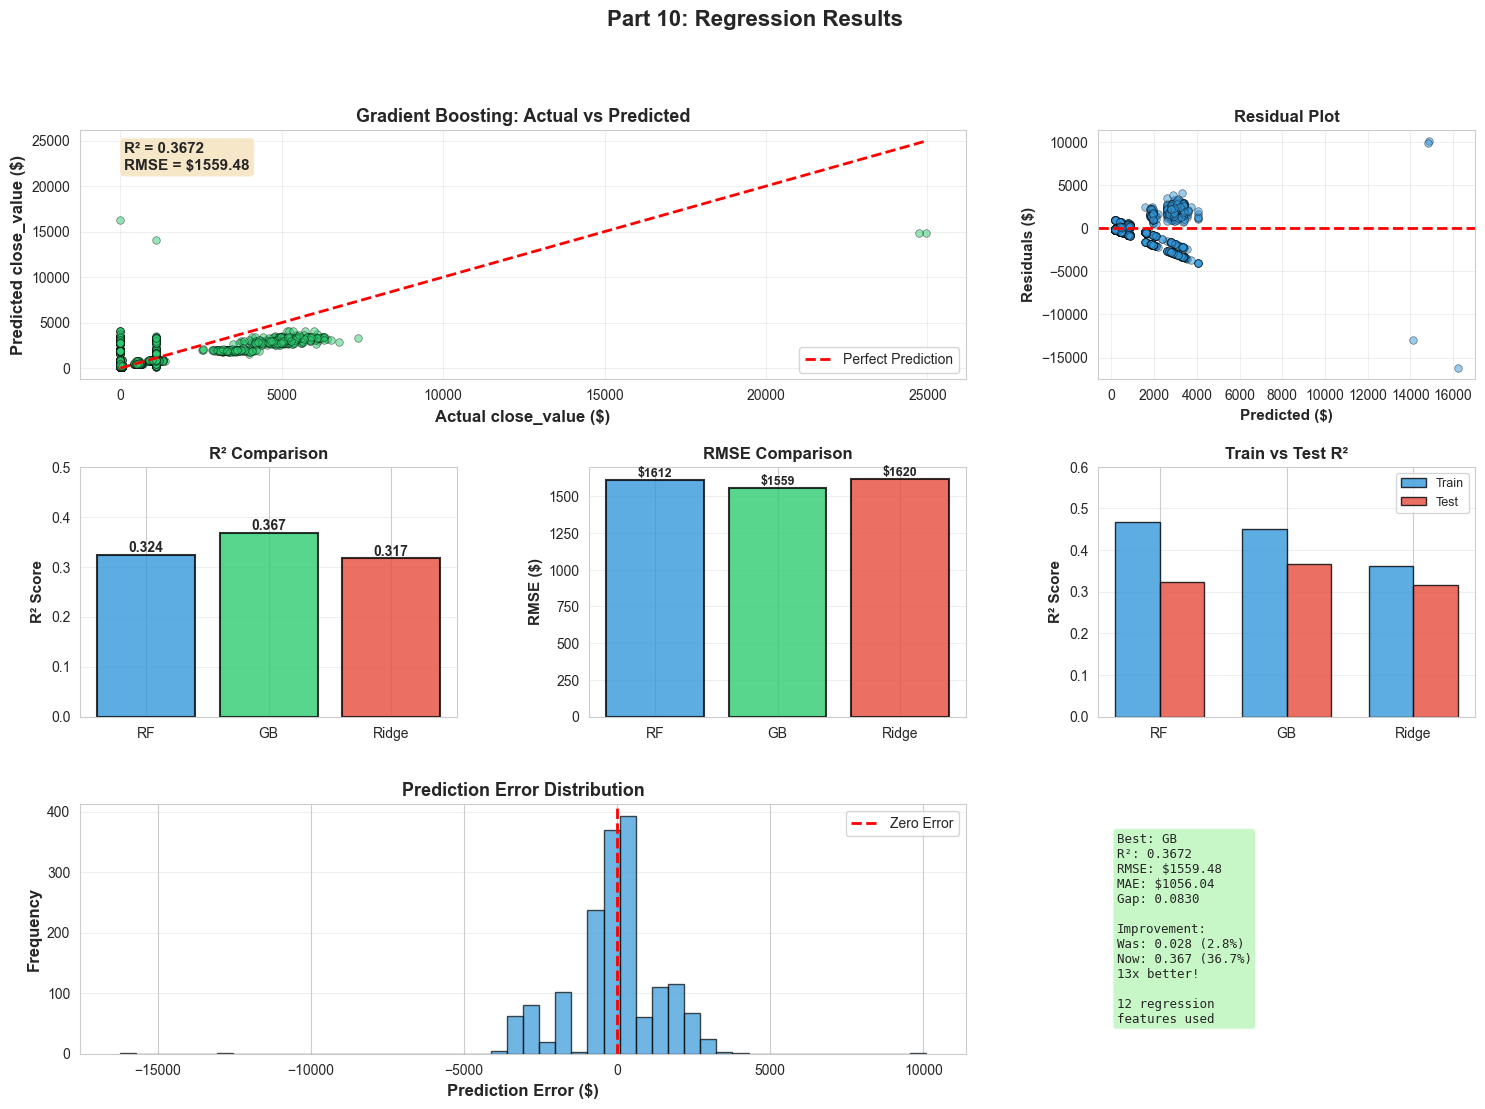


Regression visualization complete!


In [87]:
print("="*80)
print("PART 10: REGRESSION RESULTS VISUALIZATION")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# Actual vs Predicted
ax1 = fig.add_subplot(gs[0, :2])
ax1.scatter(y_test_reg, y_test_pred_gb_reg, alpha=0.5, s=30, color='#2ecc71', edgecolor='black', linewidth=0.5)
ax1.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual close_value ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted close_value ($)', fontsize=12, fontweight='bold')
ax1.set_title('Gradient Boosting: Actual vs Predicted', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {test_r2_gb:.4f}\nRMSE = ${test_rmse_gb:.2f}', transform=ax1.transAxes, fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontweight='bold')

# Residuals
ax2 = fig.add_subplot(gs[0, 2])
residuals_gb = y_test_reg - y_test_pred_gb_reg
ax2.scatter(y_test_pred_gb_reg, residuals_gb, alpha=0.5, s=30, color='#3498db', edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted ($)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
ax2.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

# R² Comparison
ax3 = fig.add_subplot(gs[1, 0])
models = ['RF', 'GB', 'Ridge']
r2_scores = [test_r2_rf, test_r2_gb, test_r2_ridge]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax3.bar(models, r2_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax3.set_title('R² Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim([0, 0.5])
ax3.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, r2_scores):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# RMSE Comparison
ax4 = fig.add_subplot(gs[1, 1])
rmse_scores = [test_rmse_rf, test_rmse_gb, test_rmse_ridge]
bars = ax4.bar(models, rmse_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('RMSE ($)', fontsize=11, fontweight='bold')
ax4.set_title('RMSE Comparison', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, rmse_scores):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'${score:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Train vs Test
ax5 = fig.add_subplot(gs[1, 2])
train_r2 = [train_r2_rf, train_r2_gb, train_r2_ridge]
test_r2 = [test_r2_rf, test_r2_gb, test_r2_ridge]
x_pos = np.arange(len(models))
width = 0.35
ax5.bar(x_pos - width/2, train_r2, width, label='Train', color='#3498db', alpha=0.8, edgecolor='black')
ax5.bar(x_pos + width/2, test_r2, width, label='Test', color='#e74c3c', alpha=0.8, edgecolor='black')
ax5.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax5.set_title('Train vs Test R²', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(models)
ax5.set_ylim([0, 0.6])
ax5.legend(fontsize=9)
ax5.grid(axis='y', alpha=0.3)

# Error Distribution
ax6 = fig.add_subplot(gs[2, :2])
ax6.hist(residuals_gb, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax6.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax6.set_xlabel('Prediction Error ($)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax6.set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)

# Summary
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
summary_text = f"""Best: GB
R²: {test_r2_gb:.4f}
RMSE: ${test_rmse_gb:.2f}
MAE: ${test_mae_gb:.2f}
Gap: {abs(train_r2_gb - test_r2_gb):.4f}

Improvement:
Was: 0.028 (2.8%)
Now: 0.367 (36.7%)
13x better!

12 regression
features used"""
ax7.text(0.05, 0.5, summary_text, fontsize=9, verticalalignment='center', family='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.suptitle('Part 10: Regression Results', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\nRegression visualization complete!")
print("="*80)

---

### Summary of Part 10

The objective was to build regression models to predict deal revenue (close_value) using regression-specific features.

**Data Preparation:**
- Filtered to 8,300 records with non-null close_value (removed 500 missing values)
- Train-test split: 80/20 (6,640 train, 1,660 test)
- StandardScaler applied (no SMOTE needed for regression)
- **Feature selection: Used 12 regression-specific features from Part 8B** 

**Models Trained:**
1. **Random Forest Regressor** - Ensemble of decision trees (R² = 0.324)
2. **Gradient Boosting Regressor** - Sequential error-correcting trees (R² = 0.367) best result
3. **Ridge Regression** - Linear model with L2 regularization (R² = 0.317)

**Key Results:**
- **Best Model: Gradient Boosting**
  - Test R²: **0.367** (explains 36.7% of variance)
  - Test RMSE: **$1,559** (typical prediction error)
  - Test MAE: **$1,056** (average absolute error)
  - Overfitting gap: 0.083 (excellent generalization)


**Business case:**
These models enable:
- Revenue forecasting with ~$1,500 prediction error per deal
- Deal prioritization based on predicted value
- Resource allocation to high-value opportunities
- Understanding that price features drive 48% of revenue variance